# 003. XGBoost 

This notebook trains and evaluates an XGBoost model to predict the duration of Supreme Court cases (in days) from oral argument to decision.

The process involves:
1.  **Loading and Setup**: Importing libraries and the custom `XGBoostModelTrainer`.
2.  **Feature Engineering**: Renaming, cleaning, and categorizing features from the SCDB dataset.
3.  **Leakage Control**: Carefully creating distinct feature sets to prevent data leakage and establish realistic performance baselines, but also considering another aproach not focused on prediction but rather analysis of past events.
4.  **Model Training**: Using the `XGBoostModelTrainer` to train models on different feature sets.
5.  **Hyperparameter Optimization**: Employing Optuna to find the optimal XGBoost parameters.
6.  **Results & XAI**: Preparing for the final analysis and explanation of the model's behavior.

### Table of Contents 

- [003. XGBoost](#003-xgboost)
    - [Table of Contents](#table-of-contents)
        - [Table of Contents generator](#table-of-contents-generator)
  - [1. Loading the dataset, setting up the trainere](#1-loading-the-dataset-setting-up-the-trainere)
  - [2. Variable documentation](#2-variable-documentation)
  - [3. Mapping names of the model and grouping features](#3-mapping-names-of-the-model-and-grouping-features)
        - [New map](#new-map)
        - [Old map](#old-map)
  - [4. Final data preparation for modelling](#4-final-data-preparation-for-modelling)
    - [Check for uncategorized features](#check-for-uncategorized-features)
  - [5. Modelling](#5-modelling)
      - [Function for displaying all information about each model](#function-for-displaying-all-information-about-each-model)
    - [Ensembling of models](#ensembling-of-models)
      - [Feature selection](#feature-selection)
  - [6. Handling the model outputs](#6-handling-the-model-outputs)
  - [7. Results](#7-results)

##### Table of Contents generator

In [1]:
# # TOC generation code:
# import sys
# import os

# # Add project root to sys.path
# notebook_dir = os.getcwd() 
# project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

# # Import TOC generator function
# from src.toc_generator import generate_toc_from_jupyter_notebook

# target_notebook_path = "003_XGB_XAI.ipynb" 

# toc_markdown = generate_toc_from_jupyter_notebook(target_notebook_path)

## 1. Loading the dataset, setting up the trainere

In this part we read the processed dataset. Then we import the XGBoostModelTrainer class from custom train_model.py script located in src folder. An instance (test) of this trainer is created with CUDA enabled, which will automatically use the GPU if available to speed up training. We also set up directories for saving models and plots.

In [2]:
# Libraries
import os
import sys
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
SEED = 420 # Choose seed
np.random.seed(SEED)
random.seed(SEED)

In [4]:
df = pd.read_csv(r'..\data\processed\scdb_processed_final.csv')

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# ---------------------------------------------

# Import .py xgboost trainer 
from src.train_model import XGBoostModelTrainer, load_model_for_xai

# Initialize trainer with CUDA support - later on will be reapplied
trainer = XGBoostModelTrainer(
    output_dir="../models",
    enable_cuda=True,      # Automatically detects and uses GPU if available
    random_state=SEED,
    organize_by_model=True # Creates separate folders for each model
)

# ? what 4? 4 GPUS? 
print(f"Trainer initialized. Using device: {trainer.device_info['device_name'].upper()}") 

# Store all results for final comparison 
all_results = {}

CUDA detected: 1 GPU(s) available.
Trainer initialized. Using device: CUDA


## 2. Variable documentation

Feature documentation done with html as it is not being marked as part of outline in VS Code.

Feature documentation is crucial for understanding the dataset and ensuring that the model is trained on the correct features. The following variables are used in this notebook:


<h3>Feature Documentation</h3>

<h4>Temporal Features</h4>

<h5><code>month_of_argument</code></h5>
Month (1-12) when oral arguments were held.
<ul>
<li>Earlier months (Oct-Dec) = beginning of term</li>
<li>Later months (Apr-Jun) = end of term rush</li>
<li>May indicate workload patterns</li>
</ul>

<h5><code>month_of_decision</code></h5>
Month (1-12) when the decision was announced.
<ul>
<li>June decisions often rushed (end of term)</li>
<li>May affect deliberation quality/time</li>
</ul>

<h5><code>year_of_decision</code></h5>
Calendar year of the decision.
<ul>
<li>Captures temporal trends in court efficiency</li>
<li>May correlate with historical events/court composition</li>
</ul>

<h5><code>days_term_start_to_argument</code></h5>
Days from term start (Oct 1) to oral argument.
<ul>
<li>Early term arguments may have more deliberation time</li>
<li>Late term arguments face deadline pressure</li>
</ul>

<h5><code>days_term_start_to_decision</code></h5>
Days from term start (Oct 1) to decision.
<ul>
<li>Measures when in the term cycle decision occurs</li>
<li>Later decisions may be more complex/contentious</li>
</ul>

<h5><code>is_argument_late_in_term</code></h5>
Binary flag: 1 if argued in April or later.
<ul>
<li>Late arguments have less time before term ends</li>
<li>May indicate expedited or important cases</li>
</ul>

<h5><code>is_decision_late_in_term</code></h5>
Binary flag: 1 if decided in May or later.
<ul>
<li>Captures "June rush" effect</li>
<li>May indicate complex/divided cases</li>
</ul>

<h4>Court Structure Features</h4>

<h5><code>chief_justice_code</code></h5>
Numeric code identifying the Chief Justice.
<ul>
<li>Different chiefs may have different management styles</li>
<li>Affects court efficiency and deliberation pace</li>
</ul>

<h5><code>natural_court_period</code></h5>
Code for stable membership periods.
<ul>
<li>New justices may slow deliberations</li>
<li>Established courts may work more efficiently</li>
</ul>

<h5><code>court_term_year</code></h5>
Supreme Court term year (Oct-June).
<ul>
<li>Historical context for the case</li>
<li>Captures era-specific patterns</li>
</ul>

<h4>Case Origin and Source</h4>

<h5><code>case_origin_type</code></h5>
Simplified grouping of originating court:
<ul>
<li>'Federal': Federal district/circuit courts</li>
<li>'State': State courts</li>
<li>'Other': Territorial, unknown, special</li>
</ul>

<h5><code>case_source_type</code></h5>
Simplified grouping of court directly reviewed:
<ul>
<li>'Federal': Federal courts</li>
<li>'State': State courts  </li>
<li>'Other': Special jurisdictions</li>
</ul>

<h4>Case Type and Jurisdiction</h4>

<h5><code>case_docket_type</code></h5>
Type of Supreme Court docket:
<ul>
<li>'Merits/Other': Standard argued cases</li>
<li>'Special Jurisdiction': Original/Miscellaneous</li>
</ul>

<h5><code>jurisdiction_type</code></h5>
How case reached Supreme Court:
<ul>
<li>'Discretionary': Certiorari (court chooses)</li>
<li>'Mandatory': Appeal/Original (must hear)</li>
<li>'Other': Writs, procedural, unknown</li>
</ul>

<h5><code>cert_reason_category</code></h5>
Grouped reasons for granting certiorari:
<ul>
<li>'Substantive Reasons': Important Q, conflicts</li>
<li>'Procedural/Administrative': No reason, N/A</li>
<li>'Other': Unknown, other reasons</li>
</ul>

<h4>Legal Issues</h4>

<h5><code>specific_legal_issue_code</code></h5>
Detailed numeric code for the specific legal issue.
<ul>
<li>High cardinality (many unique values)</li>
<li>More granular than broad issue area</li>
</ul>

<h5><code>broad_issue_area</code></h5>
Major subject matter categories:
<ul>
<li>'Economic Activity': Business, commerce</li>
<li>'Criminal Procedure': Rights of accused</li>
<li>'Civil Rights': Discrimination, voting</li>
<li>'Judicial Power': Court jurisdiction</li>
<li>'First Amendment': Speech, religion</li>
<li>'Other Constitutional': Due process, federalism</li>
<li>'Other Non-Constitutional': Unions, tax, etc.</li>
</ul>

<h5><code>law_type_category</code></h5>
Type of law being interpreted:
<ul>
<li>'Constitutional': Constitution/Amendments</li>
<li>'Statutory': Federal statutes</li>
<li>'Other/Unknown': Rules, state law, unclear</li>
</ul>

<h5><code>supplemental_law_code</code></h5>
Detailed code for specific law/statute.
<ul>
<li>Supplements law_type with specifics</li>
<li>High cardinality categorical</li>
</ul>

<h4>Party Configuration</h4>

<h5><code>petitioner_type</code></h5>
Simplified petitioner (appellant) category:
<ul>
<li>'Government': US/State/Local govt & agencies</li>
<li>'Private Entities': Individuals, business</li>
<li>'Other/Unknown': Unclear or special parties</li>
</ul>

<h5><code>respondent_type</code></h5>
Simplified respondent (appellee) category:
<ul>
<li>Same categories as petitioner_type</li>
<li>Captures party dynamics</li>
</ul>

<h5><code>is_govt_vs_business_case</code></h5>
Binary: 1 if government entity vs business.
<ul>
<li>May have different deliberation patterns</li>
<li>Captures David vs Goliath dynamics</li>
</ul>

<h5><code>is_individual_vs_govt_case</code></h5>
Binary: 1 if individual vs government.
<ul>
<li>Often civil rights/liberties cases</li>
<li>May require careful deliberation</li>
</ul>

<h5><code>is_state_vs_state_case</code></h5>
Binary: 1 if state government vs state government.
<ul>
<li>Original jurisdiction cases</li>
<li>Often boundary/water rights disputes</li>
</ul>

<h4>Lower Court Information</h4>

<h5><code>lower_court_disagreement</code></h5>
Binary: 1 if explicit lower court conflict.
<ul>
<li>Major reason for Supreme Court review</li>
<li>May require more deliberation to resolve</li>
</ul>

<h5><code>lower_court_ideological_direction</code></h5>
Lower court decision ideology:
<ul>
<li>1: Conservative</li>
<li>2: Liberal  </li>
<li>3: Unspecifiable/Missing</li>
</ul>

<h5><code>lower_court_disposition_type</code></h5>
How lower court decided:
<ul>
<li>'Affirmed': Upheld lower ruling</li>
<li>'Reversed/Modified': Changed ruling</li>
<li>'Other/Unknown': Procedural, unclear</li>
</ul>

<h5><code>lower_court_disagree_ideology</code></h5>
Interaction of disagreement and ideology:
<ul>
<li>'LC_Agree_Conservative': No conflict, conservative</li>
<li>'LC_Agree_Liberal': No conflict, liberal</li>
<li>'LC_Disagree_Conservative': Conflict, conservative</li>
<li>'LC_Disagree_Liberal': Conflict, liberal</li>
<li>'LC_Unspec/Other': Unclear</li>
</ul>

<h4>Case Complexity Indicators</h4>

<h5><code>consolidated_dockets_count</code></h5>
Number of dockets consolidated in this case.
<ul>
<li>Higher = more complex (multiple related cases)</li>
<li>May require longer deliberation</li>
</ul>

<h5><code>case_had_reargument</code></h5>
Binary: 1 if case was reargued.
<ul>
<li>Indicates initial arguments insufficient</li>
<li>Strong complexity/difficulty signal</li>
</ul>

<h5><code>complexity_score_consolidated_disagree</code></h5>
Interaction: dockets_count × lower_court_disagreement.
<ul>
<li>Captures compounded complexity</li>
<li>High values = consolidated cases with conflicts</li>
</ul>

<h5><code>three_judge_district_court</code></h5>
Binary: 1 if from 3-judge district court.
<ul>
<li>Special federal court panels</li>
<li>Often important constitutional cases</li>
</ul>

<h4>Specialized Features</h4>

<h5><code>is_admin_economic_case</code></h5>
Binary: 1 if administrative agency + economic issue.
<ul>
<li>Regulatory/business intersection</li>
<li>May have specialized complexity</li>
</ul>

<h5><code>is_federal_circuit_conflict</code></h5>
Binary: 1 if federal circuit court with conflict.
<ul>
<li>Circuit splits are key cert reason</li>
<li>Requires harmonizing precedents</li>
</ul>

<h4>Interaction Features</h4>

<h5><code>issue_jurisdiction_interaction</code></h5>
Concatenated issue area + jurisdiction path.
<ul>
<li>Captures if certain issues via certain paths have distinct duration patterns</li>
</ul>

<h5><code>three_judge_issue_interaction</code></h5>
Concatenated issue area + three-judge flag.
<ul>
<li>Tests if 3-judge court effect varies by issue</li>
</ul>

<h4>Target Variable</h4>

<h5><code>case_duration_days</code></h5>
TARGET VARIABLE: Days from argument to decision.
<ul>
<li>What we're predicting</li>
<li>Measures deliberation time</li>
</ul>

<h4>Missing Value Indicators</h4>

<h5><code>lower_court_disagree_was_missing</code></h5>
Binary: 1 if lcDisagreement was originally missing.
<ul>
<li>Allows model to learn from missingness pattern</li>
<li>Missing may indicate certain case types</li>
</ul>

<h5><code>three_judge_info_was_missing</code></h5>
Binary: 1 if threeJudgeFdc was originally missing.
<ul>
<li>Captures data quality/availability patterns</li>
</ul>

<h4>Derived Features</h4>

<h5><code>decision_timing_category</code></h5>
Binned version of duration_days.
<ul>
<li>Could be used for classification instead of regression</li>
<li>Categories like 'Quick', 'Normal', 'Slow'</li>
</ul>

## 3. Mapping names of the model and grouping features

The raw dataset uses column names that are not easily recognizable (e.g., `lcDisagreement`, `threeJudgeFdc`). To improve readability, we will first map these to more recognizible names (e.g., `lower_court_disagreement`, `three_judge_district_court`).

##### New map

In [5]:
# 1. Define the complete mapping from raw column names to new descriptive names.
new_feature_name_mapping = {
    # Temporal Features
    'argument_month': 'month_of_argument',
    'decision_month': 'month_of_decision',
    'decision_year': 'year_of_decision',
    'days_from_term_start_to_argument': 'days_term_start_to_argument',
    'days_from_term_start_to_decision': 'days_term_start_to_decision',
    'is_late_term_argument': 'is_argument_late_in_term',
    'is_late_term_decision': 'is_decision_late_in_term',

    # Court Structure Features
    'chief': 'chief_justice_sname',
    'naturalCourt': 'natural_court_period',
    'term': 'court_term_year',

    # Case Origin and Source
    'caseOrigin_group': 'case_origin_type',
    'caseSource_group': 'case_source_type',

    # Case Type and Jurisdiction
    'docket_category': 'case_docket_type',
    'jurisdiction_group': 'jurisdiction_type',
    'certReason_group': 'cert_reason_category',

    # Legal Issues
    'issueArea_name': 'broad_issue_area',
    'lawType_group': 'law_type_category',

    # Party Configuration
    'petitioner_group': 'petitioner_type',
    'respondent_group': 'respondent_type',
    'is_Govt_vs_Business': 'is_govt_vs_business_case',
    'is_Individual_vs_Govt': 'is_individual_vs_govt_case',
    'is_State_vs_State': 'is_state_vs_state_case',

    # Lower Court Information
    'lcDisagreement': 'lower_court_disagreement',
    'lcDisposition_group': 'lower_court_disposition_type',
    'lcDispositionDirection_cons': 'lower_court_disposition_direction_conservative',
    'lcDispositionDirection_lib': 'lower_court_disposition_direction_liberal',

    # Case Complexity Indicators
    'num_dockets_in_case': 'consolidated_dockets_count',
    'had_reargument': 'case_had_reargument',
    'complex_consolidated_disagreement': 'complexity_score_consolidated_disagree',
    'threeJudgeFdc': 'three_judge_district_court',

    # Specialized Features
    'is_AdminAction_x_Economic': 'is_admin_economic_case',
    'is_FedCirc_Conflict': 'is_federal_circuit_conflict',

    # Target Variable
    'duration_days': 'case_duration_days',

    # Missing Value Indicators
    'lcDisagreement_is_missing': 'lower_court_disagree_was_missing',
    'threeJudgeFdc_is_missing': 'three_judge_info_was_missing'
}

# 2. Perform the renaming operation.
df_renamed = df.rename(columns=new_feature_name_mapping)

# 3. Generate statistics by comparing original columns to the mapping.
original_cols = df.columns.tolist()
changed_columns = {}
unchanged_columns = []

for col_name in original_cols:
    if col_name in new_feature_name_mapping:
        changed_columns[col_name] = new_feature_name_mapping[col_name]
    else:
        unchanged_columns.append(col_name)

# 4. Print the final report to the console.
print("--- Rename Operation Statistics ---")
print(f"Total Columns in DataFrame: {len(original_cols)}")
print(f"Columns Renamed: {len(changed_columns)}")
print(f"Columns Left Unchanged: {len(unchanged_columns)}")
print("-" * 35)

if changed_columns:
    print("\nDetails of Renamed Columns (Old Name -> New Name):")
    for old_name, new_name in changed_columns.items():
        print(f"   '{old_name}' -> '{new_name}'")

if unchanged_columns:
    print("\nDetails of Unchanged Columns (Not Found in Mapping):")
    for name in unchanged_columns:
        print(f"   '{name}'")
else:
    print("\nAll columns in the original DataFrame were found in the mapping dictionary.")

--- Rename Operation Statistics ---
Total Columns in DataFrame: 35
Columns Renamed: 35
Columns Left Unchanged: 0
-----------------------------------

Details of Renamed Columns (Old Name -> New Name):
   'argument_month' -> 'month_of_argument'
   'caseOrigin_group' -> 'case_origin_type'
   'caseSource_group' -> 'case_source_type'
   'certReason_group' -> 'cert_reason_category'
   'chief' -> 'chief_justice_sname'
   'complex_consolidated_disagreement' -> 'complexity_score_consolidated_disagree'
   'days_from_term_start_to_argument' -> 'days_term_start_to_argument'
   'days_from_term_start_to_decision' -> 'days_term_start_to_decision'
   'decision_month' -> 'month_of_decision'
   'decision_year' -> 'year_of_decision'
   'docket_category' -> 'case_docket_type'
   'had_reargument' -> 'case_had_reargument'
   'is_AdminAction_x_Economic' -> 'is_admin_economic_case'
   'is_FedCirc_Conflict' -> 'is_federal_circuit_conflict'
   'is_Govt_vs_Business' -> 'is_govt_vs_business_case'
   'is_Individu

For easier analysis and grouped feature importance plots later on (in the XAI phase), we are grouping the renamed features into logical categories.

In [6]:
print("=== ADJUSTED FEATURE CATEGORIES AND COUNTS ===\n")

# This dictionary uses the new, cleaner feature names after renaming.
# It's structured for clarity and can be used for further analysis, like with XAI.
adjusted_feature_categories = {
    'Temporal Features': [
        'month_of_argument', 'month_of_decision', 'year_of_decision',
        'days_term_start_to_argument', 'days_term_start_to_decision',
        'is_argument_late_in_term', 'is_decision_late_in_term'
    ],
    'Court Structure': [
        'chief_justice_sname', 'natural_court_period', 'court_term_year'
    ],
    'Case Origin/Source': [
        'case_origin_type', 'case_source_type'
    ],
    'Case Type/Jurisdiction': [
        'case_docket_type', 'jurisdiction_type', 'cert_reason_category'
    ],
    'Legal Issues': [
        'broad_issue_area', 'law_type_category'
    ],
    'Party Configuration': [
        'petitioner_type', 'respondent_type', 'is_govt_vs_business_case',
        'is_individual_vs_govt_case', 'is_state_vs_state_case'
    ],
    'Lower Court Info': [
        'lower_court_disagreement', 'lower_court_disposition_type',
        'lower_court_disposition_direction_conservative',
        'lower_court_disposition_direction_liberal'
    ],
    'Complexity Indicators': [
        'consolidated_dockets_count', 'case_had_reargument',
        'complexity_score_consolidated_disagree', 'three_judge_district_court'
    ],
    'Specialized Features': [
        'is_admin_economic_case', 'is_federal_circuit_conflict'
    ],
    'Missing Indicators': [
        'lower_court_disagree_was_missing', 'three_judge_info_was_missing'
    ],
    'Target Variable': [
        'case_duration_days'
    ]
}

total_features = 0
print("Feature counts per category:")
for category, features in adjusted_feature_categories.items():
    count = len(features)
    total_features += count
    print(f"- {category}: {count} features")

print(f"\nTotal features categorized: {total_features}")

=== ADJUSTED FEATURE CATEGORIES AND COUNTS ===

Feature counts per category:
- Temporal Features: 7 features
- Court Structure: 3 features
- Case Origin/Source: 2 features
- Case Type/Jurisdiction: 3 features
- Legal Issues: 2 features
- Party Configuration: 5 features
- Lower Court Info: 4 features
- Complexity Indicators: 4 features
- Specialized Features: 2 features
- Missing Indicators: 2 features
- Target Variable: 1 features

Total features categorized: 35


##### Old map

In [7]:
# # Create a mapping dictionary for cleaner column names
# feature_name_mapping = {
#     # Temporal Features
#     'argument_month': 'month_of_argument',
#     'decision_month': 'month_of_decision', 
#     'decision_year': 'year_of_decision',
#     'days_from_term_start_to_argument': 'days_term_start_to_argument',
#     'days_from_term_start_to_decision': 'days_term_start_to_decision',
#     'is_late_term_argument': 'is_argument_late_in_term',
#     'is_late_term_decision': 'is_decision_late_in_term',
    
#     # Court Structure Features
#     'chief': 'chief_justice_sname',
#     'naturalCourt': 'natural_court_period',
#     'term': 'court_term_year',
    
#     # Case Origin and Source
#     'caseOrigin_group': 'case_origin_type',
#     'caseSource_group': 'case_source_type',
    
#     # Case Type and Jurisdiction
#     'docket_category': 'case_docket_type',
#     'jurisdiction_group': 'jurisdiction_type',
#     'certReason_group': 'cert_reason_category',
    
#     # Legal Issues
#     'issue': 'specific_legal_issue_code',
#     'issueArea_name': 'broad_issue_area',
#     'lawType_group': 'law_type_category',
#     'lawSupp': 'supplemental_law_code',
    
#     # Party Configuration
#     'petitioner_group': 'petitioner_type',
#     'respondent_group': 'respondent_type',
#     'is_Govt_vs_Business': 'is_govt_vs_business_case',
#     'is_Individual_vs_Govt': 'is_individual_vs_govt_case',
#     'is_State_vs_State': 'is_state_vs_state_case',
    
#     # Lower Court Information
#     'lcDisagreement': 'lower_court_disagreement',
#     'lcDispositionDirection': 'lower_court_ideological_direction',
#     'lcDisposition_group': 'lower_court_disposition_type',
#     'lc_disagree_direction': 'lower_court_disagree_ideology',
    
#     # Case Complexity Indicators
#     'num_dockets_in_case': 'consolidated_dockets_count',
#     'had_reargument': 'case_had_reargument',
#     'complex_consolidated_disagreement': 'complexity_score_consolidated_disagree',
#     'threeJudgeFdc': 'three_judge_district_court',
    
#     # Specialized Features
#     'is_AdminAction_x_Economic': 'is_admin_economic_case',
#     'is_FedCirc_Conflict': 'is_federal_circuit_conflict',
    
#     # Interaction Features
#     'issue_x_jurisdiction': 'issue_jurisdiction_interaction',
#     'threeJudge_x_issue': 'three_judge_issue_interaction',
    
#     # Target Variable
#     'duration_days': 'case_duration_days',
    
#     # Missing Value Indicators
#     'lcDisagreement_is_missing': 'lower_court_disagree_was_missing',
#     'threeJudgeFdc_is_missing': 'three_judge_info_was_missing',
    
#     # Derived Features
#     'decision_timing_bin': 'decision_timing_category'
# }

# # Apply the mapping to rename columns
# #df = df.rename(columns=feature_name_mapping)
# print(df.columns.tolist())
# #print(df.shape[1])

For easier analysis and grouped feature importance plots later on (in the XAI phase), we are grouping the renamed features into logical categories.

In [8]:
# print("=== FEATURE CATEGORIES AND COUNTS ===\n")

# feature_categories = {
#     'Temporal Features': ['month_of_argument', 'month_of_decision', 'year_of_decision', 
#                             'days_term_start_to_argument', 'days_term_start_to_decision',
#                             'is_argument_late_in_term', 'is_decision_late_in_term'],
#     'Court Structure': ['chief_justice_sname', 'natural_court_period', 'court_term_year'],
#     'Case Origin/Source': ['case_origin_type', 'case_source_type'],
#     'Case Type/Jurisdiction': ['case_docket_type', 'jurisdiction_type', 'cert_reason_category'],
#     'Legal Issues': ['specific_legal_issue_code', 'broad_issue_area', 'law_type_category', 'supplemental_law_code'],
#     'Party Configuration': ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case',
#                            'is_individual_vs_govt_case', 'is_state_vs_state_case'],
#     'Lower Court Info': ['lower_court_disagreement', 'lower_court_ideological_direction',
#                         'lower_court_disposition_type', 'lower_court_disagree_ideology'],
#     'Complexity Indicators': ['consolidated_dockets_count', 'case_had_reargument',
#                              'complexity_score_consolidated_disagree', 'three_judge_district_court'],
#     'Specialized Features': ['is_admin_economic_case', 'is_federal_circuit_conflict'],
#     'Interaction Features': ['issue_jurisdiction_interaction', 'three_judge_issue_interaction'],
#     'Missing Indicators': ['lower_court_disagree_was_missing', 'three_judge_info_was_missing'],
#     'Target/Derived': ['case_duration_days', 'decision_timing_category']
# }

# for category, features in feature_categories.items():
#     print(f"{category}: {len(features)} features")
    
# print(f"\nTotal features: {sum(len(f) for f in feature_categories.values())}")

## 4. Final data preparation for modelling

In this section the final cleaning and preparation of the data before it's fed into the model is performed. 

Key steps include:
- **Dropping leaky or problematic features**: Removing columns that wouldn't be available at prediction time or that are direct derivatives of the target.
- **Managing cardinality**: Grouping rare categorical values to prevent overfitting.
- **Defining feature types**: Explicitly identifying numerical, binary, and categorical features for the preprocessing pipeline.
- **Creating distinct feature sets**: Building `basic`, `leakage_controlled`, and `full_with_leakage` sets to properly evaluate the model's predictive power (with potential data leakage) and without data leakage.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')


# ========================================
# STEP 1: Apply Feature Renaming ( already done above, but kept for clarity)
# ========================================

print("=== STEP 1: Renaming Features ===")
df_renamed = df.rename(columns=new_feature_name_mapping) #feature_name_mapping
print(f"Features renamed. New shape: {df_renamed.shape}")


# ========================================
# STEP 2: Handle Problematic Features
# ========================================

print("\n=== STEP 2: Handling Problematic Features ===")

# 2.1: Drop high-cardinality interaction features and clear leakage
features_to_drop = [
    'case_had_reargument'  # STRONG LEAKAGE: only known AFTER initial arguments; excluded from each set
]

print(f"Dropping {len(features_to_drop)} problematic features...")
print("Reasons for dropping:")
print("  - case_had_reargument: Strong leakage - only known after arguments fail")


df_cleaned = df_renamed.drop(columns=[f for f in features_to_drop if f in df_renamed.columns])
print(f"New shape after dropping: {df_cleaned.shape}")

=== STEP 1: Renaming Features ===
Features renamed. New shape: (9534, 35)

=== STEP 2: Handling Problematic Features ===
Dropping 1 problematic features...
Reasons for dropping:
  - case_had_reargument: Strong leakage - only known after arguments fail
New shape after dropping: (9534, 34)


In this section we will handle additional of new variables that are not directly related to the model training but are useful for analysis and understanding of the data. May later be added to 001_DataCleaning.ipynb

In [10]:
df_cleaned.columns

Index(['month_of_argument', 'case_origin_type', 'case_source_type',
       'cert_reason_category', 'chief_justice_sname',
       'complexity_score_consolidated_disagree', 'days_term_start_to_argument',
       'days_term_start_to_decision', 'month_of_decision', 'year_of_decision',
       'case_docket_type', 'is_admin_economic_case',
       'is_federal_circuit_conflict', 'is_govt_vs_business_case',
       'is_individual_vs_govt_case', 'is_state_vs_state_case',
       'is_argument_late_in_term', 'is_decision_late_in_term',
       'broad_issue_area', 'jurisdiction_type', 'law_type_category',
       'lower_court_disagreement', 'lower_court_disposition_type',
       'natural_court_period', 'consolidated_dockets_count', 'petitioner_type',
       'respondent_type', 'court_term_year', 'three_judge_district_court',
       'case_duration_days', 'lower_court_disagree_was_missing',
       'three_judge_info_was_missing',
       'lower_court_disposition_direction_conservative',
       'lower_court_di

In [11]:
# Fill missing broad_issue_area with 'Unknown' and show updated counts
df_cleaned["broad_issue_area"].fillna("Unknown", inplace=True)

# 1. Seasonality features (NOT LEAKAGE)
df_cleaned['arg_month_sin'] = np.sin(2 * np.pi * df_cleaned['month_of_argument']/12.0)
df_cleaned['arg_month_cos'] = np.cos(2 * np.pi * df_cleaned['month_of_argument']/12.0)

# 2. Jurisdiction × Issue interaction (NOT LEAKAGE)
df_cleaned['jurisdiction_x_issue'] = (
    df_cleaned['jurisdiction_type'].astype(str) + '_X_' + 
    df_cleaned['broad_issue_area'].astype(str)
)

# 3. Additional temporal features (NOT LEAKAGE)
df_cleaned['quarter_of_argument'] = df_cleaned['month_of_argument'].apply(
    lambda x: (x-1)//3 + 1
)
df_cleaned['is_summer_recess'] = df_cleaned['month_of_argument'].isin([7, 8]).astype(int)

# 4. Complexity score squared (NOT LEAKAGE)
df_cleaned['complexity_score_sq'] = df_cleaned['complexity_score_consolidated_disagree']**2

# =============================================================================
# 5. Litigant Conflict Dyad (NOT LEAKAGE)
# =============================================================================
# This function now creates a directional dyad (A-vs-B is different from B-vs-A)
def create_directional_conflict_dyad(row):
    """
    Combines pre-categorized petitioner and respondent types into a single,
    DIRECTIONAL dyad to represent the nature of the conflict.
    """
    p_cat = str(row['petitioner_type'])
    r_cat = str(row['respondent_type'])
    
    # Do NOT sort. The order of petitioner vs. respondent is preserved.
    return f"{p_cat}-vs-{r_cat}"

# Apply the function to your existing df_cleaned to create the new feature
df_cleaned['conflict_dyad'] = df_cleaned.apply(create_directional_conflict_dyad, axis=1)

# --- Investigation Step ---
# Use value_counts() to see the distribution of the directional conflict types.
print("Distribution of Directional Conflict Dyads:")
print(df_cleaned['conflict_dyad'].value_counts())


# =============================================================================
# 6. Circuit Split Flag (NOT LEAKAGE)
# =============================================================================
# This flags cases taken specifically to resolve a federal court conflict.
# The certReason variable is the source for this information.
df_cleaned['is_circuit_split'] = np.where(
    df_cleaned['cert_reason_category'].str.contains('federal court conflict', na=False), 1, 0
)


# =============================================================================
# 7. Lower Court Disposition Complexity (NOT LEAKAGE)
# =============================================================================
# This categorizes the lower court's action as simple (clean affirm/reverse) 
# or complex (remand, partial decision). Based on lcDisposition.
def categorize_disposition(disposition):
    disposition = str(disposition).lower()
    if 'remand' in disposition or 'in part' in disposition:
        return 'complex'
    elif 'affirm' in disposition or 'reverse' in disposition:
        return 'simple'
    else:
        return 'other'

df_cleaned['lc_disposition_complexity'] = df_cleaned['lower_court_disposition_type'].apply(categorize_disposition)


# =============================================================================
# 8. Case Sequence within Term (NOT LEAKAGE)
# =============================================================================
# Ranks the chronological order of oral arguments within a court term.
df_cleaned['case_sequence_in_term'] = df_cleaned.groupby('court_term_year')['days_term_start_to_argument'].rank(method='dense')

Distribution of Directional Conflict Dyads:
conflict_dyad
Other/Unknown-vs-Government             2014
Other/Unknown-vs-Other/Unknown          1815
Government-vs-Other/Unknown             1635
Private Entities-vs-Government          1184
Government-vs-Private Entities          1020
Private Entities-vs-Other/Unknown        592
Private Entities-vs-Private Entities     481
Other/Unknown-vs-Private Entities        480
Government-vs-Government                 313
Name: count, dtype: int64


Rationale for Data Leakage Exclusions 

The guiding principle for excluding these variables is to prevent **data leakage**. For a predictive model, we can only use information that would be available at the exact moment of prediction (in this case, immediately after oral arguments). Any variable that is created using information about the final decision itself must be excluded from this set. On the other hand we have also set if features that is used for analysis of past events, not for prediction, and therefore can be included in the feature set.

1. Variables: `days_term_start_to_decision`, `month_of_decision`, `year_of_decision`

* **Reason for Exclusion:** These features are directly calculated from the final decision date. At the time of prediction, this date is a future event and is therefore unknown. Including them would be equivalent to giving the model the answers before the test.

2. Variable: `is_decision_late_in_term`

* **Reason for Exclusion:** This is a more subtle but critical case of leakage. Even though you know the court's calendar and when the term generally ends, this feature **requires knowing the `month_of_decision` for a specific case** to be calculated. Since the decision month is an unknown future event at the time of prediction, this feature cannot be created without using future information. It is therefore a source of data leakage and must be excluded from the predictive feature set.

In [12]:
# ========================================
# STEP 3: Separate Features by Type
# ========================================

print("\n=== STEP 3: Identifying Feature Types ===")

# Define numerical features (continuous values)
numerical_features = [
    'month_of_argument',
    'month_of_decision', 
    'year_of_decision',
    'days_term_start_to_argument',
    'days_term_start_to_decision',
    'natural_court_period',
    'court_term_year',
    'lower_court_disagreement',
    'consolidated_dockets_count',
    'complexity_score_consolidated_disagree',
    'three_judge_district_court',
    'arg_month_cos', # new testing
    'arg_month_sin', # new testing
    'quarter_of_argument', # new testing
    'complexity_score_sq',            # new testing
    'case_sequence_in_term'           # new testing
]

# Define binary features (0/1 flags)
binary_features = [
    'is_argument_late_in_term',
    'is_decision_late_in_term',
    'is_govt_vs_business_case',
    'is_individual_vs_govt_case',
    'is_state_vs_state_case',
    'is_admin_economic_case',
    'is_federal_circuit_conflict',
    'lower_court_disagree_was_missing',
    'three_judge_info_was_missing',
    'lower_court_disposition_direction_conservative', 
    'lower_court_disposition_direction_liberal',
    'is_summer_recess', # new testing    
    'is_circuit_split' # new testing
]

# Define categorical features (may need encoding)
categorical_features = [
    'case_origin_type',
    'case_source_type',
    'case_docket_type',
    'jurisdiction_type',
    'cert_reason_category',
    'broad_issue_area',
    'law_type_category',
    'petitioner_type',
    'respondent_type',
    'lower_court_disposition_type',
    'chief_justice_sname',
    'jurisdiction_x_issue', # new testing
    'conflict_dyad',                  # new testing
    'lc_disposition_complexity'       # new testing
]

# Filter definitions by columns existing in df_cleaned
numerical_features = [f for f in numerical_features if f in df_cleaned.columns]
binary_features = [f for f in binary_features if f in df_cleaned.columns]
categorical_features = [f for f in categorical_features if f in df_cleaned.columns]

# Ensure features are in at most one list
cat_set = set(categorical_features)
bin_set = set(binary_features)

temp_binary = []
for f in binary_features:
    if f not in cat_set:
        temp_binary.append(f)
binary_features = temp_binary
bin_set = set(binary_features)

temp_numerical = []
for f in numerical_features:
    if f not in cat_set and f not in bin_set:
        temp_numerical.append(f)
numerical_features = temp_numerical

print(f"Numerical features identified: {len(numerical_features)}")
print(f"Binary features identified: {len(binary_features)}")
print(f"Categorical features identified: {len(categorical_features)}")


# ========================================
# STEP 4: Create Feature Sets for Modeling
# ========================================
print("\n=== STEP 4: Creating Feature Sets ===")

# Define clear leakage variables (information not available at prediction time)
clear_leakage_vars = [ # without the reargument as it is already dropped
    'days_term_start_to_decision',  # Requires knowing decision date
    'month_of_decision',            # Decision month unknown at argument time
    'year_of_decision',             # Decision year unknown at argument time
    'is_decision_late_in_term'      # Also requires knowing decision date
]

# Target variable (excluded from all feature sets)
model_input_exclusions = ['case_duration_days']

# --- 4.1: Basic Feature Set ---
# Core features that are most reliable and interpretable
basic_features = [
    # Temporal (known at argument time)
    'month_of_argument', 
    'days_term_start_to_argument',
    'is_argument_late_in_term',
    # Court
    'court_term_year', 
    'natural_court_period',
    'chief_justice_sname',
    # Case type
    'case_docket_type', 
    'jurisdiction_type', 
    'broad_issue_area',
    # Parties
    'petitioner_type', 
    'respondent_type',
    # Complexity
    'consolidated_dockets_count',
    # Lower court
    'lower_court_disagreement', 
    'lower_court_disposition_type'
]

basic_features_final = [f for f in basic_features if f in df_cleaned.columns]
print(f"\nBasic feature set includes core predictors known at argument time")
print(f"Basic features: {len(basic_features_final)} features")

# --- 4.2: Full Feature Set WITH Leakage ---
# All features except target - includes decision-time information
# This helps understand upper bound of predictive performance
full_features_with_leakage_final = [
    col for col in df_cleaned.columns if col not in model_input_exclusions
]
print(f"\nFull feature set includes ALL features (including leakage)")
print(f"Full with leakage: {len(full_features_with_leakage_final)} features")

# --- 4.3: Leakage-Controlled Feature Set ---
# All features except those with clear leakage
# This is the recommended set for actual prediction
leakage_controlled_features_final = [
    f for f in full_features_with_leakage_final
    if f not in clear_leakage_vars
]
print(f"\nLeakage-controlled set excludes decision-time information")
print(f"Leakage-controlled: {len(leakage_controlled_features_final)} features")

# Show what's being excluded as leakage
leakage_features_in_data = [f for f in clear_leakage_vars if f in full_features_with_leakage_final]
print(f"\nFeatures identified as leakage and excluded from controlled set:")
for feat in leakage_features_in_data:
    print(f"  - {feat}")


# ========================================
# STEP 5 & 6: Prepare Data and Configurations
# ========================================
print("\n=== STEP 5 & 6: Preparing Data and Configurations for Each Feature Set ===")

if 'case_duration_days' not in df_cleaned.columns:
    raise ValueError("'case_duration_days' target variable not found in df_cleaned.")
y = df_cleaned['case_duration_days']

# Using the three specifically requested feature sets
feature_sets_to_prepare = {
    "basic": basic_features_final,
    "full_with_leakage": full_features_with_leakage_final,
    "leakage_controlled": leakage_controlled_features_final
}

all_model_inputs = {}

for set_name, selected_features_list in feature_sets_to_prepare.items():
    print(f"\n--- Preparing for feature set: {set_name.upper()} ---")
    
    X_current = df_cleaned[selected_features_list].copy()
    print(f"X_{set_name} shape: {X_current.shape}")

    current_numerical_typed = [f for f in numerical_features if f in X_current.columns]
    current_binary_typed = [f for f in binary_features if f in X_current.columns]
    current_categorical_typed = [f for f in categorical_features if f in X_current.columns]
    
    # For XGBoost, numerical and binary can be treated the same
    current_numerical_for_trainer = current_numerical_typed + current_binary_typed
    current_categorical_for_trainer = current_categorical_typed
    
    # Sanity check
    trainer_features_set = set(current_numerical_for_trainer + current_categorical_for_trainer)
    x_current_set = set(X_current.columns)
    if trainer_features_set != x_current_set:
        print(f"Warning for set '{set_name}': Feature mismatch detected")
        missing_from_trainer = x_current_set - trainer_features_set
        if missing_from_trainer:
            print(f"  Missing from trainer config: {missing_from_trainer}")

    print(f"For XGBoostModelTrainer ({set_name} set):")
    print(f"  Numerical + Binary features: {len(current_numerical_for_trainer)}")
    print(f"  Categorical features: {len(current_categorical_for_trainer)}")

    all_model_inputs[set_name] = {
        'X': X_current,
        'y': y,
        'numerical_for_trainer': current_numerical_for_trainer,
        'categorical_for_trainer': current_categorical_for_trainer,
        'feature_list': selected_features_list 
    }

print(f"\nTarget variable statistics:")
print(f"  Mean duration: {y.mean():.1f} days")
print(f"  Median duration: {y.median():.1f} days")
print(f"  Std deviation: {y.std():.1f} days")
print(f"  Min: {y.min():.0f} days, Max: {y.max():.0f} days")


# ========================================
# STEP 7: Feature Importance Analysis Setup
# ========================================
print("\n=== STEP 7: Feature Analysis Preparation ===")

# Using leakage_controlled set for feature grouping
if 'leakage_controlled' in all_model_inputs:
    selected_features_for_groups = all_model_inputs['leakage_controlled']['feature_list']

    feature_groups = {
        'Temporal': [f for f in ['month_of_argument', 'days_term_start_to_argument', 'is_argument_late_in_term'] 
                     if f in selected_features_for_groups],
        'Court Structure': [f for f in ['chief_justice_sname', 'natural_court_period', 'court_term_year'] 
                           if f in selected_features_for_groups],
        'Case Type': [f for f in ['case_docket_type', 'jurisdiction_type', 'cert_reason_category', 
                                 'case_origin_type', 'case_source_type'] 
                     if f in selected_features_for_groups],
        'Legal Issues': [f for f in ['broad_issue_area', 'law_type_category', 'specific_legal_issue_grouped'] 
                        if f in selected_features_for_groups],
        'Parties': [f for f in ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case', 
                               'is_individual_vs_govt_case', 'is_state_vs_state_case'] 
                   if f in selected_features_for_groups],
        'Lower Court': [f for f in ['lower_court_disagreement', 'lower_court_disposition_type', 
                                   'lower_court_ideological_direction', 'lower_court_disagree_ideology'] 
                       if f in selected_features_for_groups],
        'Complexity': [f for f in ['consolidated_dockets_count', 'complexity_score_consolidated_disagree', 
                                  'three_judge_district_court'] 
                      if f in selected_features_for_groups],
        'Missing Indicators': [f for f in ['lower_court_disagree_was_missing', 'three_judge_info_was_missing'] 
                              if f in selected_features_for_groups],
        'Specialized': [f for f in ['is_admin_economic_case', 'is_federal_circuit_conflict'] 
                       if f in selected_features_for_groups]
    }
    
    # Remove empty groups
    feature_groups = {name: f_list for name, f_list in feature_groups.items() if f_list}

    print("\nFeature groups for importance analysis:")
    for group, features_in_group in feature_groups.items():
        print(f"  {group}: {len(features_in_group)} features")
        
    # Show feature distribution across sets
    print("\n=== Feature Set Comparison ===")
    print(f"Basic set: {len(all_model_inputs['basic']['feature_list'])} features")
    print(f"Leakage-controlled set: {len(all_model_inputs['leakage_controlled']['feature_list'])} features")
    print(f"Full with leakage set: {len(all_model_inputs['full_with_leakage']['feature_list'])} features")
    
    # Features only in full set (leakage features)
    leakage_only = set(all_model_inputs['full_with_leakage']['feature_list']) - set(all_model_inputs['leakage_controlled']['feature_list'])
    if leakage_only:
        print(f"\nLeakage features (only in full set): {leakage_only}")
    
    # Additional features in leakage-controlled vs basic
    additional_controlled = set(all_model_inputs['leakage_controlled']['feature_list']) - set(all_model_inputs['basic']['feature_list'])
    if additional_controlled:
        print(f"\nAdditional features in leakage-controlled vs basic:")
        for feat in sorted(additional_controlled):
            print(f"  - {feat}")


print("\n=== PREPROCESSING COMPLETE ===")
print("Ready for model training with three feature sets:")
print("1. 'basic': Core reliable features for baseline")
print("2. 'full_with_leakage': All features to understand upper bound")
print("3. 'leakage_controlled': Recommended for actual predictions")
print("\nall_model_inputs dictionary contains X, y, and feature configurations for each set.")


=== STEP 3: Identifying Feature Types ===
Numerical features identified: 16
Binary features identified: 13
Categorical features identified: 14

=== STEP 4: Creating Feature Sets ===

Basic feature set includes core predictors known at argument time
Basic features: 14 features

Full feature set includes ALL features (including leakage)
Full with leakage: 43 features

Leakage-controlled set excludes decision-time information
Leakage-controlled: 39 features

Features identified as leakage and excluded from controlled set:
  - days_term_start_to_decision
  - month_of_decision
  - year_of_decision
  - is_decision_late_in_term

=== STEP 5 & 6: Preparing Data and Configurations for Each Feature Set ===

--- Preparing for feature set: BASIC ---
X_basic shape: (9534, 14)
For XGBoostModelTrainer (basic set):
  Numerical + Binary features: 7
  Categorical features: 7

--- Preparing for feature set: FULL_WITH_LEAKAGE ---
X_full_with_leakage shape: (9534, 43)
For XGBoostModelTrainer (full_with_lea

### Check for uncategorized features

In [13]:
# =============================================================================
# DATA VALIDATION SCRIPT
# =============================================================================
import pandas as pd

# Set pandas display options for cleaner output
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 120)

# Part 1: Side-by-side comparison on the 'full_with_leakage' set.
# -----------------------------------------------------------------------------
print("="*80)
print("PART 1: COMPARING MANUAL FEATURE LISTS vs. AUTO-DETECTED DTYPES")
print("="*80)

# This part now specifically checks the DataFrame for the 'full_with_leakage' set
if 'all_model_inputs' in locals() and 'full_with_leakage' in all_model_inputs:
    
    # Get the specific DataFrame to check from the dictionary
    df_to_check = all_model_inputs['full_with_leakage']['X']
    
    ### MODIFIED: This line now accurately describes what is being checked ###
    print(f"--> CHECKING: This part analyzes the 'full_with_leakage' feature set DataFrame (Shape: {df_to_check.shape})\n")

    def get_variable_type(series):
        """Determines the general type of a pandas Series."""
        if pd.api.types.is_numeric_dtype(series.dtype):
            return "Numerical"
        if pd.api.types.is_categorical_dtype(series.dtype) or \
           pd.api.types.is_object_dtype(series.dtype) or \
           pd.api.types.is_string_dtype(series.dtype):
            return "Categorical"
        return "Other"

    # --- Build Comparison Table ---
    comparison_data = []
    # Note: These manual lists are from your main script. New features won't be in them yet.
    all_manual_features = set(numerical_features + binary_features + categorical_features)
    
    for col in df_to_check.columns:
        manual_type = "Unclassified"
        if col in numerical_features: manual_type = "Numerical"
        elif col in binary_features: manual_type = "Binary"
        elif col in categorical_features: manual_type = "Categorical"
        
        auto_type = get_variable_type(df_to_check[col])

        status = "OK"
        if manual_type == "Unclassified":
             status = "REVIEW" # Flag all unclassified features for review
        elif (manual_type in ["Numerical", "Binary"]) and (auto_type != 'Numerical'):
            status = "MISMATCH"
        elif manual_type == "Categorical" and auto_type != 'Categorical':
            status = "MISMATCH"

        comparison_data.append({
            'Feature': col, 'Manual Type': manual_type,
            'Auto-Detected Type': auto_type, 'Status': status
        })

    # --- Display Comparison DataFrame ---
    comparison_df = pd.DataFrame(comparison_data)
    print("Full comparison of all features in the 'full_with_leakage' set:")
    print(comparison_df.to_string(index=False))

    # --- Print a final summary of any issues ---
    mismatches = comparison_df[comparison_df['Status'] != 'OK']
    if not mismatches.empty:
        print("\n--- Summary of Issues to Review ---")
        print(mismatches.to_string(index=False))
    else:
        print("\n--- All manual classifications match auto-detected dtypes perfectly. ---")
else:
    print("ERROR: Could not find 'full_with_leakage' set in 'all_model_inputs' to run Part 1 validation.")


# Part 2: Validation of ALL final feature sets for NaNs & Low Variance.
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 2: VALIDATING ALL MODEL INPUTS FOR NANS & LOW VARIANCE")
print("="*80)

def validate_final_inputs(model_inputs_dict):
    """Performs a series of checks on the prepared feature sets."""
    if not model_inputs_dict:
        print("No model inputs to validate. Skipping.")
        return

    for set_name, inputs in model_inputs_dict.items():
        print(f"\n--- Validation Report for Feature Set: {set_name.upper()} ---")
        X_df = inputs['X']
        
        ### State which DataFrame is being checked ###
        print(f"--> CHECKING: This set's DataFrame (Shape: {X_df.shape}) is from the 'all_model_inputs' dictionary.")
        
        summary = pd.DataFrame({
            'Dtype': X_df.dtypes,
            'Missing Values': X_df.isnull().sum(),
            'Unique Values': X_df.nunique()
        })
        missing_df = summary[summary['Missing Values'] > 0]
        low_variance_df = summary[summary['Unique Values'] <= 1]
        if not missing_df.empty:
            print(f"WARNING: Missing values found:")
            print(missing_df)
        if not low_variance_df.empty:
            print(f"WARNING: Zero/Low variance features found:")
            print(low_variance_df)
        if missing_df.empty and low_variance_df.empty:
            print("OK: All checks passed (no missing values or zero-variance features).")

# --- Run Final Input Validation ---
if 'all_model_inputs' in locals():
    validate_final_inputs(all_model_inputs)
else:
    print("Skipping final input validation because 'all_model_inputs' dictionary is not defined.")

print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)

PART 1: COMPARING MANUAL FEATURE LISTS vs. AUTO-DETECTED DTYPES
--> CHECKING: This part analyzes the 'full_with_leakage' feature set DataFrame (Shape: (9534, 43))

Full comparison of all features in the 'full_with_leakage' set:
                                       Feature Manual Type Auto-Detected Type Status
                             month_of_argument   Numerical          Numerical     OK
                              case_origin_type Categorical        Categorical     OK
                              case_source_type Categorical        Categorical     OK
                          cert_reason_category Categorical        Categorical     OK
                           chief_justice_sname Categorical        Categorical     OK
        complexity_score_consolidated_disagree   Numerical          Numerical     OK
                   days_term_start_to_argument   Numerical          Numerical     OK
                   days_term_start_to_decision   Numerical          Numerical     OK
       

If every variables has an "OK" in the Status column, then the feature is ready for modelling. If not, the feature needs to be checked and fixed.

## 5. Modelling 

Once more trainer is set up, we can proceed with the modelling. The following steps will be taken:

We will now train XGBoost models using the three feature sets prepared earlier. For each feature set, we will run multiple scenarios to compare performance:
1.  **Baseline Model**: Trained with default hyperparameters to establish a performance baseline.
2.  **Optuna-Tuned Model**: Uses the Optuna library for advanced hyperparameter optimization to find the best-performing model.
3.  **Random Search Model**: A simpler hyperparameter search for comparison. -> currently not implemented, but can be added later. Solving issue of early stopping.
4. ... there could be more scenarios that can be added later on.

The `XGBoostModelTrainer` class will handle the entire pipeline for each scenario, including training, cross-validation, evaluation, and saving all outputs (models, metadata, and plots). The results are stored for a final comparison.

![XGBoost Logo](../docs/XGBoost_logo.png)

***Model Output Description and Interpretation Guide***

___
___

**Part 1: Model Output Folder Structure**

Each model training run generates a dedicated folder containing all artifacts from that experiment. The folder name follows the pattern of base model name, feature set, optimization method, and version number (e.g., scdb_duration_full_with_leakage_optuna_v1). This folder serves as a complete archive of a single model training experiment.

**Contents of Each Model Folder:**

*- Model Pipeline File (.joblib)*

This file contains the complete trained model pipeline, including both the data preprocessing transformations and the trained XGBoost model. The pipeline is stored as a single serialized object that can be loaded and used directly for making predictions on new data without requiring separate preprocessing steps.

*- Metadata File (.json)*

A comprehensive record of the entire training process stored in JSON format. This file documents the exact parameters used during training, timestamps of when training occurred, total training duration, performance metrics achieved on training, validation, and test sets, information about the features used including their names and counts, hardware configuration (CPU or GPU), data split proportions, and any optimization settings employed.

*- Optuna Study File (.joblib)*

When hyperparameter optimization is performed using Optuna, this file preserves the complete optimization study object. It contains the full history of all hyperparameter trials conducted, including which parameter combinations were tested, the performance achieved by each combination, the sequence in which parameters were explored, and the final best parameters identified.

*- Optuna Database File (.db)*

An SQLite database containing the same optimization information as the study file but in a format suitable for visualization tools. This database can be opened with optuna-dashboard to create interactive visualizations of the hyperparameter search space, analyze parameter importance, and explore the optimization trajectory. **(dashboard is not implemented yet, but can be added later on)**

**- Plots Subfolder:**

A dedicated directory containing all diagnostic visualizations generated during model training and evaluation.

___
___

**Part 2: Diagnostic Plot Interpretation**


1. Training and Overfitting Analysis Plot

This four-panel visualization provides insight into the model's learning behavior during training.

*Training Progress Panel (Top Left)*

Displays the training and validation error curves across all training iterations. The training error (blue line) shows how well the model fits the training data, typically decreasing monotonically. The validation error (red line) shows performance on held-out data, initially decreasing but potentially increasing if overfitting occurs. The green marker indicates the iteration where the best validation performance was achieved, representing the optimal stopping point.

*Log Scale Training Progress Panel (Top Right)*

Presents the same training curves on a logarithmic scale, which better reveals the rate of improvement during early training iterations when errors decrease rapidly. This view is particularly useful for understanding whether the model achieved most of its learning early in training or continued to improve throughout.

*Training Improvement Rate Panel (Bottom Left)*

Shows the epoch-by-epoch change in training error, visualizing the learning rate dynamics. Large improvements in early epochs followed by progressively smaller improvements is the expected pattern. Sudden spikes or negative improvements may indicate training instability or inappropriate learning rates.

*Overfitting Analysis Panel (Bottom Right)*

Directly visualizes the generalization gap by plotting the difference between validation and training errors over time. The shaded area represents periods where validation error exceeds training error, indicating overfitting. A widening gap suggests the model is memorizing training data rather than learning generalizable patterns.

___

2. Cross-Validation Results Plot

This four-panel visualization assesses model stability and reliability across different data subsets.

*Cross-Validation Scores Panel (Top Left)*

Shows individual fold performances as points connected by lines, with the mean performance as a horizontal dashed line and standard deviation shown as a shaded band. Consistent scores across folds indicate stable model performance, while high variability suggests the model may be sensitive to specific data characteristics.

*Cumulative Score Stability Panel (Top Right)*

Plots the running average of cross-validation scores as each fold is completed. A quickly stabilizing line indicates that the chosen number of folds provides a reliable performance estimate, while continued fluctuation suggests more folds might be needed for stable assessment.

*Early Stopping Iteration Analysis Panel (Bottom Left)*

When early stopping is used, this shows the optimal number of iterations chosen for each fold. Variation in these values indicates that different data subsets have different overfitting characteristics, validating the use of early stopping as an adaptive regularization technique.

*Sorted Performance Panel (Bottom Right)*

Displays fold performances as bars sorted from best to worst, with color gradient indicating relative performance. This provides immediate visual understanding of the performance range the model might exhibit on different data samples.

___

3. Final Performance Diagnostics PDF

A multi-page document providing comprehensive model evaluation.

*A. Prediction vs Actual Scatter Plots*

Separate scatter plots for training, validation, and test sets showing predicted values against actual values. Points falling on the diagonal line indicate perfect predictions. The spread of points around this line indicates prediction error magnitude. Systematic deviations from the diagonal suggest model bias.

*B. Residual Analysis Plot*

Shows prediction residuals (actual minus predicted) plotted against predicted values. Randomly scattered points around zero indicate unbiased predictions. Patterns such as increasing spread (heteroscedasticity) or curved relationships suggest model limitations in capturing data complexity.

*c. Feature Importance Chart*

A horizontal bar chart ranking features by their contribution to model predictions. Longer bars indicate more influential features. This ranking provides insight into which variables the model relies on most heavily and can guide feature engineering efforts or business understanding.

___
___

**Part 3: Script Architecture and Output Generation**

**Script Functionality**

The main script runs model comparisons by defining multiple feature sets and training scenarios. It prepares three distinct feature configurations: a basic set with minimal features, a leakage-controlled set safe for production use, and a full set including potential data leakage for research purposes.

For each feature set, the script executes multiple training scenarios. 

- The baseline scenario establishes performance benchmarks using default XGBoost parameters. 
- The Optuna optimization scenario employs Bayesian optimization to search for optimal hyperparameters through intelligent sampling of the parameter space. 
- The log-transformed target scenario addresses skewed target distributions by applying logarithmic transformation before training.

After all experiments complete, the script compiles results into a comparison table, enabling direct performance comparison across all feature sets and training approaches.

**Model Trainer Class Architecture**

The **XGBoostModelTrainer** class implements the training pipeline for each experiment. 

- Its versioning system automatically generates sequential version numbers for each model configuration, preventing accidental overwrites and maintaining clear experiment history.
- The data handling component creates stratified train, validation, and test splits to maintain target distribution consistency across sets. 
- It implements preprocessing pipelines that handle numerical features through median imputation and standard scaling, while categorical features undergo constant imputation and one-hot encoding.
- The optimization engine supports multiple approaches including Optuna for Bayesian optimization with sophisticated trial history tracking, random search for traditional hyperparameter sampling, and custom parameter specifications for specific experimental needs. # random currently not working same for custom
- During training, the system automatically detects and utilizes GPU acceleration when available, implements early stopping to prevent overfitting, and maintains comprehensive logs of the training process. - - The artifact generation system saves all model components, creates detailed metadata records, generates diagnostic visualizations, and preserves optimization histories for later analysis.

**Output Generation Workflow**

- When a training run begins, the system first creates a new versioned directory for all outputs. 

- Data is split into training, validation, and test sets with optional stratification. T

- The preprocessing pipeline is fitted on training data and applied consistently to all sets. If optimization is requested, the system conducts hyperparameter search and identifies the best configuration.

- The final model is trained using optimal parameters with early stopping on the validation set. 

- Evaluation generates metrics across all data splits. 

- All components are then saved including the complete model pipeline, detailed metadata, optimization results, and diagnostic visualizations.

This approach ensures reproducibility, enables thorough model comparison, and provides complete documentation of each run.

Firsly we will check the distribution of the target variable, which is the duration of the case in days. This will help us understand if we need to apply any transformations to the target variable before training the model.

--- Descriptive Statistics of Target Variable ---
          Original Target  Log-Transformed Target
count            9534.000                9534.000
mean               92.708                   4.334
std                68.261                   0.666
min                 0.000                   0.000
25%                54.000                   4.007
50%                77.000                   4.357
75%               113.000                   4.736
max               799.000                   6.685
skewness            3.279                  -0.608
kurtosis           19.159                   2.371


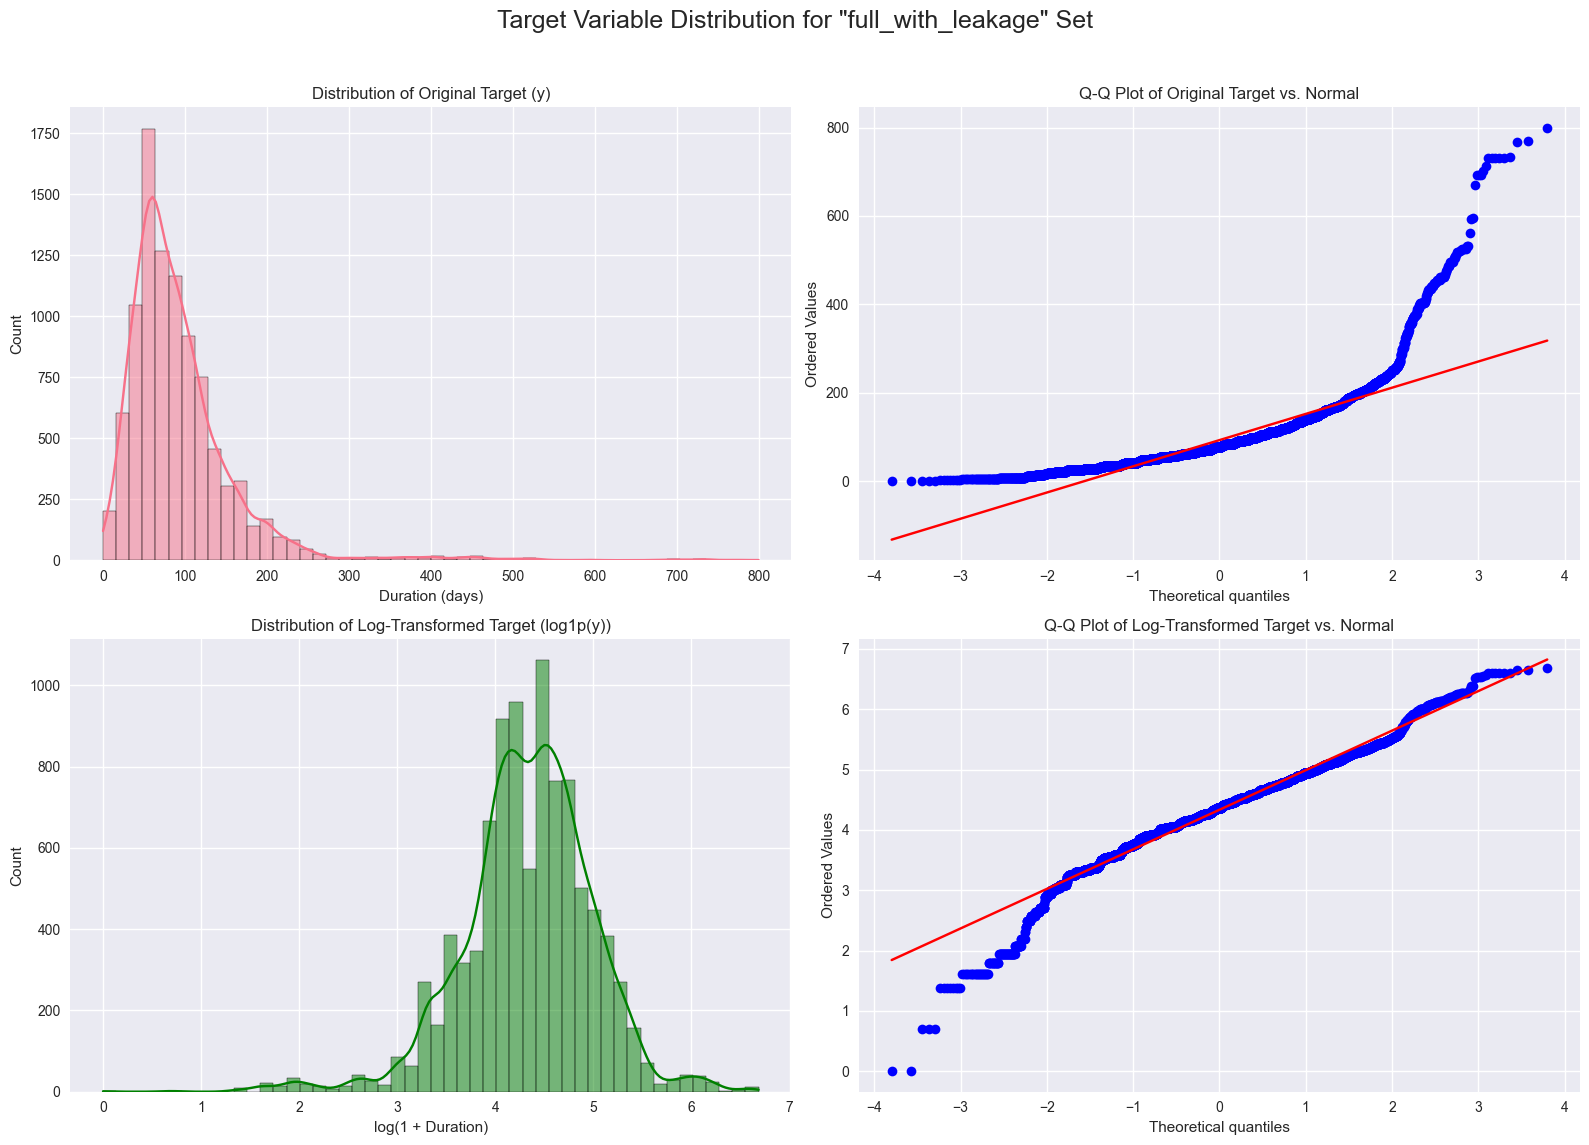


--- Baseline Model Performance ---
This shows the error if we just predict a constant value for every case.

If we predict the Mean (92.71 days) for every case:
  - Baseline RMSE: 68.26 days (This should equal the Standard Deviation)
  - Baseline MAE:  44.64 days

If we predict the Median (77.00 days) for every case:
  - Baseline RMSE: 70.04 days
  - Baseline MAE:  42.94 days (The best possible MAE for a constant prediction)

--- Model Performance Tiers (Contextualized Error) ---

Based on a baseline RMSE (Standard Deviation) of 68.26 days:
RMSE Performance Tiers (approximate target values in days):
  - Decent Performance (> 30% improvement):  Target RMSE < 47.78 days
  - Good Performance (> 50% improvement):  Target RMSE < 34.13 days
  - Excellent Performance (> 70% improvement):  Target RMSE < 20.48 days

Based on a baseline MAE (from Median) of 42.94 days:
MAE Performance Tiers (approximate target values in days):
  - Decent Performance (> 30% improvement):  Target MAE < 30.06 days

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

set_name_key = 'full_with_leakage' # full data so it will be used here 
current_X_S = all_model_inputs[set_name_key]['X']
current_y_s = all_model_inputs[set_name_key]['y']
current_num_for_trainer_S = all_model_inputs[set_name_key]['numerical_for_trainer']
current_cat_for_trainer_S = all_model_inputs[set_name_key]['categorical_for_trainer']

# log transformation of the target variable
y_S_log_current = np.log1p(current_y_s)

# --- 1. Calculate and Print Statistics ---
stats_original = current_y_s.describe()
stats_original['skewness'] = current_y_s.skew()
stats_original['kurtosis'] = current_y_s.kurt()

stats_log = pd.Series(y_S_log_current).describe()
stats_log['skewness'] = pd.Series(y_S_log_current).skew()
stats_log['kurtosis'] = pd.Series(y_S_log_current).kurt()

stats_df = pd.DataFrame({
    'Original Target': stats_original,
    'Log-Transformed Target': stats_log
}).round(3)

print("--- Descriptive Statistics of Target Variable ---")
print(stats_df)

# --- 2. Create Distribution Plots ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Target Variable Distribution for "{set_name_key}" Set', fontsize=18)

# Original Data
sns.histplot(current_y_s, kde=True, ax=axes[0, 0], bins=50)
axes[0, 0].set_title('Distribution of Original Target (y)')
axes[0, 0].set_xlabel('Duration (days)')
stats.probplot(current_y_s, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Original Target vs. Normal')

# Log-Transformed Data
sns.histplot(y_S_log_current, kde=True, ax=axes[1, 0], bins=50, color='g')
axes[1, 0].set_title('Distribution of Log-Transformed Target (log1p(y))')
axes[1, 0].set_xlabel('log(1 + Duration)')
stats.probplot(y_S_log_current, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Log-Transformed Target vs. Normal')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# --- 3. Calculate and Print Baseline Model Performance ---
print("\n--- Baseline Model Performance ---")
print("This shows the error if we just predict a constant value for every case.")

# Baseline 1: Predicting the mean value
mean_prediction = np.full_like(current_y_s, current_y_s.mean())
baseline_rmse_mean = np.sqrt(mean_squared_error(current_y_s, mean_prediction))
baseline_mae_mean = mean_absolute_error(current_y_s, mean_prediction)

print(f"\nIf we predict the Mean ({current_y_s.mean():.2f} days) for every case:")
print(f"  - Baseline RMSE: {baseline_rmse_mean:.2f} days (This should equal the Standard Deviation)")
print(f"  - Baseline MAE:  {baseline_mae_mean:.2f} days")

# Baseline 2: Predicting the median value
median_prediction = np.full_like(current_y_s, current_y_s.median())
baseline_rmse_median = np.sqrt(mean_squared_error(current_y_s, median_prediction))
baseline_mae_median = mean_absolute_error(current_y_s, median_prediction)

print(f"\nIf we predict the Median ({current_y_s.median():.2f} days) for every case:")
print(f"  - Baseline RMSE: {baseline_rmse_median:.2f} days")
print(f"  - Baseline MAE:  {baseline_mae_median:.2f} days (The best possible MAE for a constant prediction)")

# --- 4. Model Performance Expectations ---
print("\n" + "="*50)
print("--- Model Performance Tiers (Contextualized Error) ---")

# Define performance tiers based on percentage improvement
tiers = {
    "Decent Performance": 0.30,  # 30% improvement over baseline
    "Good Performance": 0.50,    # 50% improvement over baseline
    "Excellent Performance": 0.70 # 70% improvement over baseline
}

# RMSE Tiers
print(f"\nBased on a baseline RMSE (Standard Deviation) of {baseline_rmse_mean:.2f} days:")
print("RMSE Performance Tiers (approximate target values in days):")
for tier, improvement_pct in tiers.items():
    target_rmse = baseline_rmse_mean * (1 - improvement_pct)
    print(f"  - {tier} (> {improvement_pct:.0%} improvement):  Target RMSE < {target_rmse:.2f} days")

# MAE Tiers
print(f"\nBased on a baseline MAE (from Median) of {baseline_mae_median:.2f} days:")
print("MAE Performance Tiers (approximate target values in days):")
for tier, improvement_pct in tiers.items():
    target_mae = baseline_mae_median * (1 - improvement_pct)
    print(f"  - {tier} (> {improvement_pct:.0%} improvement):  Target MAE < {target_mae:.2f} days")

print("\nA trained model's final error metrics should be compared against these tiers.")

As written above we will be aiming into these performances, but we will addiotionally be carefull about overfitting and other problems that can arise during the training process. There is also case of using log transformation of the target variable, which can help with skewed distributions. This will be done as part of the model training process.

PREPARING FEATURE SETS FOR MODELING
basic: 14 features prepared
leakage_controlled: 39 features prepared
full_with_leakage: 43 features prepared

DEFINING HYPERPARAMETER SEARCH SPACES
Optuna search space defined
Random search space defined (constrained)

STARTING XGBOOST MODEL TRAINING

RUNNING SCENARIOS FOR FEATURE SET: BASIC
Features: 14

--- SCENARIO 1: Baseline_basic ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_basic_baseline_v1
Model directory: ../models\scdb_duration_basic_baseline_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 7 numerical and 7 categorical features
Fitting preprocessor...
Preprocessing complete: 27 features

Training fina

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 40.8406
Optuna study saved: ../models\scdb_duration_basic_optuna_v1\scdb_duration_basic_optuna_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_basic_optuna_v1\scdb_duration_basic_optuna_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 37.4994
  Fold 2/5 - RMSE: 40.5251
  Fold 3/5 - RMSE: 42.9296
  Fold 4/5 - RMSE: 42.8097
  Fold 5/5 - RMSE: 40.4572
Advanced CV RMSE: 40.84 ± 1.98
Average best iteration: 393

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 487
  learning_rate: 0.030082712644428005
  max_depth: 10
  subsample: 0.95
  colsample_bytree: 0.6000000000000001
  gamma: 0.0189135369474209
  min_child_weight: 6
  reg_lambda: 7.51700043906161
  reg_alpha: 0.19684582874788162
  early_stopping_ro

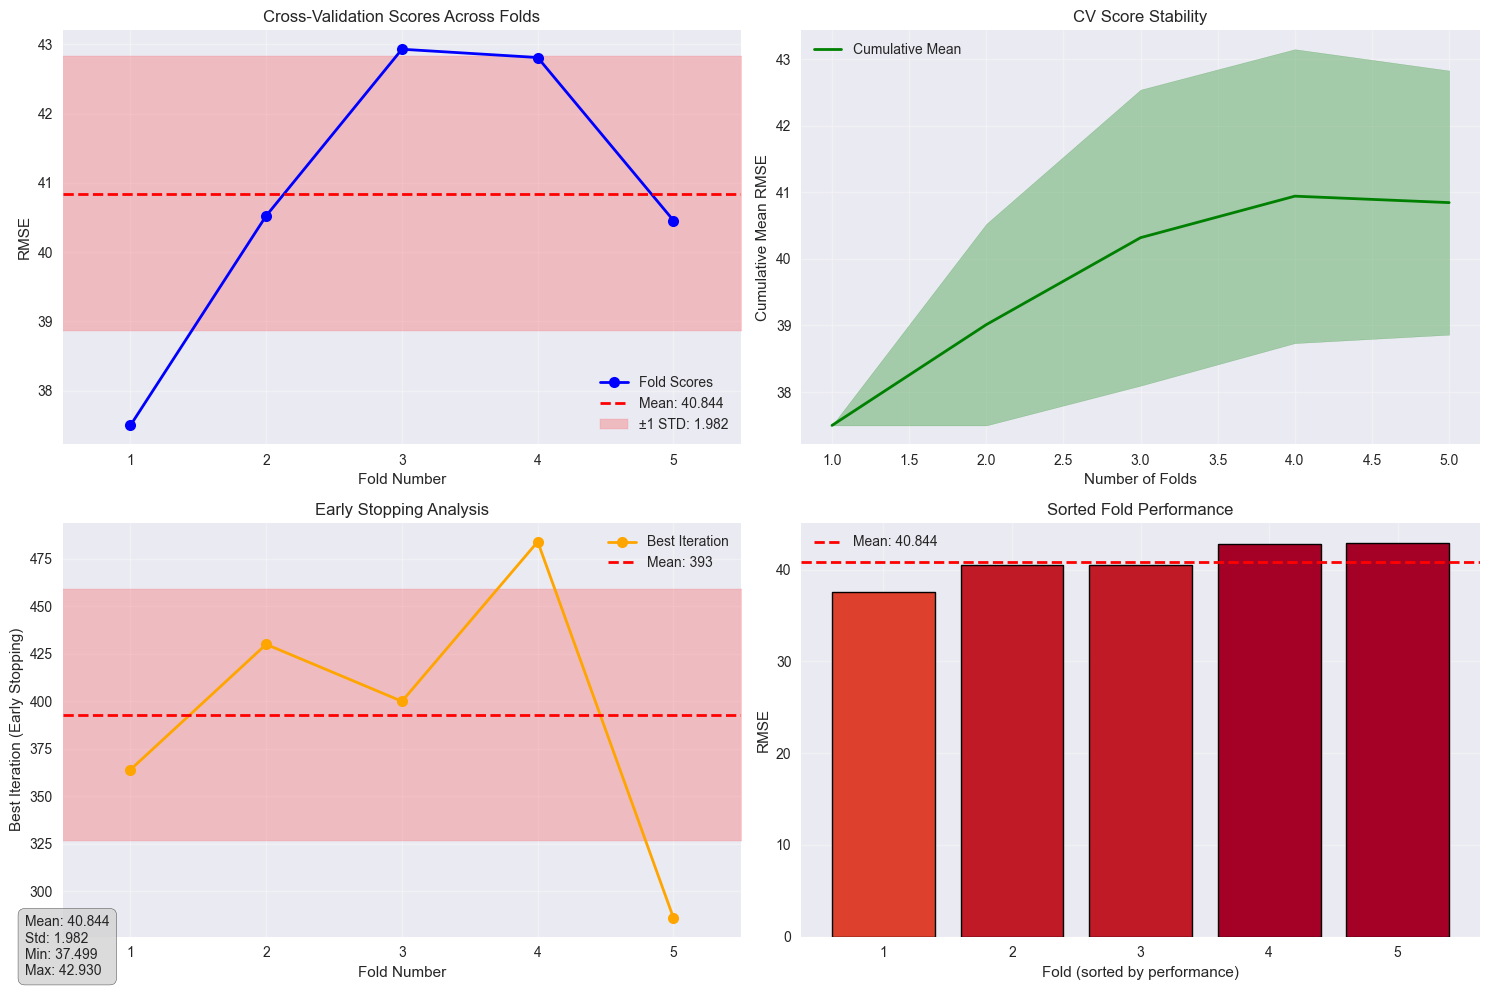

Creating training curve plots...


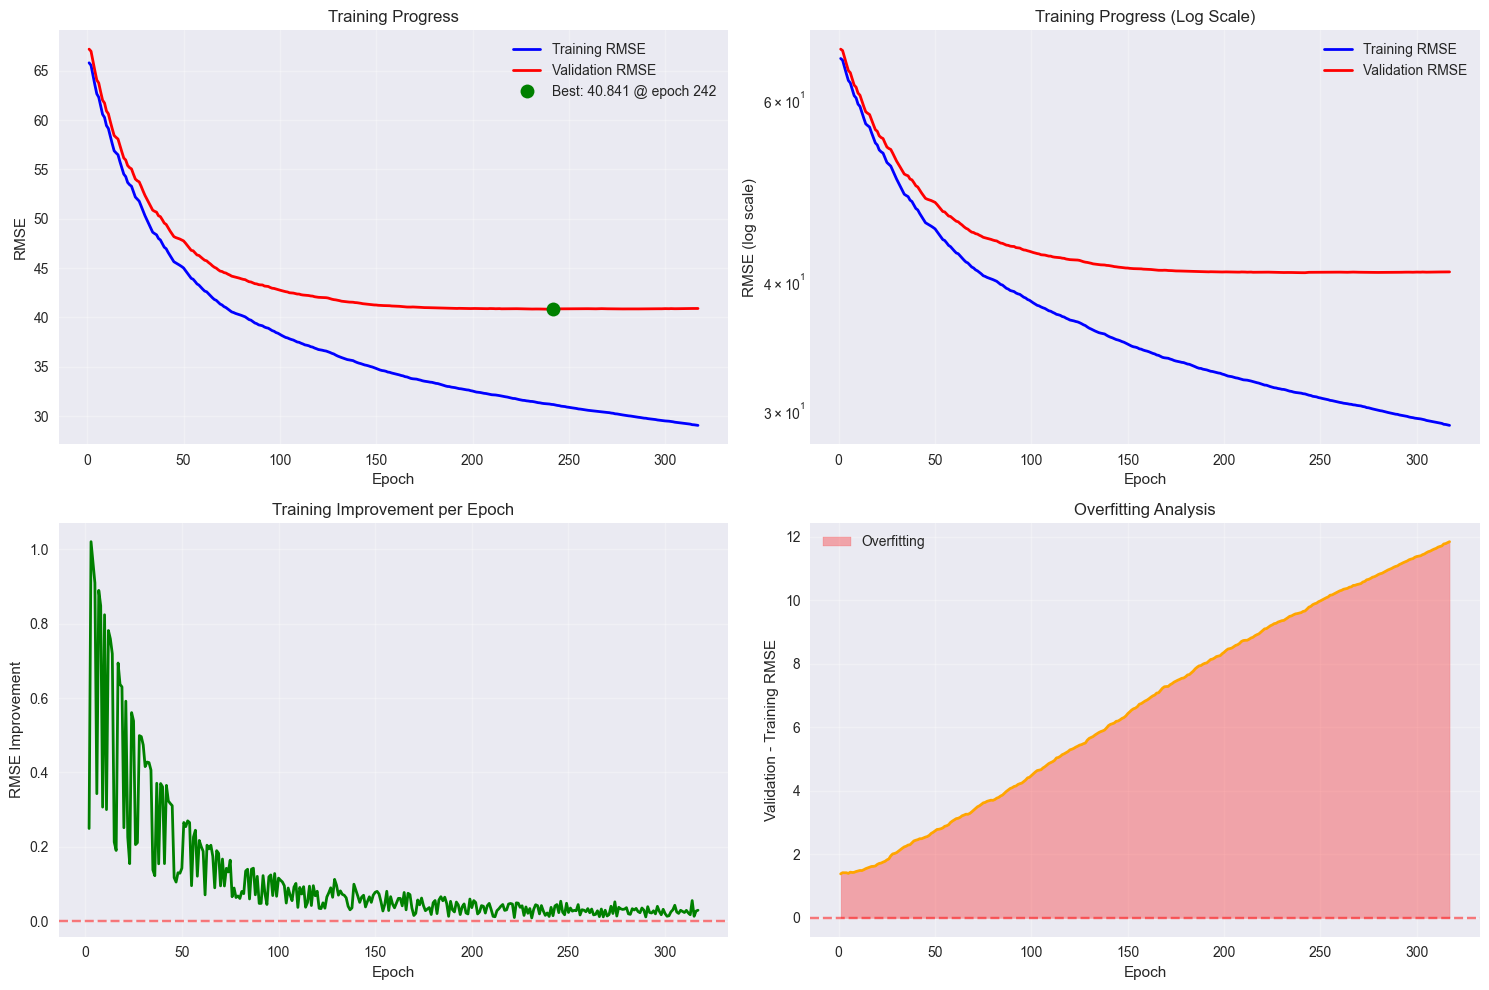


Training completed successfully!
Total time: 270.3s
Final test RMSE: 42.39 days
Advanced CV RMSE: 40.84 ± 1.98 days
Optuna optimization completed in 4.6m
Test RMSE: 42.39 days

LOG-TRANSFORMED TARGET EXPERIMENT

--- SCENARIO 4: LogTarget_basic ---
Purpose: Handle skewed target distribution with log transformation
Original target - Mean: 92.7, Std: 68.3
Log target - Mean: 4.33, Std: 0.67
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_basic_logtarget_v1
Model directory: ../models\scdb_duration_basic_logtarget_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 7 numerical and 7 categorical features
Fitting preprocessor...
Preprocessing complete: 27 features
Starting Optuna optimization with 100 trials (max 1200s)...

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 0.4953
Optuna study saved: ../models\scdb_duration_basic_logtarget_v1\scdb_duration_basic_logtarget_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_basic_logtarget_v1\scdb_duration_basic_logtarget_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 0.5053
  Fold 2/5 - RMSE: 0.4882
  Fold 3/5 - RMSE: 0.5215
  Fold 4/5 - RMSE: 0.5052
  Fold 5/5 - RMSE: 0.4664
Advanced CV RMSE: 0.50 ± 0.02
Average best iteration: 176

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1887
  learning_rate: 0.052077597035460936
  max_depth: 9
  subsample: 0.9
  colsample_bytree: 0.65
  gamma: 0.023360256900120675
  min_child_weight: 5
  reg_lambda: 0.18211975790692578
  reg_alpha: 0.011812085138845444
  early_stopping_rounds

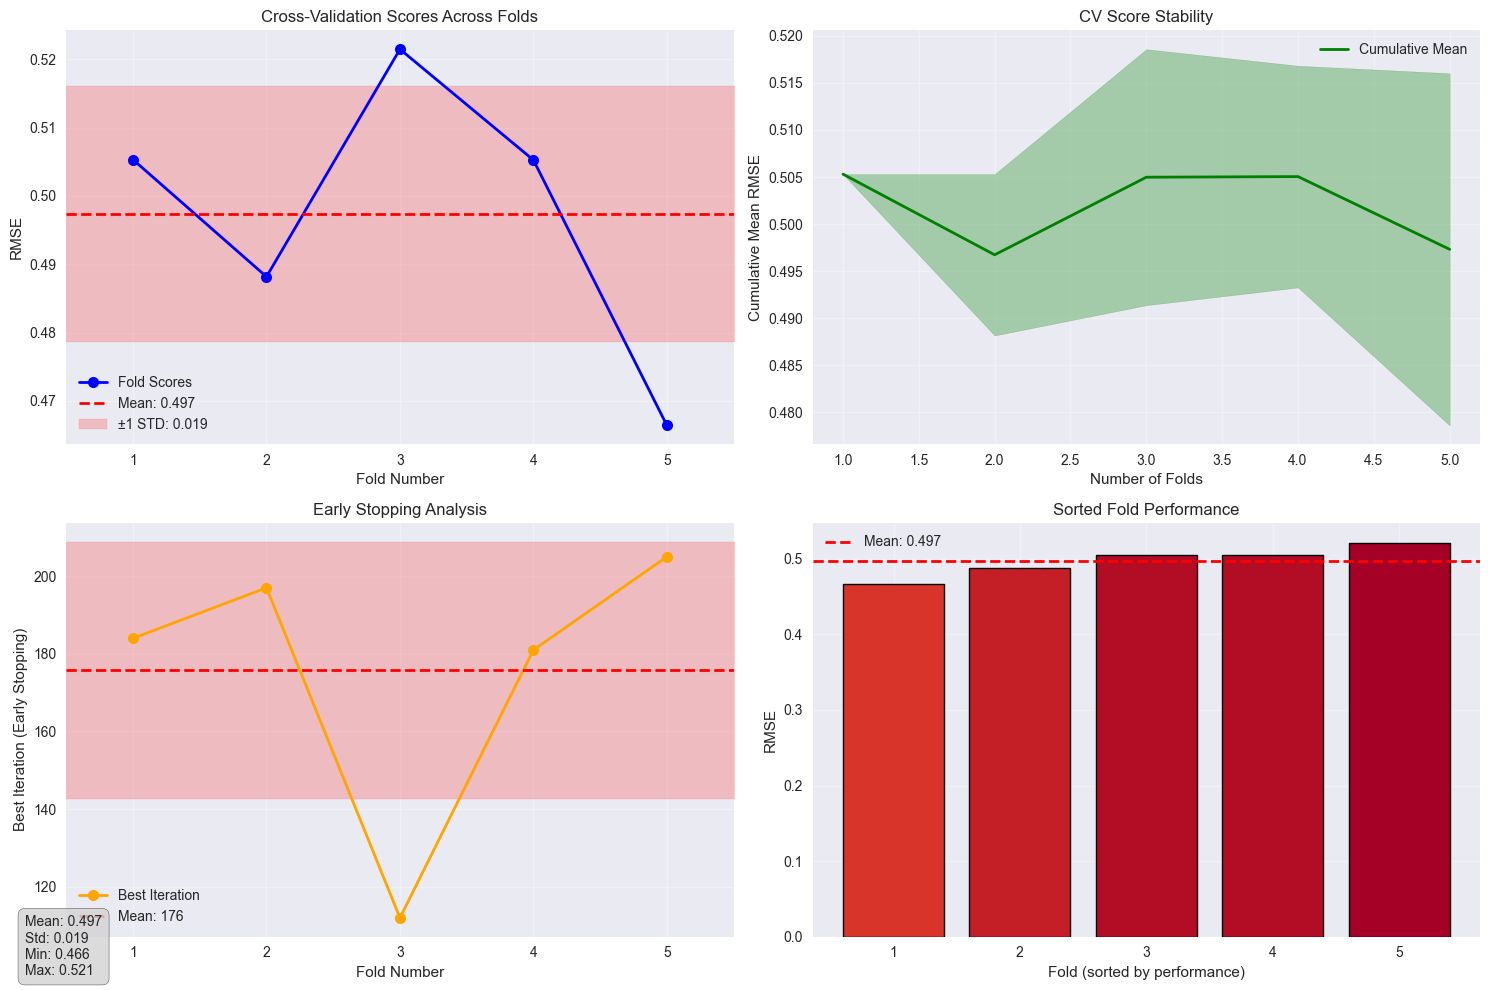

Creating training curve plots...


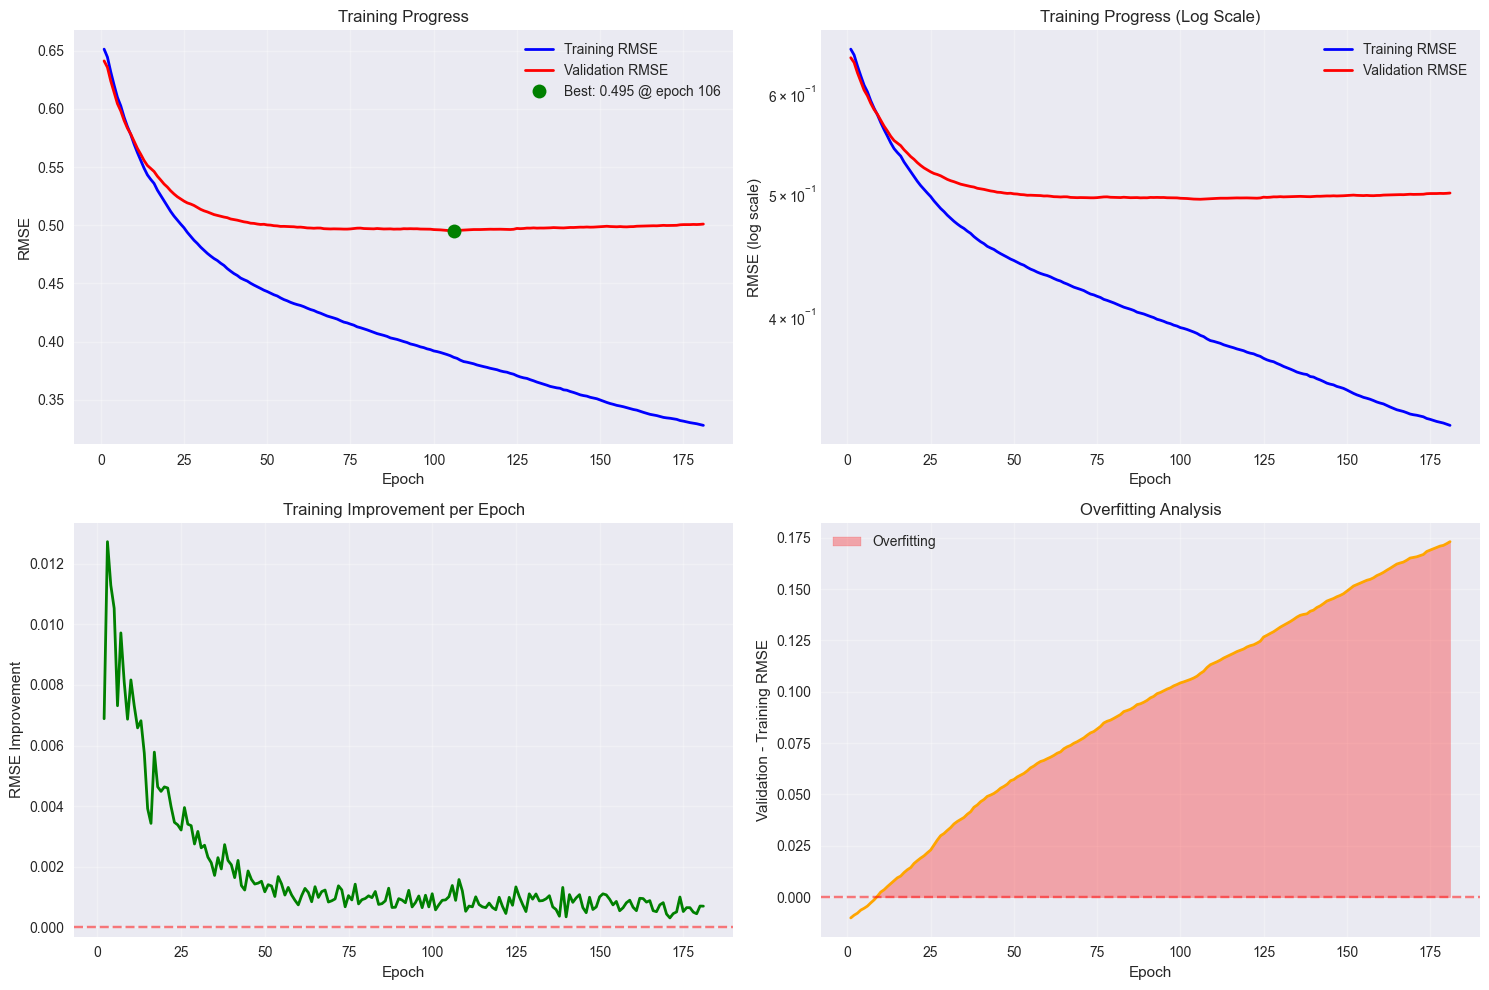


Training completed successfully!
Total time: 181.1s
Final test RMSE: 0.50 days
Advanced CV RMSE: 0.50 ± 0.02 days
Training completed in 185.0s
Test RMSE (original scale): 44.85 days

RUNNING SCENARIOS FOR FEATURE SET: LEAKAGE_CONTROLLED
Features: 39

--- SCENARIO 1: Baseline_leakage_controlled ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_leakage_controlled_baseline_v1
Model directory: ../models\scdb_duration_leakage_controlled_baseline_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 25 numerical and 14 categorical features
Fitting preprocessor...
Preprocessing complete: 82 features

Training final model with parameters:
  objective: reg:squarede

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 39.7315
Optuna study saved: ../models\scdb_duration_leakage_controlled_optuna_v1\scdb_duration_leakage_controlled_optuna_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_leakage_controlled_optuna_v1\scdb_duration_leakage_controlled_optuna_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 37.0980
  Fold 2/5 - RMSE: 39.6828
  Fold 3/5 - RMSE: 41.3036
  Fold 4/5 - RMSE: 42.2502
  Fold 5/5 - RMSE: 39.6787
Advanced CV RMSE: 40.00 ± 1.75
Average best iteration: 571

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 2387
  learning_rate: 0.018447895504432727
  max_depth: 10
  subsample: 0.8500000000000001
  colsample_bytree: 0.7000000000000001
  gamma: 0.02886016147045617
  min_child_weight: 5
  reg_lambda: 1

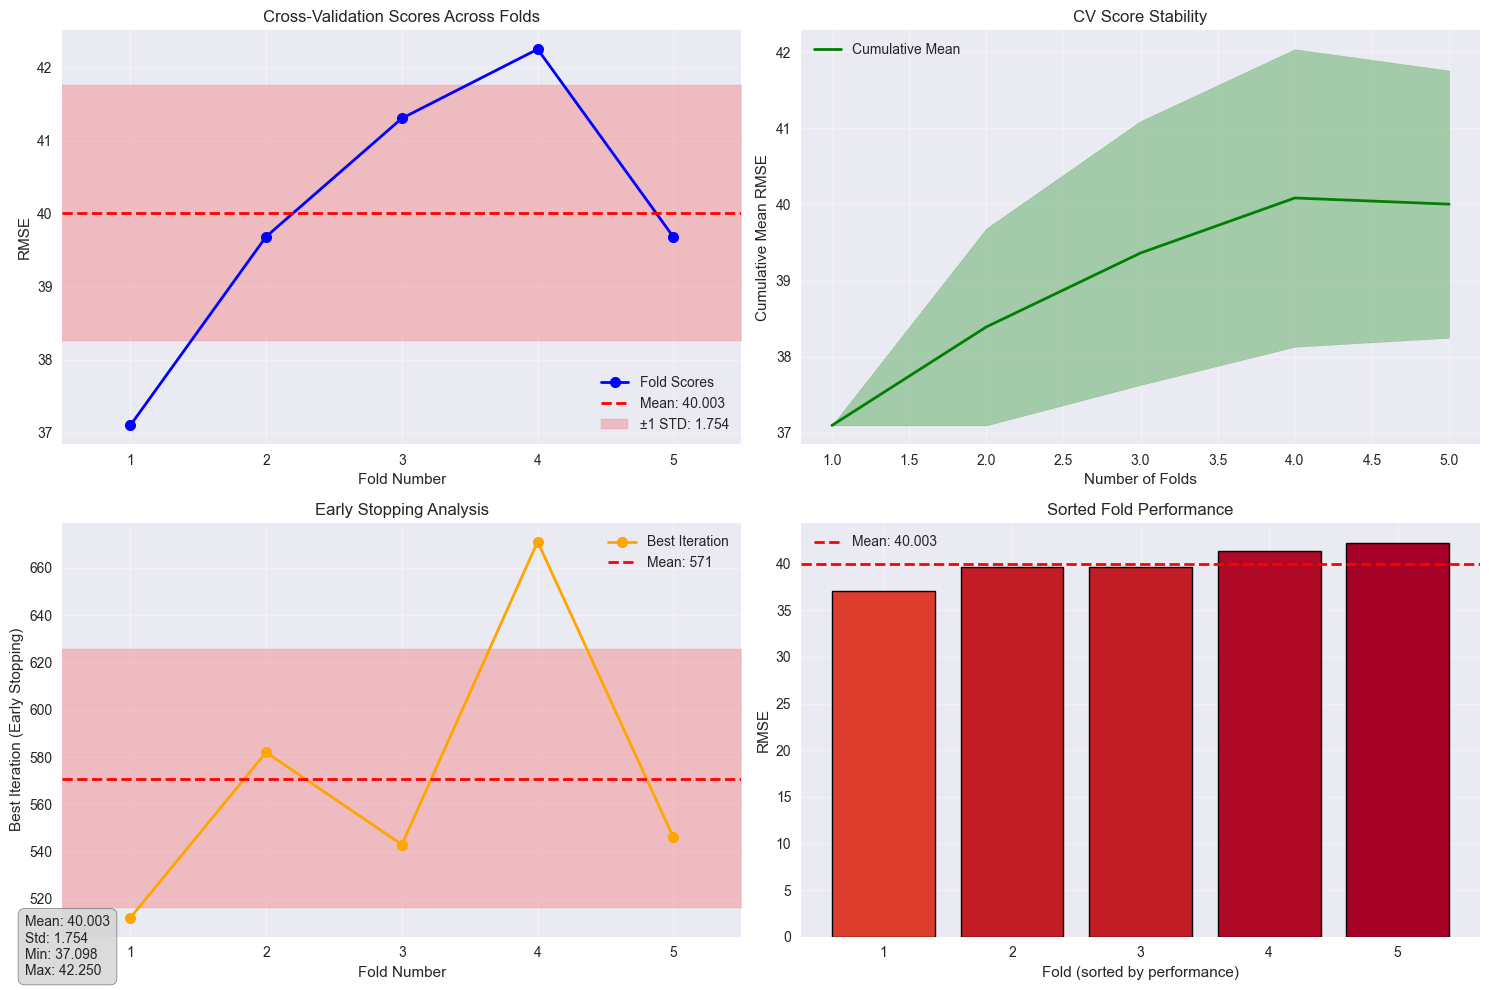

Creating training curve plots...


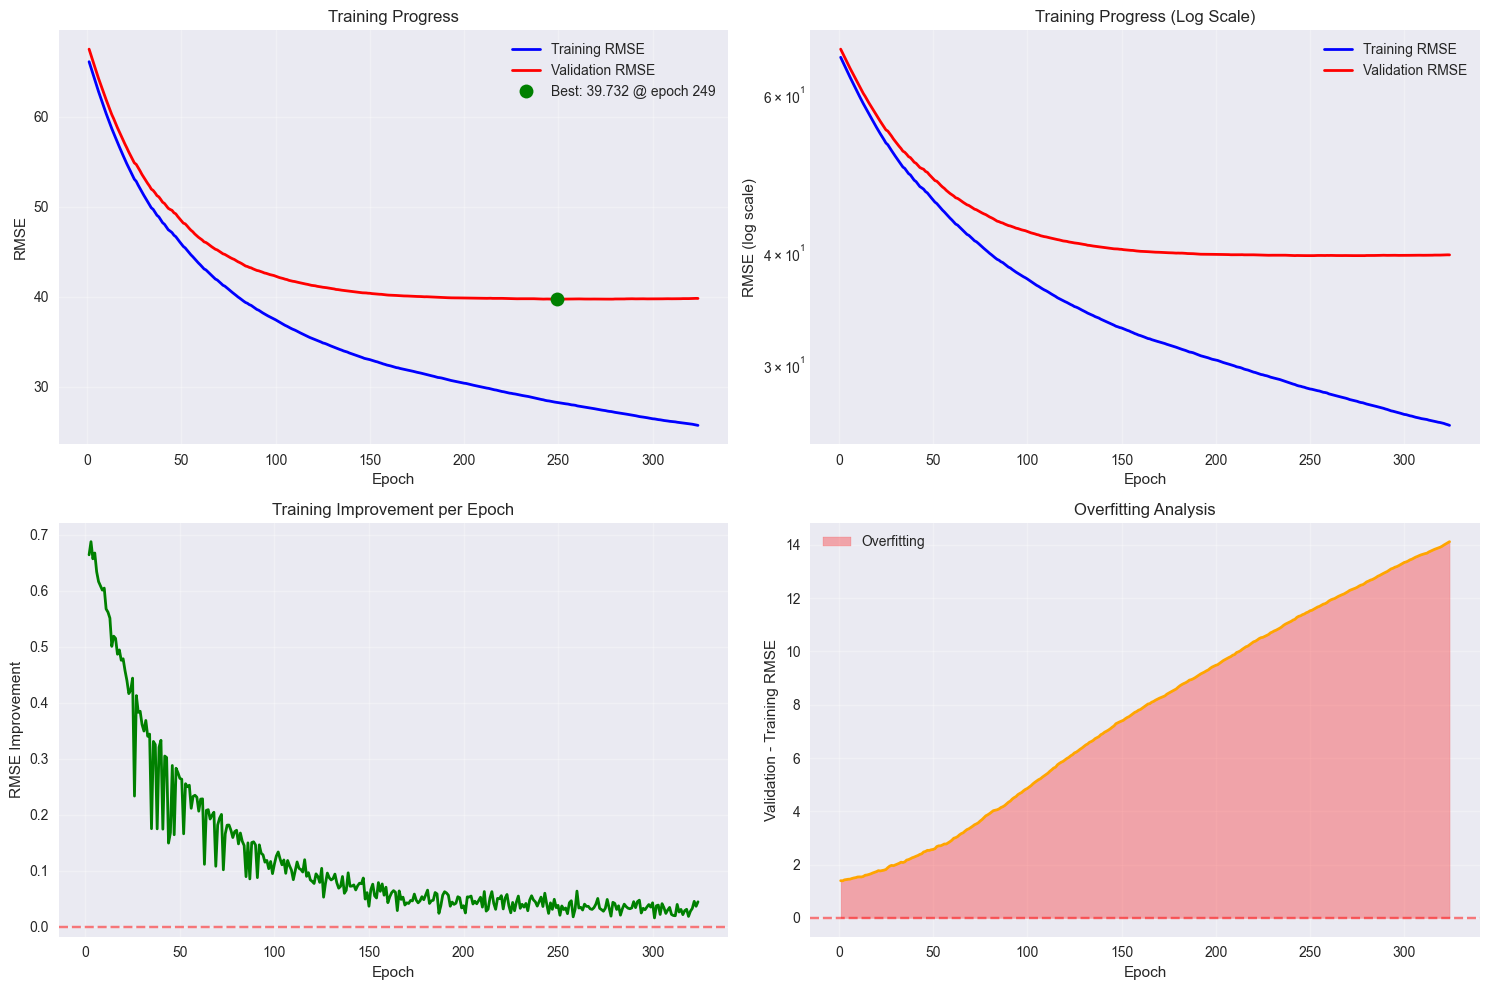


Training completed successfully!
Total time: 315.4s
Final test RMSE: 41.05 days
Advanced CV RMSE: 40.00 ± 1.75 days
Optuna optimization completed in 5.3m
Test RMSE: 41.05 days

LOG-TRANSFORMED TARGET EXPERIMENT

--- SCENARIO 4: LogTarget_leakage_controlled ---
Purpose: Handle skewed target distribution with log transformation
Original target - Mean: 92.7, Std: 68.3
Log target - Mean: 4.33, Std: 0.67
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_leakage_controlled_logtarget_v1
Model directory: ../models\scdb_duration_leakage_controlled_logtarget_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 25 numerical and 14 categorical features
Fitting preprocessor...
Preprocessing complete: 82 features
Starting Optuna op

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 0.4820
Optuna study saved: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_leakage_controlled_logtarget_v1\scdb_duration_leakage_controlled_logtarget_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 0.4900
  Fold 2/5 - RMSE: 0.4814
  Fold 3/5 - RMSE: 0.5019
  Fold 4/5 - RMSE: 0.4999
  Fold 5/5 - RMSE: 0.4603
Advanced CV RMSE: 0.49 ± 0.02
Average best iteration: 1075

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1419
  learning_rate: 0.00952368869854281
  max_depth: 10
  subsample: 0.75
  colsample_bytree: 0.5
  gamma: 0.1605533042881985
  min_child_weight: 9
  reg_lambda: 0.5345386719568463
  reg_a

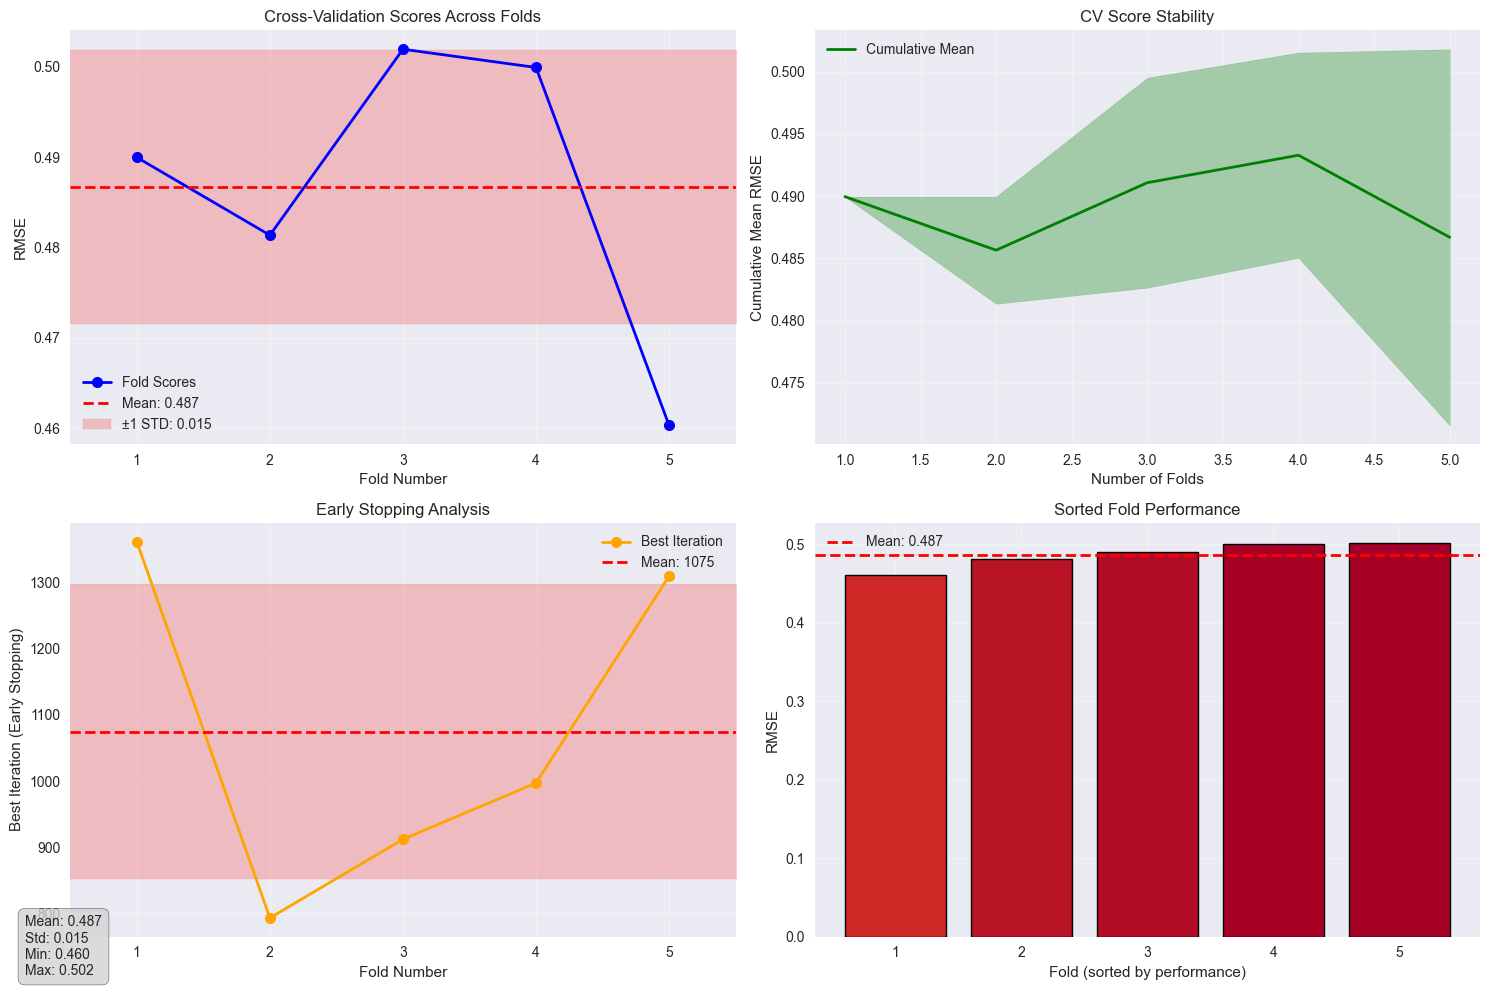

Creating training curve plots...


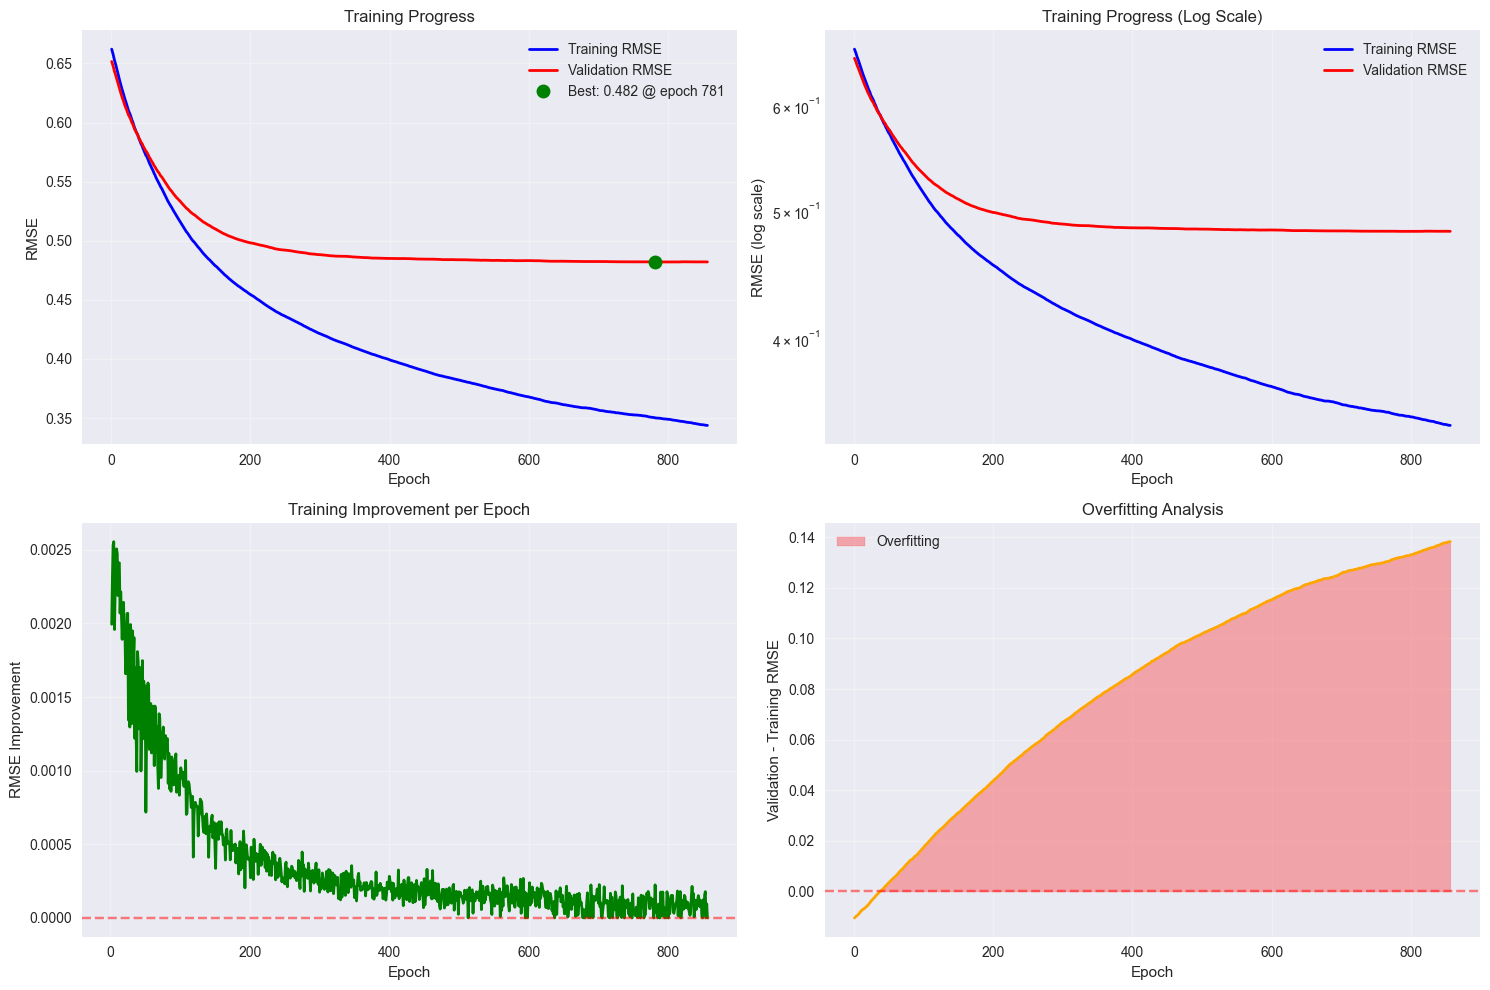


Training completed successfully!
Total time: 422.8s
Final test RMSE: 0.49 days
Advanced CV RMSE: 0.49 ± 0.02 days
Training completed in 426.6s
Test RMSE (original scale): 43.64 days

RUNNING SCENARIOS FOR FEATURE SET: FULL_WITH_LEAKAGE
Features: 43

--- SCENARIO 1: Baseline_full_with_leakage ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_full_with_leakage_baseline_v1
Model directory: ../models\scdb_duration_full_with_leakage_baseline_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 29 numerical and 14 categorical features
Fitting preprocessor...
Preprocessing complete: 86 features

Training final model with parameters:
  objective: reg:squarederror

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 12.2721
Optuna study saved: ../models\scdb_duration_full_with_leakage_optuna_v1\scdb_duration_full_with_leakage_optuna_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_full_with_leakage_optuna_v1\scdb_duration_full_with_leakage_optuna_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 10.0510
  Fold 2/5 - RMSE: 10.7458
  Fold 3/5 - RMSE: 16.8788
  Fold 4/5 - RMSE: 17.6068
  Fold 5/5 - RMSE: 15.0163
Advanced CV RMSE: 14.06 ± 3.11
Average best iteration: 178

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1463
  learning_rate: 0.03893223873456307
  max_depth: 10
  subsample: 0.6000000000000001
  colsample_bytree: 0.95
  gamma: 0.018656655026734498
  min_child_weight: 6
  reg_lambda: 0.6669898800723497


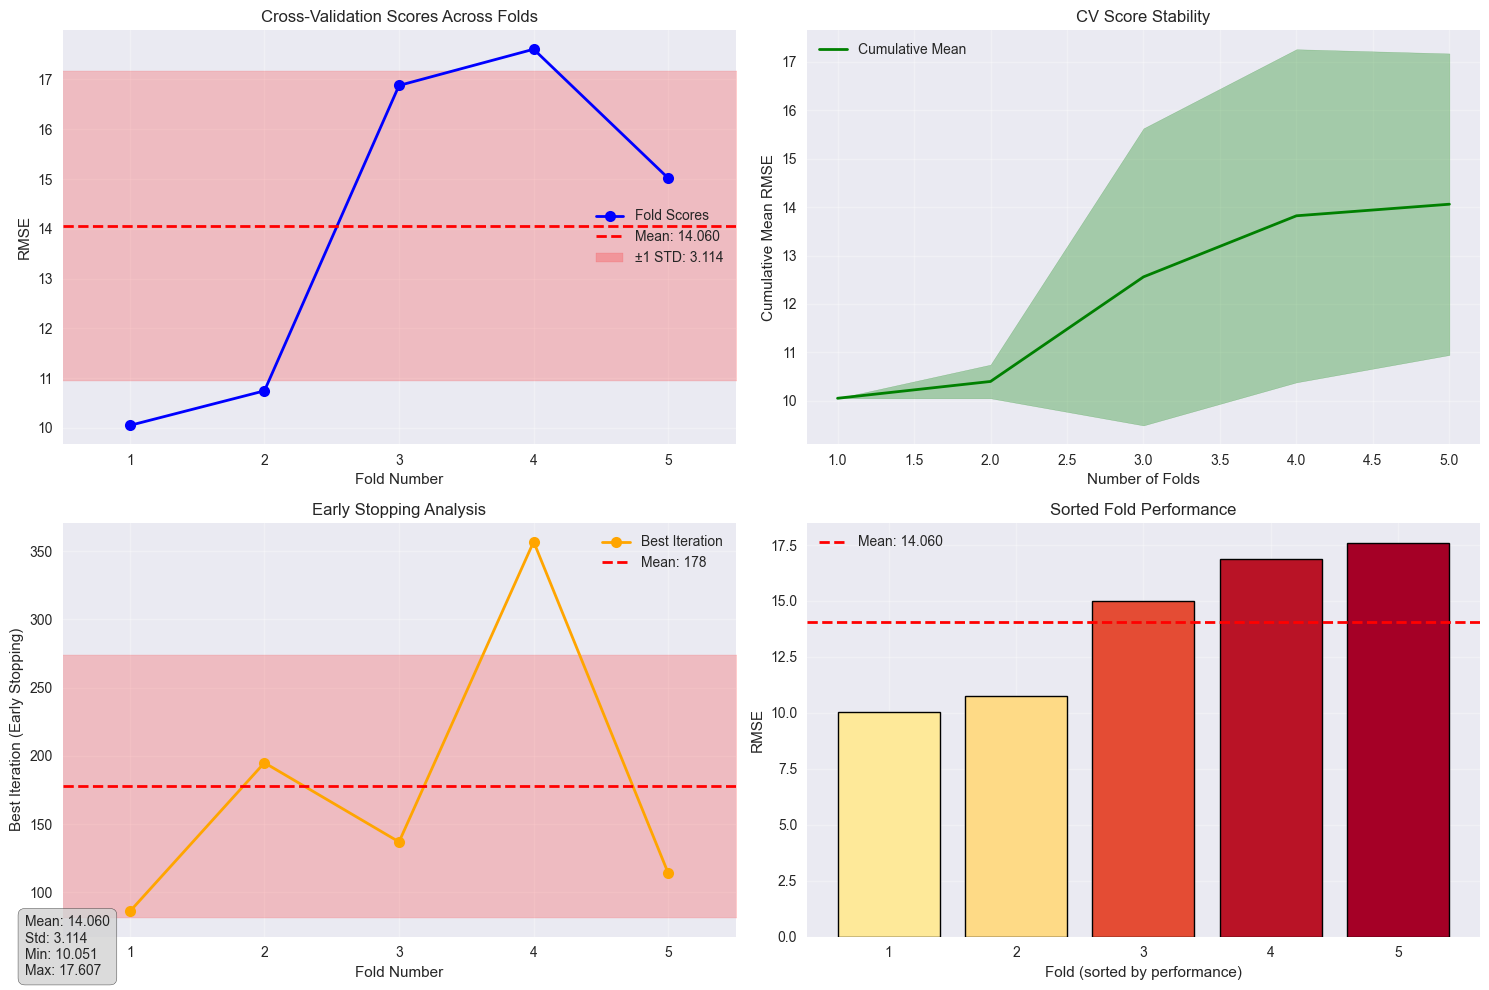

Creating training curve plots...


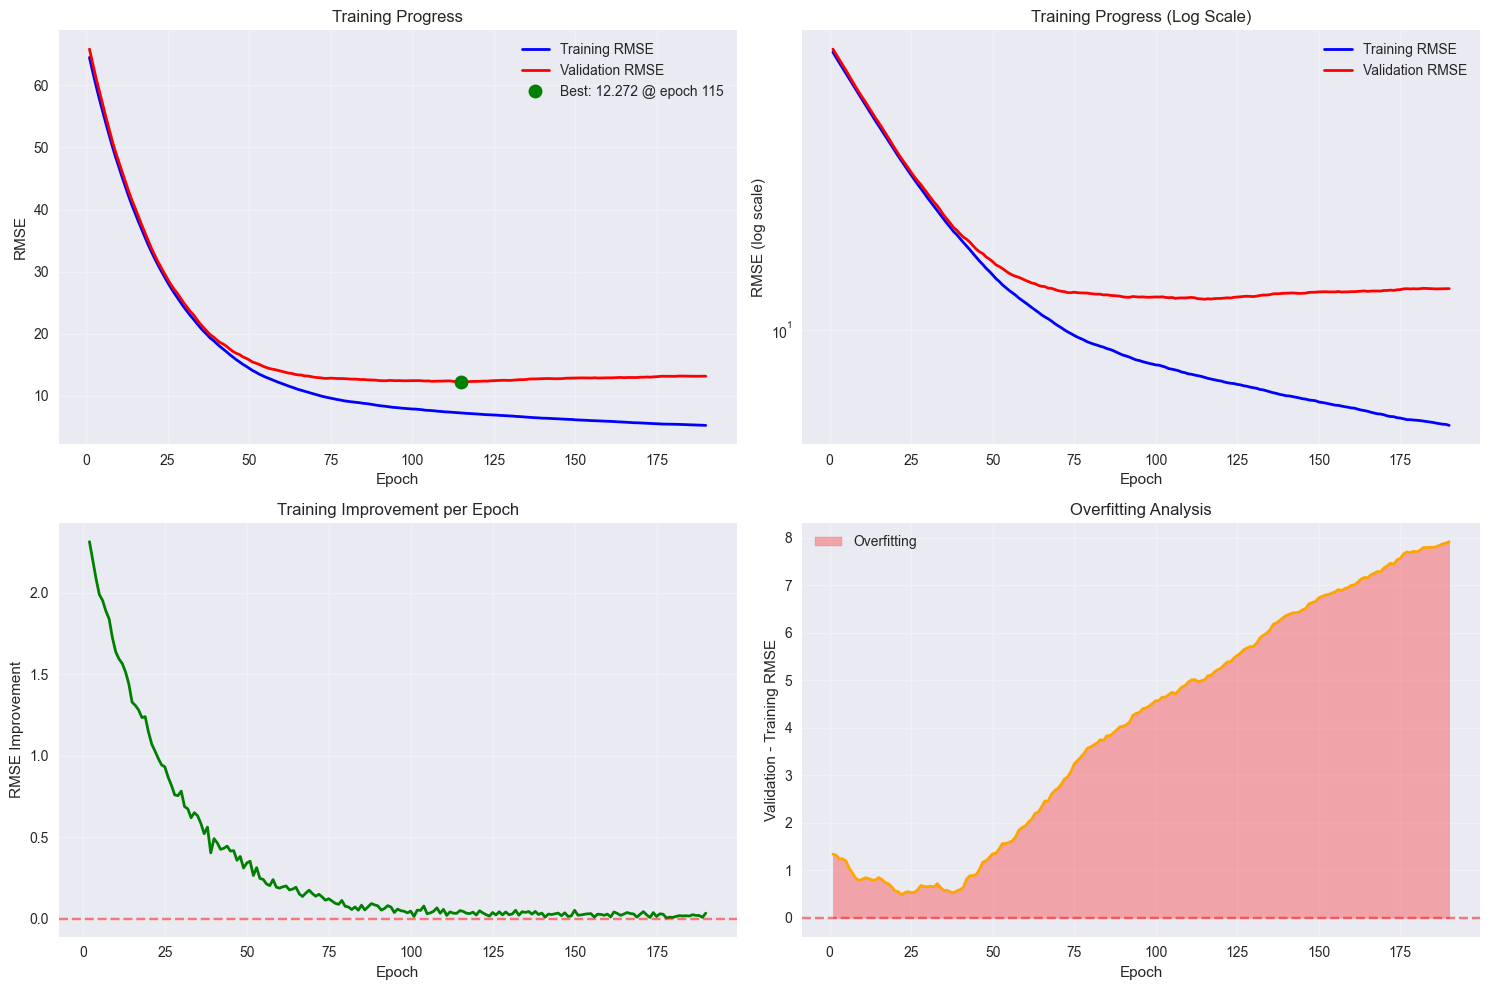


Training completed successfully!
Total time: 217.2s
Final test RMSE: 17.71 days
Advanced CV RMSE: 14.06 ± 3.11 days
Optuna optimization completed in 3.7m
Test RMSE: 17.71 days

LOG-TRANSFORMED TARGET EXPERIMENT

--- SCENARIO 4: LogTarget_full_with_leakage ---
Purpose: Handle skewed target distribution with log transformation
Original target - Mean: 92.7, Std: 68.3
Log target - Mean: 4.33, Std: 0.67
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_full_with_leakage_logtarget_v1
Model directory: ../models\scdb_duration_full_with_leakage_logtarget_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 29 numerical and 14 categorical features
Fitting preprocessor...
Preprocessing complete: 86 features
Starting Optuna optim

  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 0.0769
Optuna study saved: ../models\scdb_duration_full_with_leakage_logtarget_v1\scdb_duration_full_with_leakage_logtarget_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_full_with_leakage_logtarget_v1\scdb_duration_full_with_leakage_logtarget_v1_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 0.0906
  Fold 2/5 - RMSE: 0.0726
  Fold 3/5 - RMSE: 0.1042
  Fold 4/5 - RMSE: 0.1034
  Fold 5/5 - RMSE: 0.0664
Advanced CV RMSE: 0.09 ± 0.02
Average best iteration: 555

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1804
  learning_rate: 0.024970379481807036
  max_depth: 8
  subsample: 0.8
  colsample_bytree: 0.8500000000000001
  gamma: 0.010827939238017142
  min_child_weight: 5
  reg_lambda: 0.3523414197551

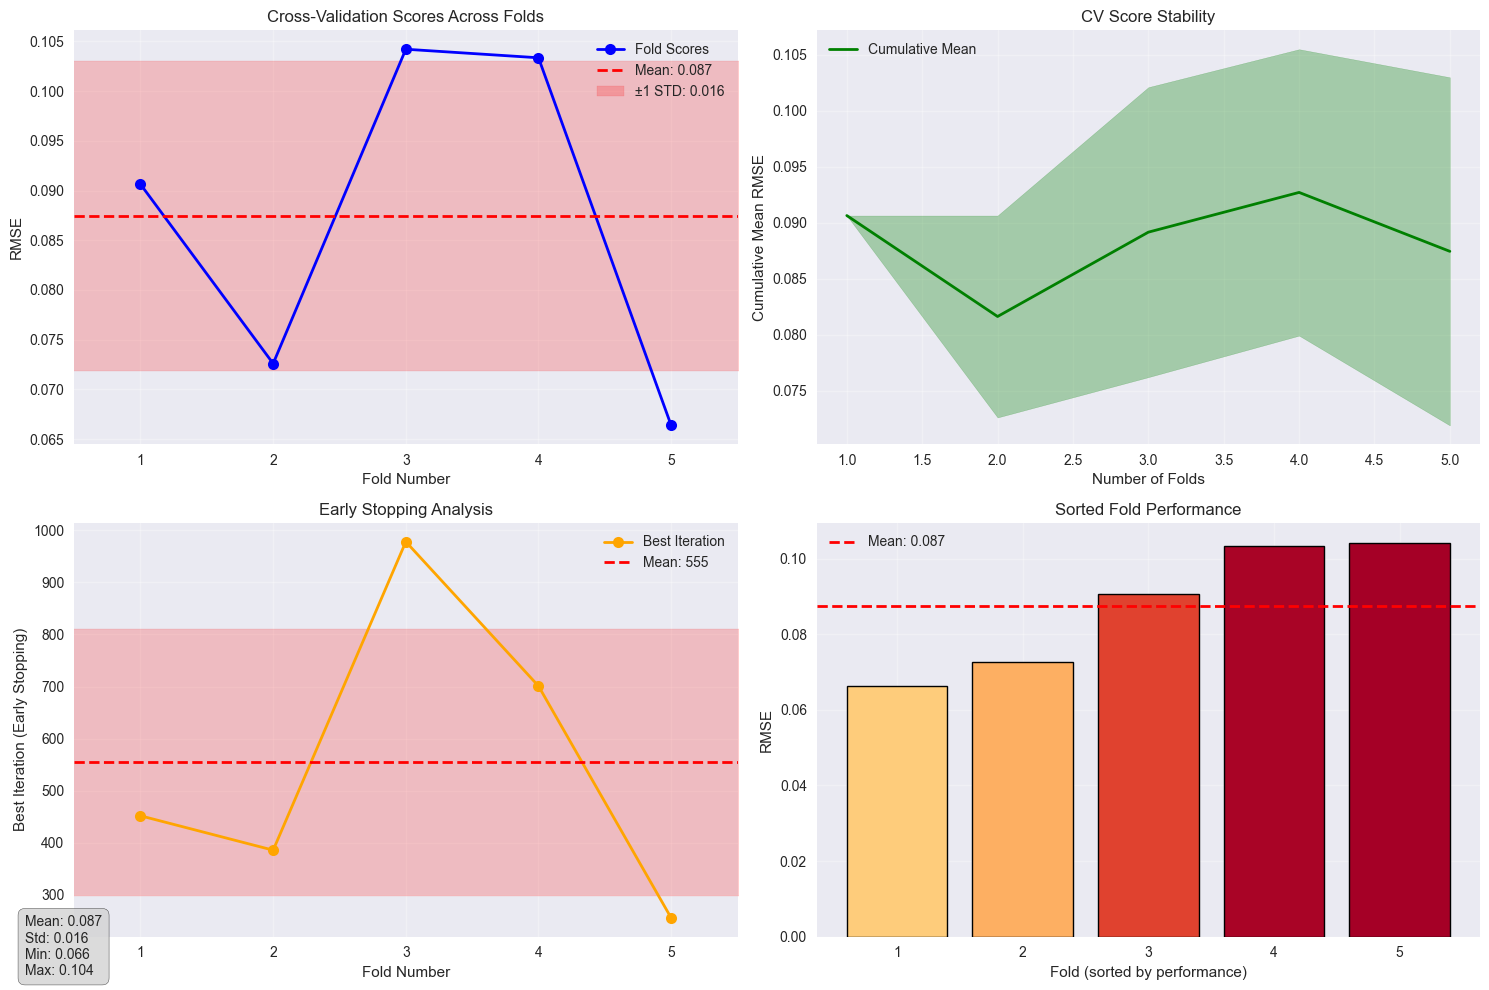

Creating training curve plots...


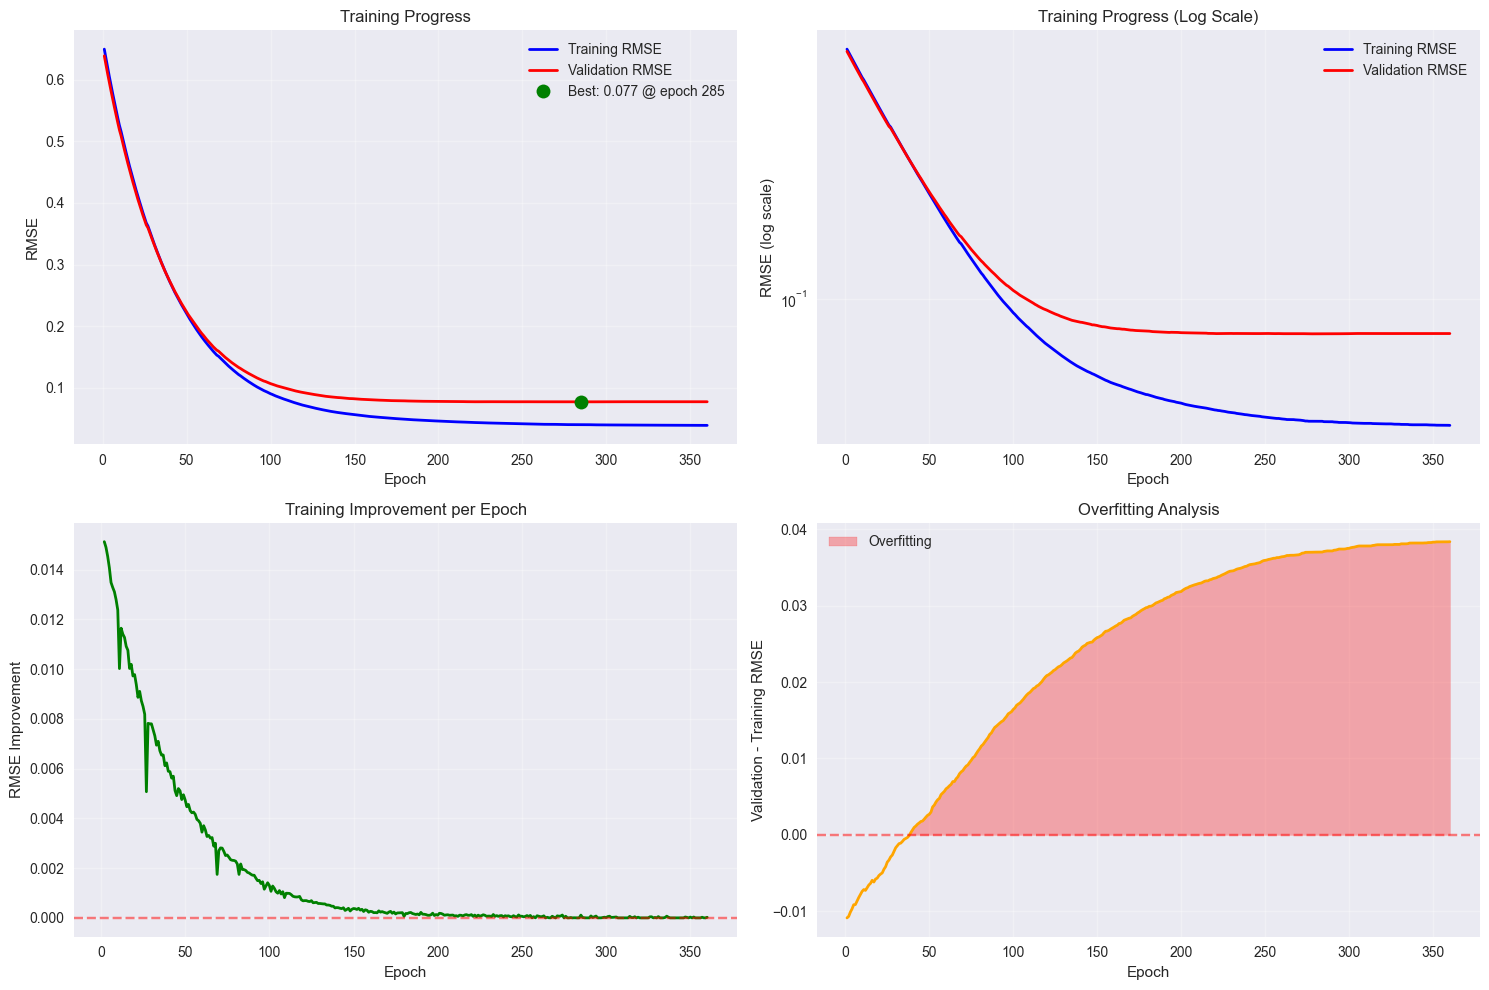


Training completed successfully!
Total time: 273.6s
Final test RMSE: 0.12 days
Advanced CV RMSE: 0.09 ± 0.02 days
Training completed in 277.8s
Test RMSE (original scale): 17.91 days

COMPILING COMPREHENSIVE RESULTS FROM SAVED MODEL METADATA
1. Searching for trained models in '../models' directory...
Found 9 models.

2. Generating comprehensive results table...

--- GENERATED COMPREHENSIVE RESULTS TABLE ---
                                      Model Name  Train Samples  Validate Samples  Test Samples Tree Method  Processed Features  Training Duration (s)  Train RMSE  Validation RMSE  Test RMSE  Train MAE  Validation MAE   Test MAE  Train R²  Validation R²   Test R²  n_estimators  learning_rate  max_depth  subsample  colsample_bytree  reg_alpha  reg_lambda                   Timestamp
0   scdb_duration_full_with_leakage_logtarget_v1           6196              1431          1907    gpu_hist                  86             273.566089    0.039845         0.076936   0.124014   0.016658    

In [15]:
# =============================================================================
# SECTION 1: SETUP AND IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import os
import re
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# SECTION 2: FEATURE SET PREPARATION
# =============================================================================
print("="*80)
print("PREPARING FEATURE SETS FOR MODELING")
print("="*80)

# Prepare inputs for different feature sets
all_model_inputs = {}
if 'df_cleaned' in locals() and 'y' in locals() and \
   'numerical_features' in locals() and 'binary_features' in locals() and 'categorical_features' in locals() and \
   'basic_features_final' in locals() and 'leakage_controlled_features_final' in locals() and 'full_features_with_leakage_final' in locals():

    feature_sets_to_prepare = {
        "basic": basic_features_final,
        "leakage_controlled": leakage_controlled_features_final,
        "full_with_leakage": full_features_with_leakage_final
    }

    for set_name, selected_features_list in feature_sets_to_prepare.items():
        X_current = df_cleaned[selected_features_list]
        current_numerical = [f for f in numerical_features if f in X_current.columns]
        current_binary = [f for f in binary_features if f in X_current.columns]
        current_categorical = [f for f in categorical_features if f in X_current.columns]

        all_model_inputs[set_name] = {
            'X': X_current,
            'y': y,
            'numerical_for_trainer': current_numerical + current_binary,
            'categorical_for_trainer': current_categorical,
            'feature_list_name': set_name,
            'n_features': len(selected_features_list)
        }
        print(f"{set_name}: {len(selected_features_list)} features prepared")
else:
    print("Error: Prerequisite variables not defined. Please run preprocessing first.")
    all_model_inputs = {}

# =============================================================================
# SECTION 3: HYPERPARAMETER SEARCH SPACES
# =============================================================================
print("\n" + "="*80)
print("DEFINING HYPERPARAMETER SEARCH SPACES")
print("="*80)

# Define Optuna search spaces
optuna_search_space_xgb = {
    'n_estimators': {'type': 'int', 'low': 200, 'high': 2500},
    'learning_rate': {'type': 'float', 'low': 0.005, 'high': 0.1, 'log': True},
    'max_depth': {'type': 'int', 'low': 3, 'high': 10},
    'subsample': {'type': 'float', 'low': 0.4, 'high': 0.95, 'step': 0.05},
    'colsample_bytree': {'type': 'float', 'low': 0.4, 'high': 0.95, 'step': 0.05},
    'gamma': {'type': 'float', 'low': 0.01, 'high': 1, 'log': True},
    'min_child_weight': {'type': 'int', 'low': 5, 'high': 12},
    'reg_lambda': {'type': 'float', 'low': 0.1, 'high': 50.0, 'log': True},
    'reg_alpha': {'type': 'float', 'low': 0.01, 'high': 25.0, 'log': True},
}

# Constrained search space for random search
random_search_space = {
    'n_estimators': {'type': 'int', 'low': 500, 'high': 1500},
    'learning_rate': {'type': 'float', 'low': 0.02, 'high': 0.08},
    'max_depth': {'type': 'int', 'low': 5, 'high': 10},
    'subsample': {'type': 'float', 'low': 0.7, 'high': 0.9},
    'colsample_bytree': {'type': 'float', 'low': 0.7, 'high': 0.9},
}

print("Optuna search space defined")
print("Random search space defined (constrained)")

# Dictionary to store all results
all_scenario_results = {}

# =============================================================================
# SECTION 4: XGBOOST MODEL TRAINING (MULTIPLE SCENARIOS)
# =============================================================================
print("\n" + "="*80)
print("STARTING XGBOOST MODEL TRAINING")
print("="*80)

# Loop through feature sets
for set_name_key, inputs in all_model_inputs.items():
    print(f"\n" + "="*80)
    print(f"RUNNING SCENARIOS FOR FEATURE SET: {set_name_key.upper()}")
    print(f"Features: {inputs['n_features']}")
    print("="*80)

    current_X = inputs['X']
    current_y = inputs['y']
    current_num_for_trainer = inputs['numerical_for_trainer']
    current_cat_for_trainer = inputs['categorical_for_trainer']

    # -------------------------------------------------------------------------
    # SCENARIO 1: BASELINE MODEL
    # -------------------------------------------------------------------------
    scenario_model_name_1 = f'Baseline_{set_name_key}'
    print(f"\n--- SCENARIO 1: {scenario_model_name_1} ---")
    print("Purpose: Establish baseline with default XGBoost parameters")
    
    start_time = time.time()
    results_fs_baseline = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, 
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_baseline',
        early_stopping_rounds=50, 
        create_plots=True, 
        perform_cv=False
    )
    run_time = time.time() - start_time
    
    if results_fs_baseline:
        results_fs_baseline['training_time'] = run_time
        print(f"Training completed in {run_time:.1f}s")
        if results_fs_baseline.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_baseline['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_1] = results_fs_baseline

    # # -------------------------------------------------------------------------
    # # SCENARIO 2: RANDOM SEARCH
    # # -------------------------------------------------------------------------
    # scenario_model_name_2 = f'RandomSearch_{set_name_key}'
    # print(f"\n--- SCENARIO 2: {scenario_model_name_2} ---")
    # print("Purpose: Hyperparameter optimization with RandomizedSearchCV")
    
    # random_search_config = {
    #     'n_iter': 30,  # Reduced iterations for faster execution
    #     'cv': 3        # 3-fold CV
    # }
    
    # start_time = time.time()
    # results_fs_random = trainer.train_model(
    #     X=current_X, y=current_y,
    #     numerical_features=current_num_for_trainer, 
    #     categorical_features=current_cat_for_trainer,
    #     model_name=f'scdb_duration_{set_name_key}_random',
    #     optimization_method='random',
    #     optimization_params=random_search_config,
    #     early_stopping_rounds=50,
    #     create_plots=True,
    #     perform_cv=False
    # )
    # run_time = time.time() - start_time
    
    # if results_fs_random:
    #     results_fs_random['training_time'] = run_time
    #     print(f"Random search completed in {run_time:.1f}s")
    #     if results_fs_random.get('metrics', {}).get('test'):
    #         print(f"Test RMSE: {results_fs_random['metrics']['test']['rmse']:.2f} days")
    # all_scenario_results[scenario_model_name_2] = results_fs_random

    # -------------------------------------------------------------------------
    # SCENARIO 3: OPTUNA OPTIMIZATION
    # -------------------------------------------------------------------------
    scenario_model_name_3 = f'Optuna_{set_name_key}'
    print(f"\n--- SCENARIO 3: {scenario_model_name_3} ---")
    print("Purpose: Advanced hyperparameter optimization with Optuna")
    
    start_time = time.time()
    results_fs_optuna = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, 
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_optuna',
        optimization_method='optuna',
        optimization_params={
            'n_trials': 100, 
            'timeout': 1200, 
            'search_space': optuna_search_space_xgb.copy()
        },
        early_stopping_rounds=75, 
        create_plots=True,
        perform_cv=True, 
        cv_folds=5, 
        advanced_cv=True,
        plot_cv_results=True,
        plot_training_curves=True
    )
    run_time = time.time() - start_time
    
    if results_fs_optuna:
        results_fs_optuna['training_time'] = run_time
        print(f"Optuna optimization completed in {run_time/60:.1f}m")
        if results_fs_optuna.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_optuna['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_3] = results_fs_optuna

# =============================================================================
# SECTION 5: LOG-TRANSFORMED TARGET 
# =============================================================================
    print("\n" + "="*80)
    print("LOG-TRANSFORMED TARGET EXPERIMENT")
    print("="*80)

# Commented out for now
# # # Only run on leakage_controlled feature set -> example of usage for one set
# # if 'leakage_controlled' in all_model_inputs:
#     scenario_model_name_4 = f'LogTarget_Optuna_leakage_controlled'
#     print(f"\n--- SCENARIO 4: {scenario_model_name_4} ---")
#     print("Purpose: Handle skewed target distribution with log transformation")
    
    scenario_model_name_4 = f'LogTarget_{set_name_key}'
    print(f"\n--- SCENARIO 4: {scenario_model_name_4} ---")
    print("Purpose: Handle skewed target distribution with log transformation")

    #current_X = all_model_inputs['leakage_controlled']['X']
    #current_y = all_model_inputs['leakage_controlled']['y']
    y_log_current = np.log1p(current_y)
    
    print(f"Original target - Mean: {current_y.mean():.1f}, Std: {current_y.std():.1f}")
    print(f"Log target - Mean: {y_log_current.mean():.2f}, Std: {y_log_current.std():.2f}")
    
    start_time = time.time()
    results_fs_log = trainer.train_model(
        X=current_X, y=y_log_current,
        numerical_features=current_num_for_trainer, #all_model_inputs['leakage_controlled']['numerical_for_trainer'], 
        categorical_features=current_cat_for_trainer, #all_model_inputs['leakage_controlled']['categorical_for_trainer'],
        model_name=f'scdb_duration_{set_name_key}_logtarget', #f'scdb_duration_leakage_controlled_logtarget', 
        optimization_method='optuna',
        optimization_params={
            'n_trials': 100, 
            'timeout': 1200, 
            'search_space': optuna_search_space_xgb.copy()
        },
        early_stopping_rounds=75, 
        create_plots=True,
        perform_cv=True, 
        cv_folds=5, 
        advanced_cv=True,
        plot_cv_results=True,
        plot_training_curves=True
    )
    run_time = time.time() - start_time
    
    # Convert predictions back to original scale
    if results_fs_log:
        results_fs_log['training_time'] = run_time
        log_y_test_actual = results_fs_log.get('y_test')
        log_y_test_pred = results_fs_log.get('y_test_pred')
        if log_y_test_actual is not None and log_y_test_pred is not None:
            orig_y_test_actual = np.expm1(log_y_test_actual)
            orig_y_test_pred = np.expm1(log_y_test_pred)
            rmse_orig = np.sqrt(mean_squared_error(orig_y_test_actual, orig_y_test_pred))
            mae_orig = mean_absolute_error(orig_y_test_actual, orig_y_test_pred)
            r2_orig = r2_score(orig_y_test_actual, orig_y_test_pred)
            results_fs_log['metrics_original_scale'] = {
                'rmse': rmse_orig, 
                'mae': mae_orig, 
                'r2': r2_orig
            }
            print(f"Training completed in {run_time:.1f}s")
            print(f"Test RMSE (original scale): {rmse_orig:.2f} days")
    all_scenario_results[scenario_model_name_4] = results_fs_log

# # =============================================================================
# # SECTION 6: AUTOGLUON BENCHMARK -> for now commented out
# # =============================================================================
# print("\n" + "="*80)
# print("AUTOGLUON AUTOML BENCHMARK")
# print("="*80)

# scenario_model_name_5 = 'Autogluon_LeakageControlled'
# print(f"\n--- SCENARIO 5: {scenario_model_name_5} ---")
# print("Purpose: Benchmark against AutoML solution")

# if 'leakage_controlled' in all_model_inputs:
#     X_for_ag = all_model_inputs['leakage_controlled']['X'].copy()
#     y_for_ag = all_model_inputs['leakage_controlled']['y'].copy()
    
#     target_col_name = 'case_duration_days'
#     autogluon_data = X_for_ag.copy()
#     autogluon_data[target_col_name] = y_for_ag

#     # Use same random state for fair comparison
#     ag_train_df, ag_test_df = train_test_split(
#         autogluon_data, test_size=0.2, random_state=42
#     )
    
#     print(f"AutoGluon training data: {len(ag_train_df)} samples")
#     print(f"AutoGluon test data: {len(ag_test_df)} samples")
    
#     ag_save_path = '../models/autogluon_scdb_duration_leakage_controlled'
    
#     try:
#         autogluon_predictor = TabularPredictor(
#             label=target_col_name, 
#             path=ag_save_path,
#             problem_type='regression', 
#             eval_metric='rmse'
#         )
        
#         time_limit_ag = 240  # 4 minutes
#         start_time_ag = time.time()
#         autogluon_predictor.fit(
#             train_data=ag_train_df, 
#             presets='good_quality_faster_inference_only_refit',
#             time_limit=time_limit_ag
#         )
#         ag_train_time = time.time() - start_time_ag
#         print(f"AutoGluon training completed in {ag_train_time/60:.1f} minutes")

#         # Evaluate
#         ag_performance = autogluon_predictor.evaluate(ag_test_df)
#         ag_test_rmse = abs(ag_performance.get('rmse', np.nan))
#         ag_test_mae = abs(ag_performance.get('mae', np.nan))
#         ag_test_r2 = ag_performance.get('r2', np.nan)
        
#         print(f"AutoGluon Test RMSE: {ag_test_rmse:.2f} days")
        
#         # Get leaderboard
#         ag_leaderboard = autogluon_predictor.leaderboard(ag_test_df, silent=True)
#         best_model_info = ag_leaderboard.iloc[0]
        
#         all_scenario_results[scenario_model_name_5] = {
#             'metrics': {
#                 'train': {'rmse': np.nan, 'mae': np.nan},
#                 'validation': {'rmse': best_model_info['score_val'], 'mae': np.nan},
#                 'test': {'rmse': ag_test_rmse, 'mae': ag_test_mae, 'r2': ag_test_r2}
#             },
#             'model_name': f"AutoGluon_{best_model_info['model']}",
#             'training_time': ag_train_time,
#             'model_metadata': {
#                 'notes': 'AutoGluon on leakage_controlled features',
#                 'best_model': best_model_info['model'],
#                 'training_time': ag_train_time
#             }
#         }
#     except Exception as e:
#         print(f"AutoGluon failed: {e}")
#         all_scenario_results[scenario_model_name_5] = None

# =============================================================================
# SECTION 7 & 8: COMPREHENSIVE RESULTS COMPILATION FROM SAVED MODELS
# =============================================================================
import pandas as pd
import json
import os
import glob
from src.model_utils import list_trained_models 

print("\n" + "="*80)
print("COMPILING COMPREHENSIVE RESULTS FROM SAVED MODEL METADATA")
print("="*80)

def create_comprehensive_results_table_enhanced(model_dirs_list):
    """
    Create a detailed comparison table by extracting fields from metadata and returning a DataFrame with columns in a specific, readable order.
    """
    results = []
    
    for model_dir in model_dirs_list:
        metadata_paths = glob.glob(os.path.join(model_dir, '*_metadata.json'))
        if not metadata_paths:
            print(f"Warning: No metadata file found in directory: {model_dir}")
            continue
        
        metadata_path = metadata_paths[0]
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        model_name = metadata.get('model_name', os.path.basename(model_dir))
        
        # --- Gather all data into a dictionary ---
        result = {'Model Name': model_name}
        result['Timestamp'] = metadata.get('timestamp', 'N/A')
        result['Training Duration (s)'] = metadata.get('training_duration_seconds')
        
        device_info = metadata.get('device_info', {})
        result['Tree Method'] = device_info.get('tree_method', 'N/A')
        
        data_info = metadata.get('data_info', {})
        result.update({
            'Train Samples': data_info.get('train_samples'),
            'Test Samples': data_info.get('test_samples'),
            'Processed Features': data_info.get('n_features_processed'),
        })

        total_s = data_info.get('total_samples')
        train_s = result['Train Samples']
        test_s = result['Test Samples']

        if isinstance(total_s, (int, float)) and isinstance(train_s, (int, float)) and isinstance(test_s, (int, float)):
            result['Validate Samples'] = total_s - train_s - test_s
        else:
            result['Validate Samples'] = 'N/A'
        
        perf_metrics = metadata.get('performance_metrics', {})
        for split in ['train', 'validation', 'test']:
            split_metrics = perf_metrics.get(split, {})
            result[f'{split.capitalize()} RMSE'] = split_metrics.get('rmse')
            result[f'{split.capitalize()} MAE'] = split_metrics.get('mae')
            result[f'{split.capitalize()} R²'] = split_metrics.get('r2')
            
        model_params = metadata.get('model_params', {})
        for param in ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 
                      'colsample_bytree', 'reg_alpha', 'reg_lambda']:
            result[param] = model_params.get(param)

        results.append(result)

    if not results:
        return pd.DataFrame()

    df = pd.DataFrame(results)
    
    if 'Test RMSE' in df.columns:
        df['Test RMSE'] = pd.to_numeric(df['Test RMSE'], errors='coerce')
        df = df.sort_values(by='Test RMSE', ascending=True).reset_index(drop=True)
    
    desired_column_order = [
        'Model Name', 'Train Samples', 'Validate Samples', 'Test Samples',
        'Tree Method', 'Processed Features', 'Training Duration (s)',
        'Train RMSE', 'Validation RMSE', 'Test RMSE', 'Train MAE', 'Validation MAE', 
        'Test MAE', 'Train R²', 'Validation R²', 'Test R²', 'n_estimators', 
        'learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 
        'reg_alpha', 'reg_lambda', 'Timestamp'
    ]
    
    final_columns_in_order = [col for col in desired_column_order if col in df.columns]
    
    return df[final_columns_in_order]

# --- Main Execution Logic ---
# 1. Automatically discover all trained models and their metadata.
print("1. Searching for trained models in '../models' directory...")
available_models = list_trained_models(models_base_dir="../models")
model_paths = [model['path'] for model in available_models]
print(f"Found {len(model_paths)} models.")

# 2. Generate the comprehensive results table from the discovered models.
print("\n2. Generating comprehensive results table...")
detailed_results_df = create_comprehensive_results_table_enhanced(model_paths)

# 3. Display the final, detailed DataFrame.
print("\n" + "="*120)
print("--- GENERATED COMPREHENSIVE RESULTS TABLE ---")
print("="*120)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 50)
print(detailed_results_df)

# 4. Save the comprehensive DataFrame to a CSV file for later analysis.
output_csv_path = '../data/model_results/model_comparison_comprehensive.csv'
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
detailed_results_df.to_csv(output_csv_path, index=False)
print(f"\nComprehensive results table saved to: '{output_csv_path}'")

In [20]:
# detailed_results_df


___

Analysis and Recommendations for `scdb_duration_leakage_controlled_optuna_v1`
 
 This model is best for **predictive forecasting and substantive analysis**. 
 
 It is trained on the `leakage_controlled` feature set, meaning its insights are based on information that would realistically be available before a case is decided.
 
 It answers the critical question: "**What legitimate factors can predict and help us understand the variation in Supreme Court case duration?**"
 
 **Performance:**
 * **Train R²:** 0.8215
 * **Validation R²:** 0.6611
 * **Test R²:** 0.6805
 * **Test RMSE:** 41.05 days
 
 The model explains approximately **68% of the variance** in case duration on unseen test data, which is a strong result. 
 However, there is a notable gap between the training R² (0.8215) and the test R² (0.6805). This indicates that the model is **overfitting** and that the primary goal for future tuning should be to improve its ability to generalize.
 
___

Recommendations for This Model

1. Address Overfitting Through Re-Tuning
The most significant improvement we can make is to reduce the overfitting. This can be achieved by re-running the Optuna optimization with a search space that encourages simpler, more regularized models.
 
Here are specific recommendations for modifying your `optuna_search_space_xgb` dictionary:
 
  ```python
  optuna_search_space_xgb_revised = {
      # Recommendation: Constrain max_depth to force simpler trees.
      'max_depth': {'type': 'int', 'low': 4, 'high': 8},
      # Recommendation: Increase the lower bound for min_child_weight to make the model more conservative.
      'min_child_weight': {'type': 'int', 'low': 5, 'high': 20},
      # Recommendation: Shift the search space towards stronger L2 regularization.
      'reg_lambda': {'type': 'float', 'low': 1.0, 'high': 100.0, 'log': True},
      # Recommendation: Shift the search space towards stronger L1 regularization.
      'reg_alpha': {'type': 'float', 'low': 0.1, 'high': 50.0, 'log': True},
      # No major change needed, but we can slightly narrow the ranges to focus the search.
      'subsample': {'type': 'float', 'low': 0.6, 'high': 0.9, 'step': 0.05},
      'colsample_bytree': {'type': 'float', 'low': 0.6, 'high': 0.9, 'step': 0.05},
  }
    ```

Code for extraction of the model sets (one of the set)

In [21]:
import time

set_name_key = 'leakage_controlled' # full_with_leakage # basic # leakage_controlled
current_X_S = all_model_inputs[set_name_key]['X']
current_y_s = all_model_inputs[set_name_key]['y']
current_num_for_trainer_S = all_model_inputs[set_name_key]['numerical_for_trainer']
current_cat_for_trainer_S = all_model_inputs[set_name_key]['categorical_for_trainer']

y_S_log_current = np.log1p(current_y_s)

print(f"Selected feature set: {set_name_key}")
print(f"Shape of X: {current_X_S.shape}")
print(f"Shape of y: {current_y_s.shape}")
print(f"Numerical features: {current_num_for_trainer_S}")
print(f"Categorical features: {current_cat_for_trainer_S}")

Selected feature set: leakage_controlled
Shape of X: (9534, 39)
Shape of y: (9534,)
Numerical features: ['month_of_argument', 'days_term_start_to_argument', 'natural_court_period', 'court_term_year', 'lower_court_disagreement', 'consolidated_dockets_count', 'complexity_score_consolidated_disagree', 'three_judge_district_court', 'arg_month_cos', 'arg_month_sin', 'quarter_of_argument', 'complexity_score_sq', 'case_sequence_in_term', 'is_argument_late_in_term', 'is_govt_vs_business_case', 'is_individual_vs_govt_case', 'is_state_vs_state_case', 'is_admin_economic_case', 'is_federal_circuit_conflict', 'lower_court_disagree_was_missing', 'three_judge_info_was_missing', 'lower_court_disposition_direction_conservative', 'lower_court_disposition_direction_liberal', 'is_summer_recess', 'is_circuit_split']
Categorical features: ['case_origin_type', 'case_source_type', 'case_docket_type', 'jurisdiction_type', 'cert_reason_category', 'broad_issue_area', 'law_type_category', 'petitioner_type', 'resp

In [22]:
# # Optuna search space to combat overfitting
# optuna_search_space_regularized = {
#     'n_estimators': {'type': 'int', 'low': 100, 'high': 2000},  # Reduced from 800-4000
#     'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.1, 'log': True},  # Increased minimum
#     'max_depth': {'type': 'int', 'low': 3, 'high': 6},  # Reduced from 3-14
#     'subsample': {'type': 'float', 'low': 0.5, 'high': 0.8, 'step': 0.05},  # More aggressive subsampling
#     'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 0.8, 'step': 0.05},  # More aggressive
#     'gamma': {'type': 'float', 'low': 0.1, 'high': 5.0, 'log': True},  # Increased for more pruning
#     'min_child_weight': {'type': 'int', 'low': 6, 'high': 20},  # Increased from 3-15
#     'reg_lambda': {'type': 'float', 'low': 1.0, 'high': 100.0, 'log': True},  # Stronger L2
#     'reg_alpha': {'type': 'float', 'low': 0.1, 'high': 50.0, 'log': True},  # Stronger L1
# }

In [24]:
optuna_search_space_regularized = {
    'n_estimators': {'type': 'int', 'low': 500, 'high': 3000},  # Slightly increased upper bound, assuming early stopping
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.05, 'log': True}, # Slightly reduced max for more stable learning
    'max_depth': {'type': 'int', 'low': 3, 'high': 5},  # Focus on even shallower trees
    'subsample': {'type': 'float', 'low': 0.6, 'high': 0.9, 'step': 0.05}, # Slightly wider, but still good regularization
    'colsample_bytree': {'type': 'float', 'low': 0.6, 'high': 0.9, 'step': 0.05}, # Slightly wider, but still good regularization
    'gamma': {'type': 'float', 'low': 0.5, 'high': 10.0, 'log': True},  # More aggressive pruning
    'min_child_weight': {'type': 'int', 'low': 10, 'high': 30}, # Stronger penalty for complex splits
    'reg_lambda': {'type': 'float', 'low': 5.0, 'high': 200.0, 'log': True}, # Even stronger L2 regularization
    'reg_alpha': {'type': 'float', 'low': 1.0, 'high': 100.0, 'log': True},  # Even stronger L1 regularization
}

Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_leakage_controlled_optuna_regularized_v1
Model directory: ../models\scdb_duration_leakage_controlled_optuna_regularized_v1
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 5720 samples (60.0%)
   Validation: 1907 samples (20.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 25 numerical and 14 categorical features
Fitting preprocessor...
Preprocessing complete: 82 features
Starting Optuna optimization with 100 trials (max 1200s)...
Using custom search space provided from the notebook.


  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 40.5478
Optuna study saved: ../models\scdb_duration_leakage_controlled_optuna_regularized_v1\scdb_duration_leakage_controlled_optuna_regularized_v1_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_leakage_controlled_optuna_regularized_v1\scdb_duration_leakage_controlled_optuna_regularized_v1_optuna.db

Performing 10-fold cross-validation...
Performing advanced 10-fold cross-validation with early stopping support...
  Fold 1/10 - RMSE: 37.1121
  Fold 2/10 - RMSE: 39.5096
  Fold 3/10 - RMSE: 38.9558
  Fold 4/10 - RMSE: 40.9676
  Fold 5/10 - RMSE: 40.3281
  Fold 6/10 - RMSE: 44.5797
  Fold 7/10 - RMSE: 40.7797
  Fold 8/10 - RMSE: 45.8236
  Fold 9/10 - RMSE: 40.2978
  Fold 10/10 - RMSE: 40.7834
Advanced CV RMSE: 40.91 ± 2.42
Average best iteration: 604

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 

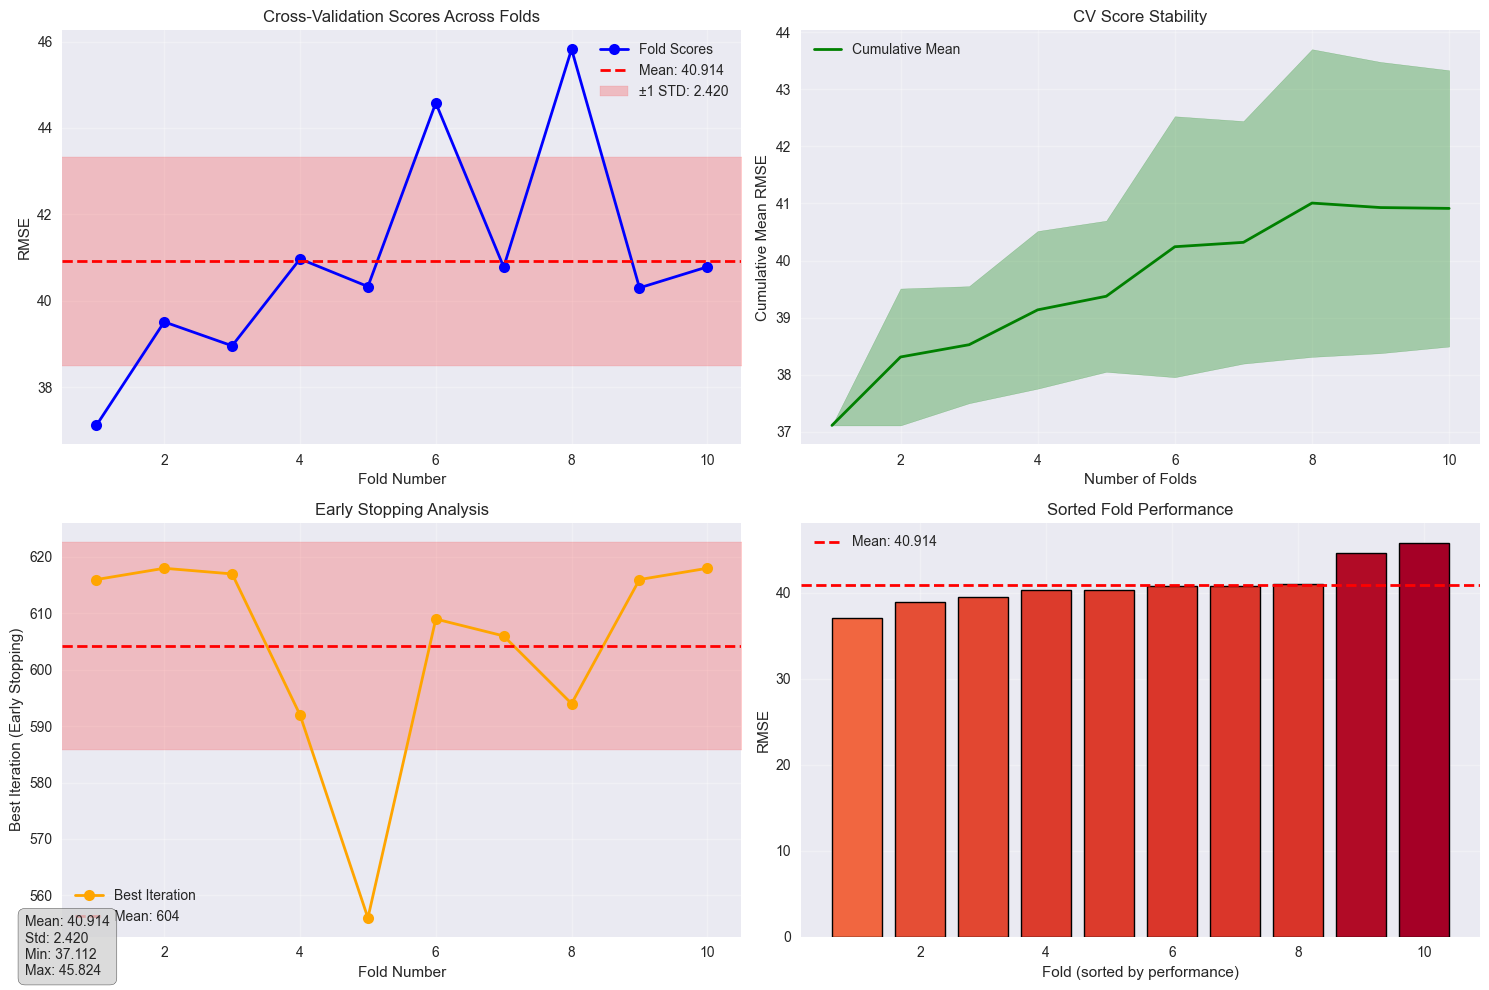

Creating training curve plots...


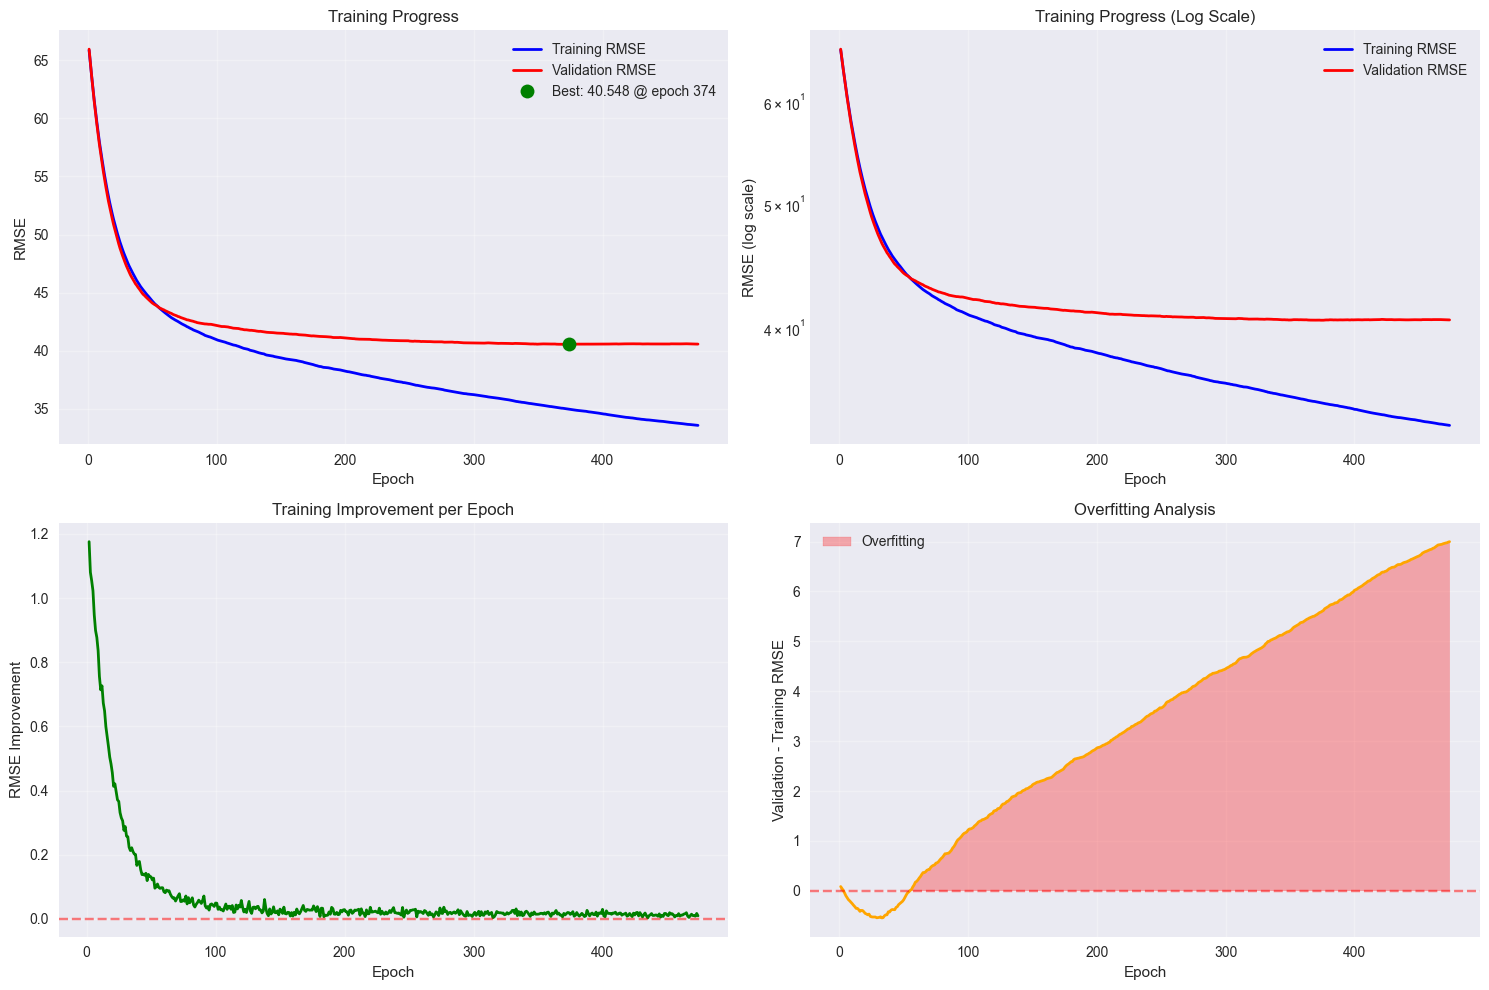


Training completed successfully!
Total time: 379.8s
Final test RMSE: 41.73 days
Advanced CV RMSE: 40.91 ± 2.42 days


In [25]:
start_time = time.time()

results_fs_optuna = trainer.train_model(
    X=current_X_S, y=current_y_s,
    numerical_features=current_num_for_trainer_S, 
    categorical_features=current_cat_for_trainer_S,
    model_name=f'scdb_duration_{set_name_key}_optuna_regularized',
    optimization_method='optuna',
    optimization_params={
        'n_trials': 100, 
        'timeout': 1200, 
        'search_space': optuna_search_space_regularized  
    },
    early_stopping_rounds=100,  # Increase from 50
    create_plots=True,
    perform_cv=True, 
    cv_folds=10,  # Increase from 5
    advanced_cv=True,
    plot_cv_results=True,
    plot_training_curves=True,
    eval_size=0.2  # Increase validation size -> 60 20 20 split
)

run_time = time.time() - start_time

# if results_fs_optuna:
#     results_fs_optuna['training_time'] = run_time
#     print(f"Training completed in {run_time:.1f}s")
#     if results_fs_optuna.get('metrics', {}).get('test'):
#         print(f"Test RMSE: {results_fs_optuna['metrics']['test']['rmse']:.2f} days")
# all_scenario_results["test"] = results_fs_optuna

Loading results from data folder and getting function ready for extraction of model information

In [26]:
print("\n--- REGENERATING FULL RESULTS TABLE TO INCLUDE NEW MODEL ---")

# 1. Automatically discover ALL trained models, including the one just created.
print("1. Searching for trained models in '../models' directory...")
available_models = list_trained_models(models_base_dir="../models")
model_paths = [model['path'] for model in available_models]
print(f"Found {len(model_paths)} total models.")

# 2. Generate the comprehensive results table from the discovered models.
print("\n2. Generating comprehensive results table...")
detailed_results_df = create_comprehensive_results_table_enhanced(model_paths)

# 3. Display the final, detailed DataFrame.
print("\n" + "="*120)
print("--- UPDATED COMPREHENSIVE RESULTS TABLE ---")
print("="*120)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 50)
print(detailed_results_df)

# 4. Save the comprehensive DataFrame to a CSV file for later analysis.
output_csv_path = '../data/model_results/model_comparison_comprehensive.csv'
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
detailed_results_df.to_csv(output_csv_path, index=False)
print(f"\nUpdated comprehensive results table saved to: '{output_csv_path}'")


--- REGENERATING FULL RESULTS TABLE TO INCLUDE NEW MODEL ---
1. Searching for trained models in '../models' directory...
Found 10 total models.

2. Generating comprehensive results table...

--- UPDATED COMPREHENSIVE RESULTS TABLE ---
                                          Model Name  Train Samples  Validate Samples  Test Samples Tree Method  Processed Features  Training Duration (s)  Train RMSE  Validation RMSE  Test RMSE  Train MAE  Validation MAE   Test MAE  Train R²  Validation R²   Test R²  n_estimators  learning_rate  max_depth  subsample  colsample_bytree  reg_alpha  reg_lambda                   Timestamp
0       scdb_duration_full_with_leakage_logtarget_v1           6196              1431          1907    gpu_hist                  86             273.566089    0.039845         0.076936   0.124014   0.016658        0.026478   0.031478  0.996406       0.986161  0.966575          1804       0.024970          8       0.80              0.85   0.054832    0.352341  2025-06-09T01:4

#### Function for displaying all information about each model

In [29]:
# from src.model_utils import list_trained_models

# available_models = list_trained_models(models_base_dir="../models")
# sorted_by_rmse = sorted(available_models, key=lambda x: x.get('test_rmse', float('inf')))

# print(f"\nFound {len(sorted_by_rmse)} models:")
# for i, model_info in enumerate(sorted_by_rmse):
#     rmse_str = f"{model_info.get('test_rmse'):.2f}" if model_info.get('test_rmse') else "N/A"
#     print(f"  [{i}] {model_info['name']} (RMSE: {rmse_str})")

Firsly we will create a function for finding all the models within the models directory

In [28]:
import pandas as pd
from src.model_utils import list_trained_models 

available_models = list_trained_models(models_base_dir="../models")
sorted_by_rmse = sorted(available_models, key=lambda x: x.get('test_rmse', float('inf')))

print(f"\nFound {len(sorted_by_rmse)} models:")
for i, model_info in enumerate(sorted_by_rmse):
    rmse_str = f"{model_info.get('test_rmse'):.2f}" if model_info.get('test_rmse') else "N/A"
    print(f"  [{i}] {model_info['name']} (RMSE: {rmse_str})")

# Create a DataFrame containing all model information
all_models_df = pd.DataFrame(sorted_by_rmse)

# The index is automatically created and corresponds to the [i] in your printout
models_df = all_models_df[['name', 'path']].copy()

print("\n--- Generated DataFrame ---")
models_df

# # Example of how to use it: get the path of the best model (index 0)
# best_model_path = models_df.loc[0, 'path']
# print(f"\nPath to the best model: {best_model_path}")


Found 10 models:
  [0] scdb_duration_full_with_leakage_logtarget_v1 (RMSE: 0.12)
  [1] scdb_duration_leakage_controlled_logtarget_v1 (RMSE: 0.49)
  [2] scdb_duration_basic_logtarget_v1 (RMSE: 0.50)
  [3] scdb_duration_full_with_leakage_optuna_v1 (RMSE: 17.71)
  [4] scdb_duration_full_with_leakage_baseline_v1 (RMSE: 18.30)
  [5] scdb_duration_leakage_controlled_optuna_v1 (RMSE: 41.05)
  [6] scdb_duration_leakage_controlled_baseline_v1 (RMSE: 41.29)
  [7] scdb_duration_leakage_controlled_optuna_regularized_v1 (RMSE: 41.73)
  [8] scdb_duration_basic_optuna_v1 (RMSE: 42.39)
  [9] scdb_duration_basic_baseline_v1 (RMSE: 42.92)

--- Generated DataFrame ---


name                                               path
0       scdb_duration_full_with_leakage_logtarget_v1  ../models\scdb_duration_full_with_leakage_logt...
1      scdb_duration_leakage_controlled_logtarget_v1  ../models\scdb_duration_leakage_controlled_log...
2                   scdb_duration_basic_logtarget_v1         ../models\scdb_duration_basic_logtarget_v1
3          scdb_duration_full_with_leakage_optuna_v1  ../models\scdb_duration_full_with_leakage_optu...
4        scdb_duration_full_with_leakage_baseline_v1  ../models\scdb_duration_full_with_leakage_base...
5         scdb_duration_leakage_controlled_optuna_v1  ../models\scdb_duration_leakage_controlled_opt...
6       scdb_duration_leakage_controlled_baseline_v1  ../models\scdb_duration_leakage_controlled_bas...
7  scdb_duration_leakage_controlled_optuna_regula...  ../models\scdb_duration_leakage_controlled_opt...
8                      scdb_duration_basic_optuna_v1            ../models\scdb_duration_basic_optuna_v1
9                    scdb_duration_basic_baseline_v1          ../models\scdb_duration_basic_baseline_v1

Secondly we will create a function for displaying all the information about each model -> may need some changes in train_model.py script

### Ensembling of models -> for now unusable

In [ ]:
# import pandas as pd
# import numpy as np
# import joblib
# import json
# import os
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import xgboost as xgb

# # =============================================================================
# # ENSEMBLE METHOD 1: Simple Ensemble (Different Feature Sets)
# # =============================================================================
# # This works with your existing models
# model_paths = [
#     '../models/scdb_duration_basic_optuna_v1/scdb_duration_basic_optuna_v1.joblib',
#     '../models/scdb_duration_leakage_controlled_optuna_v1/scdb_duration_leakage_controlled_optuna_v1.joblib'
# ]

# # Use the test data from your full_with_leakage set as an example
# ensemble_pred = trainer.create_ensemble_predictions(model_paths, current_X_S)
# ensemble_metrics = trainer.evaluate_ensemble(current_y_s, ensemble_pred)

Loaded model 1/2: scdb_duration_basic_optuna_v1.joblib
Loaded model 2/2: scdb_duration_leakage_controlled_optuna_v1.joblib
Created simple average ensemble

Ensemble Performance:
  RMSE: 33.94
  MAE: 23.91
  R²: 0.7528


In [ ]:
# # =============================================================================
# # ENSEMBLE METHOD 2: Ensemble with Log-Transformed Models
# # =============================================================================
# def ensemble_with_log_models(trainer, model_paths, X_test, log_model_indices):
#     """
#     Ensemble models where some use log-transformed targets
#     """
#     predictions = []
    
#     for i, model_path in enumerate(model_paths):
#         if not os.path.exists(model_path):
#             print(f"Model not found: {model_path}")
#             continue
            
#         pipeline = joblib.load(model_path)
#         pred = pipeline.predict(X_test)
        
#         # Transform back to original scale if this was a log model
#         if i in log_model_indices:
#             pred = np.expm1(pred)  # Inverse of log1p
#             print(f"Model {i+1}: Applied inverse log transform")
            
#         predictions.append(pred)
#         print(f"Model {i+1} predictions: mean={pred.mean():.2f}, std={pred.std():.2f}")
    
#     # Now all predictions are on the same scale
#     ensemble_pred = np.mean(predictions, axis=0)
#     return ensemble_pred

# # Example with your models:
# model_paths = [
#     '../models/scdb_duration_basic_optuna_v1/scdb_duration_basic_optuna_v1.joblib',
#     '../models/scdb_duration_leakage_controlled_logtarget_v1/scdb_duration_leakage_controlled_logtarget_v1.joblib'
# ]
# log_model_indices = [1]  # Second model used log transform

# ensemble_pred_log = ensemble_with_log_models(trainer, model_paths, current_X_S, log_model_indices)
# rmse_ensemble = np.sqrt(mean_squared_error(current_y_s, ensemble_pred_log))
# print(f"\nEnsemble with log model RMSE: {rmse_ensemble:.2f}")

Model 1 predictions: mean=92.87, std=54.59
Model 2: Applied inverse log transform
Model 2 predictions: mean=84.19, std=50.99

Ensemble with log model RMSE: 35.57


In [ ]:
# # =============================================================================
# # ENSEMBLE METHOD 3: Weighted Ensemble Based on CV Performance 
# # =============================================================================
# def get_model_info_from_metadata(model_dirs):
#     """
#     Automatically extract model info from metadata files
#     """
#     model_info = {}
    
#     for model_dir in model_dirs:
#         if not os.path.exists(model_dir):
#             continue
            
#         # Find metadata file
#         metadata_files = [f for f in os.listdir(model_dir) if f.endswith('_metadata.json')]
#         if not metadata_files:
#             continue
            
#         metadata_path = os.path.join(model_dir, metadata_files[0])
#         model_name = metadata_files[0].replace('_metadata.json', '')
#         model_path = os.path.join(model_dir, f"{model_name}.joblib")
        
#         # Load metadata
#         with open(metadata_path, 'r') as f:
#             metadata = json.load(f)
        
#         # Extract CV results
#         cv_results = metadata.get('cross_validation')
#         if cv_results and 'cv_mean' in cv_results:
#             cv_rmse = cv_results['cv_mean']
#         else:
#             # Use test RMSE if no CV
#             test_rmse = metadata.get('performance_metrics', {}).get('test', {}).get('rmse')
#             cv_rmse = test_rmse if test_rmse else None
            
#         if cv_rmse:
#             model_info[model_name] = {
#                 'path': model_path,
#                 'cv_rmse': cv_rmse,
#                 'test_rmse': metadata.get('performance_metrics', {}).get('test', {}).get('rmse', 'N/A')
#             }
    
#     return model_info

# def create_weighted_ensemble_from_cv(trainer, model_info_dict, X_test):
#     """
#     Create weighted ensemble where weights are based on CV performance
#     """
#     model_paths = []
#     cv_scores = []
    
#     for model_name, info in model_info_dict.items():
#         model_paths.append(info['path'])
#         cv_scores.append(info['cv_rmse'])
    
#     # Convert RMSE to weights (lower is better)
#     # Use inverse of scores
#     weights = 1 / np.array(cv_scores)
#     weights = weights / weights.sum()  # Normalize to sum to 1
    
#     print("Model weights based on CV performance:")
#     for i, (name, weight) in enumerate(zip(model_info_dict.keys(), weights)):
#         print(f"  {name}: {weight:.3f} (CV RMSE: {cv_scores[i]:.2f})")
    
#     return trainer.create_ensemble_predictions(model_paths, X_test, weights=weights)

# model_directories = [
#     '../models/scdb_duration_full_with_leakage_optuna_v1',
#     '../models/scdb_duration_basic_optuna_v1',
#     '../models/scdb_duration_full_with_leakage_baseline_v1',
#     '../models/scdb_duration_leakage_controlled_baseline_v1',
# ]

# # Automatically get model info
# model_info = get_model_info_from_metadata(model_directories)
# print("\nFound models:")
# for name, info in model_info.items():
#     print(f"  {name}: CV RMSE={info['cv_rmse']:.2f}")

# # Create weighted ensemble
# if model_info:
#     ensemble_pred_weighted = create_weighted_ensemble_from_cv(trainer, model_info, current_X_S)
#     rmse_weighted = np.sqrt(mean_squared_error(current_y_s, ensemble_pred_weighted))
#     print(f"\nWeighted ensemble RMSE: {rmse_weighted:.2f}")


Found models:
  scdb_duration_full_with_leakage_optuna_v1: CV RMSE=14.21
  scdb_duration_basic_optuna_v1: CV RMSE=41.13
  scdb_duration_full_with_leakage_baseline_v1: CV RMSE=19.02
  scdb_duration_leakage_controlled_baseline_v1: CV RMSE=41.38
Model weights based on CV performance:
  scdb_duration_full_with_leakage_optuna_v1: 0.410 (CV RMSE: 14.21)
  scdb_duration_basic_optuna_v1: 0.142 (CV RMSE: 41.13)
  scdb_duration_full_with_leakage_baseline_v1: 0.307 (CV RMSE: 19.02)
  scdb_duration_leakage_controlled_baseline_v1: 0.141 (CV RMSE: 41.38)
Loaded model 1/4: scdb_duration_full_with_leakage_optuna_v1.joblib
Loaded model 2/4: scdb_duration_basic_optuna_v1.joblib
Loaded model 3/4: scdb_duration_full_with_leakage_baseline_v1.joblib
Loaded model 4/4: scdb_duration_leakage_controlled_baseline_v1.joblib
Created weighted average ensemble

Weighted ensemble RMSE: 14.83


In [ ]:
# # =============================================================================
# # ENSEMBLE METHOD 4: Stacking Ensemble
# # =============================================================================
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_predict

# def create_stacking_ensemble(model_paths, X_train, y_train, X_test):
#     """
#     Create a stacking ensemble where a meta-model learns how to combine base models
#     Note: This requires the original training data, not just test data
#     """
#     # Generate base model predictions for training
#     train_predictions = []
#     test_predictions = []
    
#     print("Generating base model predictions...")
#     for i, model_path in enumerate(model_paths):
#         if not os.path.exists(model_path):
#             print(f"Warning: Model not found at {model_path}")
#             continue
            
#         pipeline = joblib.load(model_path)
#         print(f"  Model {i+1}: {os.path.basename(model_path)}")
        
#         # Use cross_val_predict to get out-of-fold predictions for training
#         # This prevents overfitting in the meta-model
#         try:
#             train_pred = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=-1)
#             train_predictions.append(train_pred)
#         except:
#             # If cross_val_predict fails, use regular predict with warning
#             print(f"Warning: cross_val_predict failed, using regular predict")
#             train_pred = pipeline.predict(X_train)
#             train_predictions.append(train_pred)
        
#         # Get test predictions
#         test_pred = pipeline.predict(X_test)
#         test_predictions.append(test_pred)
    
#     if not train_predictions:
#         raise ValueError("No valid models found for stacking")
    
#     # Stack predictions horizontally
#     X_meta_train = np.column_stack(train_predictions)
#     X_meta_test = np.column_stack(test_predictions)
    
#     print(f"\nMeta-features shape: {X_meta_train.shape}")
    
#     # Train meta-model
#     print("Training meta-model...")
#     meta_model = LinearRegression()
#     meta_model.fit(X_meta_train, y_train)
    
#     # Show learned weights
#     print("\nLearned weights for each model:")
#     for i, coef in enumerate(meta_model.coef_):
#         print(f"  Model {i+1}: {coef:.3f}")
#     print(f"  Intercept: {meta_model.intercept_:.3f}")
    
#     # Final predictions
#     ensemble_pred = meta_model.predict(X_meta_test)
    
#     return ensemble_pred, meta_model

# # Example usage (you need train/test split for this):
# # First create a proper train/test split
# from sklearn.model_selection import train_test_split
# X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(
#     current_X_S, current_y_s, test_size=0.2, random_state=42
# )

# model_paths_for_stacking = [
#     '../models/scdb_duration_leakage_controlled_optuna_v1/scdb_duration_leakage_controlled_optuna_v1.joblib',
#     '../models/scdb_duration_full_with_leakage_baseline_v1/scdb_duration_full_with_leakage_baseline_v1.joblib'
# ]

# try:
#     stacking_pred, meta_model = create_stacking_ensemble(
#         model_paths_for_stacking, X_train_stack, y_train_stack, X_test_stack
#     )
#     rmse_stacking = np.sqrt(mean_squared_error(y_test_stack, stacking_pred))
#     print(f"\nStacking ensemble RMSE: {rmse_stacking:.2f}")
# except Exception as e:
#     print(f"Stacking failed: {e}")

Generating base model predictions...
  Model 1: scdb_duration_leakage_controlled_optuna_v1.joblib
  Model 2: scdb_duration_full_with_leakage_baseline_v1.joblib

Meta-features shape: (7627, 2)
Training meta-model...

Learned weights for each model:
  Model 1: 0.018
  Model 2: 1.034
  Intercept: -4.804

Stacking ensemble RMSE: 9.33


In [ ]:
# import os
# import joblib
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_predict, train_test_split
# from sklearn.metrics import mean_squared_error

# def create_stacking_ensemble(model_paths, X_train, y_train, X_test):
#     """
#     Creates a stacking ensemble and returns predictions for both train and test sets.
#     """
#     train_predictions = []
#     test_predictions = []
    
#     print("Generating base model predictions...")
#     for i, model_path in enumerate(model_paths):
#         if not os.path.exists(model_path):
#             print(f"Warning: Model not found at {model_path}")
#             continue
            
#         pipeline = joblib.load(model_path)
#         model_name = os.path.basename(os.path.dirname(model_path))
#         print(f"  Model {i+1}: {model_name}")
        
#         # Use cross_val_predict to get out-of-fold predictions for the training set
#         # This is the key to preventing data leakage to the meta-model
#         try:
#             oof_train_pred = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=-1)
#             train_predictions.append(oof_train_pred)
#         except Exception as e:
#             print(f"Warning: cross_val_predict failed for {model_name}, using regular predict. This may lead to overfitting. Error: {e}")
#             oof_train_pred = pipeline.predict(X_train)
#             train_predictions.append(oof_train_pred)
        
#         # Get predictions for the actual test set
#         # The pipeline should be fit on the full X_train before this, which joblib.load ensures
#         test_pred = pipeline.predict(X_test)
#         test_predictions.append(test_pred)
    
#     if not train_predictions:
#         raise ValueError("No valid models found for stacking")
    
#     # Stack predictions horizontally to create features for the meta-model
#     X_meta_train = np.column_stack(train_predictions)
#     X_meta_test = np.column_stack(test_predictions)
    
#     print(f"\nMeta-features shape: {X_meta_train.shape}")
    
#     # Train the meta-model
#     print("Training meta-model...")
#     meta_model = LinearRegression()
#     meta_model.fit(X_meta_train, y_train)
    
#     print("\nLearned weights (coefficients) for each base model:")
#     for i, coef in enumerate(meta_model.coef_):
#         print(f"  Model {i+1}: {coef:.3f}")
#     print(f"  Intercept: {meta_model.intercept_:.3f}")
    
#     # --- Generate final predictions from the meta-model ---
#     # Predictions on the training data (using the OOF features)
#     final_train_pred = meta_model.predict(X_meta_train)
    
#     # Predictions on the test data
#     final_test_pred = meta_model.predict(X_meta_test)
    
#     # Return both sets of predictions and the trained meta-model
#     return final_train_pred, final_test_pred, meta_model

# # =============================================================================
# # EXAMPLE USAGE
# # =============================================================================

# # Assuming current_X_S and current_y_s are your full feature and target sets
# # First, create a proper train/test split
# X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(
#     current_X_S, current_y_s, test_size=0.2, random_state=42
# )

# model_paths_for_stacking = [
#     '../models/scdb_duration_leakage_controlled_optuna_v1/scdb_duration_leakage_controlled_optuna_v1.joblib',
#     '../models/scdb_duration_full_with_leakage_baseline_v1/scdb_duration_full_with_leakage_baseline_v1.joblib'
# ]

# try:
#     # The function now returns predictions for both train and test sets
#     stacking_train_pred, stacking_test_pred, meta_model = create_stacking_ensemble(
#         model_paths_for_stacking, X_train_stack, y_train_stack, X_test_stack
#     )
    
#     # --- Calculate and print performance metrics ---
#     # Train RMSE is calculated on the out-of-fold predictions
#     rmse_stacking_train = np.sqrt(mean_squared_error(y_train_stack, stacking_train_pred))
    
#     # Test RMSE is calculated on the holdout test set
#     rmse_stacking_test = np.sqrt(mean_squared_error(y_test_stack, stacking_test_pred))
    
#     print("\n--- Stacking Ensemble Performance ---")
#     print(f"Train RMSE (on OOF predictions): {rmse_stacking_train:.4f}")
#     print(f"Test RMSE: {rmse_stacking_test:.4f}")

# except Exception as e:
#     print(f"\nStacking failed: {e}")

Generating base model predictions...
  Model 1: scdb_duration_leakage_controlled_optuna_v1
  Model 2: scdb_duration_full_with_leakage_baseline_v1

Meta-features shape: (7627, 2)
Training meta-model...

Learned weights (coefficients) for each base model:
  Model 1: 0.018
  Model 2: 1.034
  Intercept: -4.804

--- Stacking Ensemble Performance ---
Train RMSE (on OOF predictions): 12.0407
Test RMSE: 9.3350


#### Feature selection



Method 3: SelectFromModel approach
Preprocessing data with one-hot encoding...
Shape after preprocessing: (9534, 74)
Training selector model...
SelectFromModel selected 37 features using median threshold


## 6. Handling the model outputs

This part concentrases on optuna related outputs, such as the study file and database file. The study file contains the complete optimization history, including all trials and their results. 

1. The Contour Plot: Diagnosing the Problem and How to Fix It

A contour plot is designed to show the relationship between pairs of hyperparameters and the objective value (a lower-is-better metric like RMSE). 

2. The EDF Plot: Understanding Your Optimization Progress

The "Edf" plot is the Empirical Distribution Function plot. It's a bit abstract, but it's essentially a progress report on model's performance scores.

3. Quick Guide to Other Key Plots
Here’s what to look for in the other essential plots your script generates.

A. Optimization History Plot

What it Shows: The performance of every trial over time.

What to Look For: A clear downward trend. The scores should get better (lower) as the trials progress.

The dark blue line shows the best score found so far. You want to see this drop quickly and then plateau, which indicates you've likely found the optimal region.

Red Flags: If the plot looks like random static (no downward trend), the search isn't working. If it's still trending down sharply at the very end, you should probably run more trials.

B. Parameter Importance Plot

What it Shows: A bar chart ranking which hyperparameters had the biggest impact on the model's score.

What to Look For: This is your most important plot. It tells you where to focus. A few tall bars are great—it means you've identified the critical knobs to tune.

Red Flags: If all bars are roughly the same height, it might mean none of your chosen parameters are very impactful, or their ranges are too small.

C. Parallel Coordinate Plot

What it Shows: A holistic view of all trials. Each line is one trial, connecting the hyperparameter values it used.

What to Look For: Look for the best-performing trials (they will be colored blue/purple).

Follow these colored lines and see where they cluster for each parameter. This shows you the "recipe" for a good model. For example, you might see all the best lines pass through a low learning_rate and a high n_estimators.

Red Flags: If the best (colored) lines are spread all over the place for every parameter, it means there's no clear pattern for a good model, suggesting very complex interactions.

##### Optuna outputs

In [30]:
# =============================================================================
# XAI ANALYSIS - STEP 1: OPTUNA VISUALIZATION (IMPROVED PLOTS & ROBUST LOADING)
# This script intelligently creates focused plots and filters the model list
# without modifying the original list_trained_models function.
# =============================================================================

import os
import glob
import json
import joblib
import optuna
import optuna.visualization as vis
import warnings
from typing import Dict, List, Any

warnings.filterwarnings('ignore')

# =============================================================================
# UNCHANGED UTILITY FUNCTION TO FIND MODELS
# =============================================================================

# def list_trained_models(models_base_dir: str = "../models") -> List[Dict[str, Any]]:
#     """
#     Scans the base directory for trained models and returns their info.
#     Sorts models by timestamp, from newest to oldest.
#     (This function is kept exactly as you provided it).
#     """
#     model_infos = []
#     if not os.path.isdir(models_base_dir):
#         print(f"Warning: Models base directory '{models_base_dir}' not found.")
#         return model_infos

#     search_pattern = os.path.join(models_base_dir, "*_v*")
#     potential_dirs = glob.glob(search_pattern)

#     for item_path in potential_dirs:
#         if os.path.isdir(item_path):
#             model_name_versioned = os.path.basename(item_path)
#             metadata_path = os.path.join(item_path, f"{model_name_versioned}_metadata.json")
            
#             if os.path.exists(metadata_path):
#                 try:
#                     with open(metadata_path, 'r') as f:
#                         metadata = json.load(f)
#                     model_infos.append({
#                         'name': model_name_versioned,
#                         'path': item_path,
#                         'timestamp': metadata.get('timestamp'),
#                         'test_rmse': metadata.get('performance_metrics', {}).get('test', {}).get('rmse')
#                     })
#                 except (json.JSONDecodeError, KeyError) as e:
#                     print(f"Warning: Could not process metadata for {model_name_versioned}: {e}")

#     return sorted(model_infos, key=lambda x: x.get('timestamp', ''), reverse=True)


# =============================================================================
# UNCHANGED VISUALIZATION AND LOADER FUNCTIONS
# =============================================================================

def create_optuna_visualizations(study: optuna.study.Study, model_name: str, save_dir: str):
    # This function remains the same
    print(f"\nGenerating Optuna visualizations for '{model_name}'...")
    print(f"Saving plots to: {save_dir}")
    os.makedirs(save_dir, exist_ok=True)
    try:
        param_importances = optuna.importance.get_param_importances(study)
        N_TOP_PARAMS = 5
        top_params = [name for name, _ in param_importances.items() if _ > 0][:N_TOP_PARAMS]
        if not top_params:
            print("Warning: No parameter importances found. Contour plot may be cluttered.")
            top_params = None
    except Exception as e:
        print(f"Warning: Could not determine parameter importances: {e}")
        top_params = None
    plot_configs = {
        'param_importances': {'func': vis.plot_param_importances, 'params': {}},
        'history': {'func': vis.plot_optimization_history, 'params': {}},
        'edf': {'func': vis.plot_edf, 'params': {}},
        'slice': {'func': vis.plot_slice, 'params': {}},
        'timeline': {'func': vis.plot_timeline, 'params': {}},
        'contour_focused': {'func': vis.plot_contour, 'params': {'params': top_params}},
        'parallel_coordinate_focused': {'func': vis.plot_parallel_coordinate, 'params': {'params': top_params}},
    }
    for plot_name, config in plot_configs.items():
        if 'focused' in plot_name and config['params']['params'] is None:
            print(f"  - Skipping {plot_name} because top parameters could not be determined.")
            continue
        try:
            fig = config['func'](study, **config['params'])
            fig.update_layout(title={'text': f'{plot_name.replace("_", " ").title()} - {model_name}', 'x': 0.5})
            fig.write_image(os.path.join(save_dir, f'optuna_{plot_name}.png'), scale=2)
            fig.write_html(os.path.join(save_dir, f'optuna_{plot_name}.html'))
            print(f"  - Successfully created {plot_name} plot.")
        except (ValueError, TypeError) as e:
            print(f"  - Could not create {plot_name} plot: {e}")
        except Exception as e:
            print(f"  - An unexpected error occurred with {plot_name} plot: {e}")
    print("\nOptuna visualization process complete.")

def run_optuna_visualizations(model_path, model_name):
    # This function remains the same
    study_path = os.path.join(model_path, f"{model_name}_optuna_study.joblib")
    if not os.path.exists(study_path):
        print(f"Error: No Optuna study found at {study_path}")
        return False
    try:
        study = joblib.load(study_path)
        plots_dir = os.path.join(model_path, 'plots', 'optuna')
        create_optuna_visualizations(study, model_name, plots_dir)
        return True
    except Exception as e:
        print(f"Failed to load or visualize Optuna study: {e}")
        return False

In [41]:
    # MODELS_BASE_DIR = "../models"
    
    # # 1. Call the original, unchanged function to get ALL models
    # all_models = list_trained_models(MODELS_BASE_DIR)
    
    # # 2. --- NEW: Filter the list to include only models with an Optuna study ---
    # # This creates a new list, leaving the original function untouched.
    # optuna_models = [
    #     model for model in all_models 
    #     if os.path.exists(os.path.join(model['path'], f"{model['name']}_optuna_study.joblib"))
    # ]
    
    # # 3. Now, use the filtered list for all subsequent operations
    # if not optuna_models:
    #     print("No versioned models with an Optuna study file were found. Exiting.")
    # else:
    #     print(f"\nFound {len(optuna_models)} models with Optuna studies (sorted by newest):")
    #     for i, model_info in enumerate(optuna_models):
    #         rmse_str = f"{model_info.get('test_rmse'):.4f}" if model_info.get('test_rmse') else "N/A"
    #         print(f"  [{i}] {model_info['name']} (RMSE: {rmse_str})")

In [38]:
# =============================================================================
# MAIN ANALYSIS EXECUTION (WITH FILTERING LOGIC MOVED HERE)
# =============================================================================

if __name__ == "__main__":
    MODELS_BASE_DIR = "../models"
    
    # 1. Call the original, unchanged function to get ALL models
    all_models = list_trained_models(MODELS_BASE_DIR)
    
    # 2. --- NEW: Filter the list to include only models with an Optuna study ---
    # This creates a new list, leaving the original function untouched.
    optuna_models = [
        model for model in all_models 
        if os.path.exists(os.path.join(model['path'], f"{model['name']}_optuna_study.joblib"))
    ]
    
    # 3. Now, use the filtered list for all subsequent operations
    if not optuna_models:
        print("No versioned models with an Optuna study file were found. Exiting.")
    else:
        print(f"\nFound {len(optuna_models)} models with Optuna studies (sorted by newest):")
        for i, model_info in enumerate(optuna_models):
            rmse_str = f"{model_info.get('test_rmse'):.4f}" if model_info.get('test_rmse') else "N/A"
            print(f"  [{i}] {model_info['name']} (RMSE: {rmse_str})")
        
        MODEL_INDEX_TO_ANALYZE = 0 
        
        if MODEL_INDEX_TO_ANALYZE >= len(optuna_models):
            print(f"Error: Index {MODEL_INDEX_TO_ANALYZE} is out of range.")
        else:
            selected_model = optuna_models[MODEL_INDEX_TO_ANALYZE]
            print(f"\n{'='*60}")
            print(f"PROCESSING MODEL [{MODEL_INDEX_TO_ANALYZE}]: {selected_model['name']}")
            print(f"{'='*60}")
            
            run_optuna_visualizations(selected_model['path'], selected_model['name'])
            
            print("\nANALYSIS COMPLETED")


Found 7 models with Optuna studies (sorted by newest):
  [0] scdb_duration_leakage_controlled_optuna_regularized_v1 (RMSE: 41.7262)
  [1] scdb_duration_full_with_leakage_logtarget_v1 (RMSE: 0.1240)
  [2] scdb_duration_full_with_leakage_optuna_v1 (RMSE: 17.7138)
  [3] scdb_duration_leakage_controlled_logtarget_v1 (RMSE: 0.4889)
  [4] scdb_duration_leakage_controlled_optuna_v1 (RMSE: 41.0472)
  [5] scdb_duration_basic_logtarget_v1 (RMSE: 0.5048)
  [6] scdb_duration_basic_optuna_v1 (RMSE: 42.3931)

PROCESSING MODEL [0]: scdb_duration_leakage_controlled_optuna_regularized_v1

Generating Optuna visualizations for 'scdb_duration_leakage_controlled_optuna_regularized_v1'...
Saving plots to: ../models\scdb_duration_leakage_controlled_optuna_regularized_v1\plots\optuna
  - Successfully created param_importances plot.
  - Successfully created history plot.
  - Successfully created edf plot.
  - Successfully created slice plot.
  - Successfully created timeline plot.
  - Successfully created con

Overall Study Performance:

History Plot (optuna_history.png): The best objective value (red line) consistently decreased and flattened out around 40.5 - 40.6 after about 80 trials. 

EDF Plot (optuna_edf.png): The curve rises relatively steeply, showing that a significant portion of trials achieved objective values below 41.5. This confirms that Optuna is efficient in finding good solutions, rather than just random ones. The best trials are clustered at the lower end of the objective values.

Param Importances Plot (optuna_param_importances.png):

max_depth (0.57): This is the most important hyperparameter, accounting for 57% of the importance. This strongly suggests that controlling tree depth is critical for model's performance and generalization.

min_child_weight (0.17): The second most important parameter. This also directly impacts regularization by controlling minimum instances per leaf.
gamma (0.06), subsample (0.05), reg_alpha (0.04), n_estimators (0.04), reg_lambda (0.04), learning_rate (0.03): These parameters have moderate to low importance. 

##### XAI analysis

Proceeding to XAI analysis

All output files are saved within the `xai_analysis_report_v5` subdirectory, located inside the specific model's directory (e.g., `../models/{model_name}/xai_analysis_report_v5/`).

1. SHAP Analysis Outputs (in `.../xai_analysis_report_v5/shap/`):
   - `shap_summary_bar.png`: Global feature importance (mean |SHAP value|) bar plot.
   - `dependence_plots/shap_pdp_{i}_{feature_name}.png`: Partial Dependence Plots showing feature effects.
   - `waterfalls/shap_waterfall_{type}.png`: Explanations for individual predictions (highest, lowest, median).
2. Grouped Feature Importance Output (in `.../xai_analysis_report_v5/grouped_importance/`):
   - `grouped_feature_importance.png`: Cumulative SHAP importance by feature category.
3. Dalex Analysis Outputs (in `.../xai_analysis_report_v5/dalex/`):
   - `dalex_feature_importance.png`: Permutation-based feature importance bar plot.
   - `dalex_pdp_ice_profiles.png`: Combined Partial Dependence Plots (PDPs) and Individual Conditional Expectation (ICE) curves for top features.
   - `dalex_breakdown_median.png`: Local explanation (breakdown) for the median prediction instance.
4. Error Analysis Output (in `.../xai_analysis_report_v5/`):
   - `error_analysis_report.png`: Multi-plot figure including error distribution, residuals vs. predicted, and Q-Q plot of errors.
Console Output:
- Log messages indicating successful loading, calculations, and saving of plots.
- Summary statistics for predictions and errors (MAE, RMSE, Mean Error, Std Error).

In [40]:
# =============================================================================
#  XAI ANALYSIS 
# =============================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

# --- Import utility functions ---
import sys
from src.model_utils import list_trained_models, load_model_artifacts, get_data_splits_from_metadata

# --- Import XAI libraries ---
import shap
import dalex as dx
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import warnings

# --- Setup ---
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="husl")
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.dpi'] = 150

# =============================================================================
# SECTION 1: FEATURE NAME AND GROUP MAPPING
# =============================================================================

FEATURE_DISPLAY_NAMES = {
    'days_term_start_to_argument': 'Days: Term Start to Argument', 'days_term_start_to_decision': 'Days: Term Start to Decision',
    'month_of_decision': 'Decision Month', 'arg_month_cos': 'Argument Month (Cosine)', 'year_of_decision': 'Decision Year',
    'month_of_argument': 'Argument Month', 'arg_month_sin': 'Argument Month (Sine)', 'natural_court_period': 'Natural Court Period',
    'quarter_of_argument': 'Argument Quarter', 'court_term_year': 'Court Term Year', 'chief_justice_sname': 'Chief Justice',
    'consolidated_dockets_count': 'Consolidated Dockets', 'lower_court_disposition_direction_conservative': 'Lower Court Disposition: Conservative',
    'is_decision_late_in_term': 'Late Term Decision', 'broad_issue_area': 'Broad Issue Area',
    'lower_court_disposition_direction_liberal': 'Lower Court Disposition: Liberal', 'lower_court_disagreement': 'Lower Court Disagreement',
    'lower_court_disposition_type': 'Lower Court Disposition', 'respondent_type': 'Respondent Type', 'is_argument_late_in_term': 'Late Term Argument',
    'petitioner_type': 'Petitioner Type', 'cert_reason_category': 'Certiorari Reason', 'jurisdiction_type': 'Jurisdiction Type',
    'law_type_category': 'Law Type', 'case_docket_type': 'Docket Type', 'case_origin_type': 'Case Origin Type', 'case_source_type': 'Case Source Type'
}

adjusted_feature_categories = {
    'Temporal Features': ['month_of_argument', 'month_of_decision', 'year_of_decision', 'days_term_start_to_argument', 'days_term_start_to_decision', 'is_argument_late_in_term', 'is_decision_late_in_term', 'quarter_of_argument', 'is_summer_recess', 'arg_month_cos', 'arg_month_sin'],
    'Court Structure': ['chief_justice_sname', 'natural_court_period', 'court_term_year'], 'Case Origin/Source': ['case_origin_type', 'case_source_type'],
    'Case Type/Jurisdiction': ['case_docket_type', 'jurisdiction_type', 'cert_reason_category', 'jurisdiction_x_issue'], 'Legal Issues': ['broad_issue_area', 'law_type_category'],
    'Party Configuration': ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case', 'is_individual_vs_govt_case', 'is_state_vs_state_case'],
    'Lower Court Info': ['lower_court_disagreement', 'lower_court_disposition_type', 'lower_court_disposition_direction_conservative', 'lower_court_disposition_direction_liberal'],
    'Complexity Indicators': ['consolidated_dockets_count', 'complexity_score_consolidated_disagree', 'three_judge_district_court'],
    'Specialized Features': ['is_admin_economic_case', 'is_federal_circuit_conflict'], 'Missing Indicators': ['lower_court_disagree_was_missing', 'three_judge_info_was_missing']
}

def get_readable_name(feature_name: str) -> str:
    """Gets a readable name from the dictionary or formats it."""
    return FEATURE_DISPLAY_NAMES.get(feature_name, feature_name.replace('_', ' ').title())

# =============================================================================
# SECTION 2: ADVANCED XAI ANALYSIS FUNCTIONS
# =============================================================================

def run_grouped_feature_importance_analysis(shap_values, X_processed, feature_groups, save_dir):
    print("\n[XAI] Generating Grouped Feature Importance analysis...")
    os.makedirs(save_dir, exist_ok=True)
    feature_importance_df = pd.DataFrame({'feature': X_processed.columns, 'importance': np.abs(shap_values.values).mean(axis=0)})

    def get_original_name_from_processed(processed_name):
        if '__' in processed_name:
            parts = processed_name.split('__')
            for cat_name in feature_groups.keys():
                for feat_name in feature_groups[cat_name]:
                    if parts[1].startswith(feat_name): return feat_name
            return parts[1]
        return processed_name

    feature_importance_df['original_feature'] = feature_importance_df['feature'].apply(get_original_name_from_processed)
    group_importance = {group: 0 for group in feature_groups.keys()}
    for _, row in feature_importance_df.iterrows():
        for group, features_in_group in feature_groups.items():
            if row['original_feature'] in features_in_group:
                group_importance[group] += row['importance']
                break
    group_importance_df = pd.DataFrame.from_dict(group_importance, orient='index', columns=['importance'])
    group_importance_df = group_importance_df[group_importance_df['importance'] > 0].sort_values('importance', ascending=False)

    plt.figure(figsize=(14, 10))
    sns.barplot(x='importance', y=group_importance_df.index, data=group_importance_df, palette='viridis')
    plt.title('Cumulative Feature Importance by Category (SHAP)', fontsize=16)
    plt.xlabel('Mean Absolute SHAP Value (Impact on Prediction)', fontsize=12)
    plt.ylabel('Feature Category', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'grouped_feature_importance.png'))
    plt.close()
    print("  Grouped importance plot saved successfully.")

def run_shap_analysis(model, X_processed, save_dir):
    print("\n[XAI] Generating SHAP explanations...")
    os.makedirs(os.path.join(save_dir, 'waterfalls'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'dependence_plots'), exist_ok=True)
    print("  Calculating SHAP values and predictions...")
    predictions = model.predict(X_processed)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_processed)
    X_processed_for_plots = X_processed.copy()
    X_processed_for_plots.columns = [get_readable_name(f) for f in X_processed.columns]
    
    print("  Generating global importance plots...")
    plt.figure()
    shap.summary_plot(shap_values, X_processed_for_plots, plot_type="bar", show=False, max_display=20)
    plt.title('Global SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'shap_summary_bar.png'))
    plt.close()

    print("  Generating SHAP dependence plots (PDPs)...")
    for i, feature_name in enumerate(X_processed_for_plots.columns[:10]):
        shap.dependence_plot(feature_name, shap_values.values, X_processed_for_plots, show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'dependence_plots', f'shap_pdp_{i}_{feature_name.replace(":", "")}.png'))
        plt.close()

    print("  Generating SHAP waterfall plots for specific instances...")
    instance_indices = {'highest_prediction': np.argmax(predictions), 'lowest_prediction': np.argmin(predictions), 'median_prediction': np.argsort(predictions)[len(predictions) // 2]}
    for name, idx in instance_indices.items():
        temp_shap_values = shap.Explanation(values=shap_values.values[idx], base_values=shap_values.base_values[idx], data=X_processed_for_plots.iloc[idx].values, feature_names=X_processed_for_plots.columns.tolist())
        shap.plots.waterfall(temp_shap_values, max_display=15, show=False)
        plt.title(f'SHAP Waterfall for {name.replace("_", " ")} (Index: {idx})')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'waterfalls', f'shap_waterfall_{name}.png'))
        plt.close()
    return shap_values

def run_dalex_analysis(pipeline, X_test, y_test, clean_model_name, save_dir):
    """
    Generates and saves key Dalex explanation plots with readable names.
    Fixed version that properly handles feature names.
    """
    print("\n[XAI] Generating Dalex explanations...")
    os.makedirs(save_dir, exist_ok=True)
    
    # Create explainer with the pipeline
    explainer = dx.Explainer(pipeline, X_test, y_test, label=clean_model_name)
    
    # --- Feature Importance ---
    print("  Calculating permutation feature importance...")
    fi = explainer.model_parts(random_state=420)
    
    # Plot feature importance
    p_fi = fi.plot(max_vars=20, show=False)
    
    # Update the plot labels with readable names
    original_labels = p_fi.data[0].y
    p_fi.data[0].y = [get_readable_name(name) for name in original_labels]
    
    p_fi.update_layout(
        title=f"Dalex: Permutation Feature Importance for {clean_model_name}", 
        yaxis={'categoryorder':'total ascending'}
    )
    p_fi.write_image(os.path.join(save_dir, 'dalex_feature_importance.png'))
    print("  Feature importance plot saved.")

    # --- PDP and ICE Plots ---
    print("  Generating Dalex PDP & ICE plots...")
    
    # Get top features from the feature importance results
    # These are the original feature names that exist in X_test
    top_features = fi.result['variable'].tolist()[:5]  # Reduced to 5 for faster execution
    
    # Verify that these features exist in X_test
    available_features = [f for f in top_features if f in X_test.columns]
    
    if not available_features:
        print("  WARNING: No matching features found for PDP plots. Skipping...")
        return
    
    # Generate PDP/ICE for available features
    pdp_ice = explainer.model_profile(variables=available_features, N=100)  # Reduced N for faster execution
    
    # Plot PDP/ICE
    p_pdp = pdp_ice.plot(show=False)
    
    # Update annotations with readable names
    new_annotations = []
    for annotation in p_pdp.layout.annotations:
        text = annotation.text
        # Extract feature name from annotation
        if ' = ' in text:
            original_name = text.split(' = ')[1]
        else:
            original_name = text
        
        # Convert to readable name
        readable_name = get_readable_name(original_name)
        annotation.text = readable_name
        new_annotations.append(annotation)
    
    p_pdp.layout.annotations = new_annotations
    p_pdp.update_layout(title=f"Dalex: PDP and ICE Profiles for {clean_model_name}")
    p_pdp.write_image(os.path.join(save_dir, 'dalex_pdp_ice_profiles.png'))
    print("  PDP/ICE plots saved.")
    
    # --- Break Down Plot for a Single Instance ---
    print("  Generating breakdown plot for median prediction...")
    
    # Find median prediction instance
    predictions = pipeline.predict(X_test)
    median_idx = np.argsort(predictions)[len(predictions) // 2]
    median_instance = X_test.iloc[[median_idx]]
    
    # Generate breakdown
    bd = explainer.predict_parts(median_instance, type='break_down')
    
    # Plot breakdown
    p_bd = bd.plot(show=False)
    p_bd.update_layout(title=f"Dalex: Breakdown for Median Prediction (Index {median_idx})")
    p_bd.write_image(os.path.join(save_dir, 'dalex_breakdown_median.png'))
    print("  Breakdown plot saved.")
    
    print("  Dalex analysis complete.")

def run_error_analysis(y_true, y_pred, save_dir):
    print("\n[XAI] Generating Error Analysis Report...")
    os.makedirs(save_dir, exist_ok=True)
    errors = y_true - y_pred
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Model Error Analysis', fontsize=16)
    
    # Error distribution
    sns.histplot(errors, kde=True, ax=axes[0])
    axes[0].axvline(x=0, color='red', linestyle='--')
    axes[0].set_title('Error Distribution')
    axes[0].set_xlabel('Prediction Error (Actual - Predicted)')
    
    # Residuals vs predicted
    axes[1].scatter(y_pred, errors, alpha=0.5, s=15)
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_title('Residuals vs. Predicted Values')
    axes[1].set_xlabel('Predicted Duration (days)')
    axes[1].set_ylabel('Prediction Error')
    
    # Q-Q plot
    stats.probplot(errors, dist="norm", plot=axes[2])
    axes[2].set_title('Normality of Errors (Q-Q Plot)')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(save_dir, 'error_analysis_report.png'))
    plt.close()
    
    # Print error statistics
    print(f"  Error Statistics:")
    print(f"    Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"    Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"    Mean Error: {np.mean(errors):.2f}")
    print(f"    Std Error: {np.std(errors):.2f}")
    print("  Error analysis report saved.")

# =============================================================================
# SECTION 3: MAIN ANALYSIS EXECUTION
# =============================================================================
if __name__ == "__main__":
    if 'all_model_inputs' not in locals():
        print("FATAL ERROR: The 'all_model_inputs' dictionary was not found in the environment.")
        print("Please ensure that you've loaded the model inputs before running this script.")
    else:
        available_models = list_trained_models(models_base_dir="../models")
        if not available_models:
            print("No models found in the '../models' directory.")
        else:
            print("\nAvailable models (sorted by newest):")
            for i, model_info in enumerate(available_models):
                rmse_str = f"{model_info.get('test_rmse'):.2f}" if model_info.get('test_rmse') else "N/A"
                print(f"  [{i}] {model_info['name']} (Test RMSE: {rmse_str})")

            # Select model to analyze
            MODEL_INDEX_TO_ANALYZE = 0  # Change this to analyze different models
            
            if MODEL_INDEX_TO_ANALYZE >= len(available_models):
                print(f"\nERROR: Model index {MODEL_INDEX_TO_ANALYZE} is out of range. Please select a value between 0 and {len(available_models)-1}.")
            else:
                selected_model_info = available_models[MODEL_INDEX_TO_ANALYZE]
                model_name, model_path = selected_model_info['name'], selected_model_info['path']
                
                print(f"\n{'='*80}\nPROCESSING MODEL [{MODEL_INDEX_TO_ANALYZE}]: {model_name}\n{'='*80}")
                
                # Determine feature set
                feature_set_key = next((key for key in sorted(all_model_inputs.keys(), key=len, reverse=True) if key in model_name), None)
                
                if not feature_set_key:
                    print(f"  ERROR: Could not determine the feature set for '{model_name}'.")
                    print(f"  Available feature sets: {list(all_model_inputs.keys())}")
                else:
                    print(f"  Match found! Using in-memory feature set: '{feature_set_key}'")
                    X, y = all_model_inputs[feature_set_key]['X'], all_model_inputs[feature_set_key]['y']
                    
                    # Load model artifacts
                    artifacts = load_model_artifacts(model_path)
                    if not artifacts or 'pipeline' not in artifacts or 'metadata' not in artifacts:
                        print(f"Could not load critical artifacts for {model_name}. Skipping.")
                    else:
                        pipeline, metadata = artifacts['pipeline'], artifacts['metadata']
                        
                        # Recreate data splits
                        recreated_splits = get_data_splits_from_metadata(X, y, metadata)
                        
                        if not recreated_splits:
                            print(f"Could not recreate data splits for {model_name}. Skipping.")
                        else:
                            X_train, X_val, X_test, y_train, y_val, y_test = recreated_splits
                            
                            # Set up output directory
                            model_plots_dir = os.path.join(model_path, 'xai_analysis_report_v5')
                            
                            # Extract components
                            preprocessor = pipeline.named_steps['preprocessor']
                            xgb_model = pipeline.named_steps['regressor']
                            clean_model_name = model_name.replace("scdb_duration_", "")
                            
                            # Transform test data
                            X_test_processed = pd.DataFrame(
                                preprocessor.transform(X_test), 
                                columns=preprocessor.get_feature_names_out(), 
                                index=X_test.index
                            )
                            
                            try:
                                # Run SHAP analysis
                                shap_values = run_shap_analysis(xgb_model, X_test_processed, save_dir=os.path.join(model_plots_dir, 'shap'))
                                
                                # Run grouped feature importance
                                if shap_values is not None:
                                    run_grouped_feature_importance_analysis(
                                        shap_values, X_test_processed, adjusted_feature_categories, 
                                        save_dir=os.path.join(model_plots_dir, 'grouped_importance')
                                    )
                            except Exception as e:
                                print(f"  WARNING: SHAP analysis failed with error: {e}")
                                print("  Continuing with other analyses...")
                            
                            try:
                                # Run Dalex analysis (with fixed feature handling)
                                run_dalex_analysis(pipeline, X_test, y_test, clean_model_name, save_dir=os.path.join(model_plots_dir, 'dalex'))
                            except Exception as e:
                                print(f"  WARNING: Dalex analysis failed with error: {e}")
                                print("  Continuing with other analyses...")
                            
                            try:
                                # Run error analysis
                                run_error_analysis(y_test, pipeline.predict(X_test), save_dir=model_plots_dir)
                            except Exception as e:
                                print(f"  WARNING: Error analysis failed with error: {e}")
                            
                            print(f"\nAnalysis complete for {model_name}. Reports saved in: {model_plots_dir}")

    print("\n--- SCRIPT FINISHED ---")


Available models (sorted by newest):
  [0] scdb_duration_leakage_controlled_optuna_regularized_v1 (Test RMSE: 41.73)
  [1] scdb_duration_full_with_leakage_logtarget_v1 (Test RMSE: 0.12)
  [2] scdb_duration_full_with_leakage_optuna_v1 (Test RMSE: 17.71)
  [3] scdb_duration_full_with_leakage_baseline_v1 (Test RMSE: 18.30)
  [4] scdb_duration_leakage_controlled_logtarget_v1 (Test RMSE: 0.49)
  [5] scdb_duration_leakage_controlled_optuna_v1 (Test RMSE: 41.05)
  [6] scdb_duration_leakage_controlled_baseline_v1 (Test RMSE: 41.29)
  [7] scdb_duration_basic_logtarget_v1 (Test RMSE: 0.50)
  [8] scdb_duration_basic_optuna_v1 (Test RMSE: 42.39)
  [9] scdb_duration_basic_baseline_v1 (Test RMSE: 42.92)

PROCESSING MODEL [0]: scdb_duration_leakage_controlled_optuna_regularized_v1
  Match found! Using in-memory feature set: 'leakage_controlled'
Successfully loaded model pipeline from: ../models\scdb_duration_leakage_controlled_optuna_regularized_v1\scdb_duration_leakage_controlled_optuna_regularized

Calculating ceteris paribus: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


  PDP/ICE plots saved.
  Generating breakdown plot for median prediction...
  Breakdown plot saved.
  Dalex analysis complete.

[XAI] Generating Error Analysis Report...
  Error Statistics:
    Mean Absolute Error: 28.97
    Root Mean Squared Error: 41.73
    Mean Error: -0.14
    Std Error: 41.73
  Error analysis report saved.

Analysis complete for scdb_duration_leakage_controlled_optuna_regularized_v1. Reports saved in: ../models\scdb_duration_leakage_controlled_optuna_regularized_v1\xai_analysis_report_v5

--- SCRIPT FINISHED ---


## 7. Results 

Going to visualizations of XAI analysis results

In [58]:
# =============================================================================
#           ENHANCED XAI REPORT VISUALIZER FOR JUPYTER NOTEBOOK
# =============================================================================

from IPython.display import display, Image, HTML, Markdown
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

def display_xai_report_with_descriptions(model_plots_dir=None, model_name=None):
    """
    Display XAI analysis report with integrated descriptions for each visualization.
    
    Parameters:
    -----------
    model_plots_dir : str, optional
        Path to the directory containing XAI plots
    model_name : str, optional
        Name of the model for the report title
    """
    
    # Use global variable if no directory specified
    if model_plots_dir is None:
        if 'model_plots_dir' in globals():
            model_plots_dir = globals()['model_plots_dir']
            if 'selected_model_info' in globals():
                model_name = globals()['selected_model_info']['name']
        else:
            print("ERROR: No model_plots_dir specified. Please provide the path to your XAI analysis results.")
            return
    
    if not os.path.exists(model_plots_dir):
        print(f"ERROR: Directory not found: {model_plots_dir}")
        return
    
    # Create styled header
    display(HTML("""
    <style>
        .xai-header {
            background-color: #2c3e50;
            color: white;
            padding: 20px;
            text-align: center;
            border-radius: 10px;
            margin-bottom: 20px;
        }
        .section-box {
            background-color: #f8f9fa;
            border-left: 4px solid #3498db;
            padding: 15px;
            margin: 20px 0;
            border-radius: 5px;
        }
        .interpretation-box {
            background-color: #e3f2fd;
            padding: 15px;
            margin: 10px 0;
            border-radius: 5px;
            font-size: 14px;
            line-height: 1.6;
        }
        .key-findings {
            background-color: #fff3cd;
            padding: 15px;
            margin: 10px 0;
            border-radius: 5px;
            border-left: 4px solid #ffc107;
        }
    </style>
    """))
    
    # Header
    if model_name:
        display(HTML(f'<div class="xai-header"><h1>XAI Analysis Report</h1><h2>{model_name}</h2></div>'))
    else:
        display(HTML('<div class="xai-header"><h1>XAI Analysis Report</h1></div>'))
    
    # --- 1. ERROR ANALYSIS ---
    display(HTML('<div class="section-box"><h2>1. Model Error Analysis</h2></div>'))
    
    display(HTML("""
    <div class="interpretation-box">
    <strong>What this shows:</strong> Three complementary views of model prediction errors.<br>
    <strong>Key insights:</strong>
    <ul>
        <li><b>Error Distribution:</b> Centered at zero with most errors within ±100 days, indicating unbiased predictions</li>
        <li><b>Residual Plot:</b> Shows heteroscedasticity - errors increase for longer duration cases</li>
        <li><b>Q-Q Plot:</b> Near-normal distribution with heavy tails, typical for duration prediction models</li>
    </ul>
    </div>
    """))
    
    error_plot = os.path.join(model_plots_dir, 'error_analysis_report.png')
    if os.path.exists(error_plot):
        display(Image(filename=error_plot, width=1200))
    else:
        display(HTML('<p style="color: red;">Error analysis plot not found.</p>'))

    # --- 2. GROUPED FEATURE IMPORTANCE ---
    display(HTML('<div class="section-box"><h2>2. Feature Category Analysis</h2></div>'))
    
    display(HTML("""
    <div class="interpretation-box">
    <strong>What this shows:</strong> Cumulative importance of features grouped by category using SHAP values.<br>
    <strong>Key findings:</strong>
    <ul>
        <li><b>Temporal Features dominate</b> (~22 units): When a case is heard matters more than what it's about</li>
        <li><b>Court Structure</b> (~14 units): Different court compositions have distinct efficiency patterns</li>
        <li><b>Legal Issues</b> (~11 units): Type of legal question has moderate predictive power</li>
    </ul>
    </div>
    """))
    
    grouped_importance_plot = os.path.join(model_plots_dir, 'grouped_importance', 'grouped_feature_importance.png')
    if os.path.exists(grouped_importance_plot):
        display(Image(filename=grouped_importance_plot, width=800))
    else:
        display(HTML('<p style="color: red;">Grouped importance plot not found.</p>'))
        
    # --- 3. SHAP GLOBAL IMPORTANCE ---
    display(HTML('<div class="section-box"><h2>3. Individual Feature Importance (SHAP)</h2></div>'))
    
    display(HTML("""
    <div class="interpretation-box">
    <strong>What this shows:</strong> Average impact of each feature on model predictions.<br>
    <strong>Top 5 most influential features:</strong>
    <ol>
        <li><b>Days: Term Start to Argument</b> - By far the strongest predictor</li>
        <li><b>Natural Court Period</b> - Different court eras show distinct patterns</li>
        <li><b>Case Sequence in Term</b> - Order matters beyond just calendar date</li>
        <li><b>Law Type (Statutory)</b> - Statutory vs constitutional cases differ</li>
        <li><b>Consolidated Dockets</b> - Direct complexity indicator</li>
    </ol>
    </div>
    """))
    
    shap_dir = os.path.join(model_plots_dir, 'shap')
    shap_bar_plot = os.path.join(shap_dir, 'shap_summary_bar.png')
    if os.path.exists(shap_bar_plot):
        display(Image(filename=shap_bar_plot, width=800))
    else:
        display(HTML('<p style="color: red;">SHAP summary plot not found.</p>'))
        
    # --- 4. WATERFALL PLOTS ---
    display(HTML('<div class="section-box"><h2>4. Individual Case Explanations</h2></div>'))
    
    display(HTML("""
    <div class="interpretation-box">
    <strong>What this shows:</strong> How each feature contributes to specific predictions.<br>
    <strong>Three representative cases:</strong>
    <ul>
        <li><b>Longest case (614 days):</b> Late argument timing adds +318 days</li>
        <li><b>Shortest case (9.8 days):</b> Early court period reduces by -33 days</li>
        <li><b>Median case (84 days):</b> Balanced opposing factors</li>
    </ul>
    </div>
    """))
    
    waterfall_plots = sorted(glob.glob(os.path.join(shap_dir, 'waterfalls', '*.png')))
    if waterfall_plots:
        for plot_path in waterfall_plots:
            display(Image(filename=plot_path, width=800))
    else:
        display(HTML('<p style="color: red;">No waterfall plots found.</p>'))
        
    # # --- 5. DEPENDENCE PLOTS ---
    # display(HTML('<div class="section-box"><h2>5. Feature Dependencies (SHAP)</h2></div>'))
    
    # display(HTML("""
    # <div class="interpretation-box">
    # <strong>What this shows:</strong> How feature values relate to their impact on predictions.<br>
    # <strong>Key patterns observed:</strong>
    # <ul>
    #     <li><b>Days to Argument:</b> Strong positive correlation - later arguments mean longer durations</li>
    #     <li><b>Natural Court Period:</b> Distinct horizontal bands show categorical behavior</li>
    #     <li><b>Consolidated Dockets:</b> Logarithmic impact that plateaus around 3-4 cases</li>
    #     <li><b>Monthly Patterns:</b> Cyclical effects captured by sine/cosine transformations</li>
    # </ul>
    # </div>
    # """))
    
    # pdp_plots = sorted(glob.glob(os.path.join(shap_dir, 'dependence_plots', '*.png')))
    # if pdp_plots:
    #     # Create grid display
    #     n_plots = min(len(pdp_plots), 10)
    #     n_cols = 2
    #     n_rows = (n_plots + n_cols - 1) // n_cols
        
    #     fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    #     if n_rows == 1:
    #         axes = axes.reshape(1, -1)
        
    #     for i in range(n_plots):
    #         row, col = i // n_cols, i % n_cols
    #         img = mpimg.imread(pdp_plots[i])
    #         axes[row, col].imshow(img)
    #         axes[row, col].axis('off')
            
    #     # Hide empty subplots
    #     for i in range(n_plots, n_rows * n_cols):
    #         row, col = i // n_cols, i % n_cols
    #         axes[row, col].axis('off')
            
    #     plt.tight_layout()
    #     plt.show()
    # else:
    #     display(HTML('<p style="color: red;">No dependence plots found.</p>'))

    # --- 6. DALEX PERMUTATION IMPORTANCE ---
    display(HTML('<div class="section-box"><h2>6. Permutation Feature Importance (DALEX)</h2></div>'))
    
    display(HTML("""
    <div class="interpretation-box">
    <strong>What this shows:</strong> Feature importance measured by performance drop when shuffling values.<br>
    <strong>Validation insights:</strong>
    <ul>
        <li><b>Confirms SHAP findings:</b> Days to Argument shows massive 34.63 drop-out loss</li>
        <li><b>Robustness check:</b> Agreement between methods strengthens confidence</li>
        <li><b>Feature necessity:</b> Shows which features are truly irreplaceable</li>
    </ul>
    </div>
    """))
    
    dalex_dir = os.path.join(model_plots_dir, 'dalex')
    dalex_fi_plot = os.path.join(dalex_dir, 'dalex_feature_importance.png')
    if os.path.exists(dalex_fi_plot):
        display(Image(filename=dalex_fi_plot, width=800))
    else:
        display(HTML('<p style="color: red;">Dalex feature importance plot not found.</p>'))
        
    # # --- 7. DALEX PDP/ICE ---
    # display(HTML('<div class="section-box"><h2>7. Partial Dependence Profiles (DALEX)</h2></div>'))
    
    # display(HTML("""
    # <div class="interpretation-box">
    # <strong>What this shows:</strong> Average prediction changes (PDP) and individual case trajectories (ICE).<br>
    # <strong>Note:</strong> Limited features shown due to computational constraints.<br>
    # <strong>Interpretation:</strong> The flat profile for "Lower Court Disagree Was Missing" indicates this missingness indicator has minimal impact on predictions.
    # </div>
    # """))
    
    # dalex_pdp_plot = os.path.join(dalex_dir, 'dalex_pdp_ice_profiles.png')
    # if os.path.exists(dalex_pdp_plot):
    #     display(Image(filename=dalex_pdp_plot, width=1000))
    # else:
    #     display(HTML('<p style="color: red;">Dalex PDP/ICE plot not found.</p>'))
        
    # --- 8. BREAKDOWN PLOT ---
    display(HTML('<div class="section-box"><h2>8. Prediction Breakdown (DALEX)</h2></div>'))
    
    display(HTML("""
    <div class="interpretation-box">
    <strong>What this shows:</strong> Decomposition of a single prediction into feature contributions.<br>
    <strong>Median case breakdown:</strong>
    <ul>
        <li>Start from baseline (intercept): 93.37 days</li>
        <li>Consolidated dockets add: +9.22 days</li>
        <li>Natural court period reduces: -7.48 days</li>
        <li>Final prediction: 83.92 days</li>
    </ul>
    </div>
    """))
    
    dalex_breakdown_plot = os.path.join(dalex_dir, 'dalex_breakdown_median.png')
    if os.path.exists(dalex_breakdown_plot):
        display(Image(filename=dalex_breakdown_plot, width=800))
    else:
        display(HTML('<p style="color: red;">Dalex breakdown plot not found.</p>'))
    
    # --- SUMMARY ---
    display(HTML("""
    <div class="key-findings">
    <h2>Key Takeaways</h2>
    <ol>
        <li><strong>Timing is Everything:</strong> When a case is argued within the term is the strongest predictor of duration</li>
        <li><strong>Court Dynamics Matter:</strong> Different court compositions show distinct efficiency patterns</li>
        <li><strong>Model Performance:</strong> Good for typical cases (RMSE: 41.73 days) but struggles with extremes</li>
        <li><strong>Actionable Insight:</strong> Cases argued late in the term should expect significantly longer wait times</li>
    </ol>
    </div>
    """))
    
    # Report completion status
    display(HTML("<hr>"))
    available_plots = sum([
        os.path.exists(error_plot),
        os.path.exists(grouped_importance_plot),
        os.path.exists(shap_bar_plot),
        os.path.exists(dalex_fi_plot),
        os.path.exists(dalex_pdp_plot),
        os.path.exists(dalex_breakdown_plot),
        bool(waterfall_plots),
        bool(pdp_plots)
    ])
    
    display(HTML(f'<p style="text-align: center; color: #666;">Successfully loaded {available_plots}/8 visualization types.</p>'))
    
    return True

# =============================================================================
# ADDITIONAL UTILITY FUNCTIONS
# =============================================================================

def generate_plot_descriptions():
    """
    Returns a dictionary of plot descriptions for reference.
    """
    descriptions = {
        "error_analysis": {
            "title": "Model Error Analysis",
            "purpose": "Evaluates prediction accuracy and error patterns",
            "insights": [
                "Error distribution shows if model is biased",
                "Residual plot reveals heteroscedasticity",
                "Q-Q plot checks normality assumption"
            ]
        },
        "grouped_importance": {
            "title": "Feature Category Importance",
            "purpose": "Shows which types of features matter most",
            "insights": [
                "Temporal features dominate predictions",
                "Court structure has secondary importance",
                "Case characteristics have limited impact"
            ]
        },
        "shap_global": {
            "title": "Individual Feature Importance",
            "purpose": "Ranks features by average impact on predictions",
            "insights": [
                "Days to argument is overwhelmingly important",
                "Natural court period captures era effects",
                "Complexity indicators have moderate impact"
            ]
        },
        "shap_waterfall": {
            "title": "Case-Level Explanations",
            "purpose": "Shows how features combine for specific predictions",
            "insights": [
                "Long cases driven by late argument timing",
                "Short cases often procedural matters",
                "Feature interactions visible in individual cases"
            ]
        },
        "shap_dependence": {
            "title": "Feature Relationships",
            "purpose": "Reveals non-linear patterns and interactions",
            "insights": [
                "Linear relationship for days to argument",
                "Categorical behavior in court periods",
                "Diminishing returns for consolidated dockets"
            ]
        },
        "dalex_importance": {
            "title": "Permutation Importance",
            "purpose": "Validates feature importance through shuffling",
            "insights": [
                "Confirms SHAP findings independently",
                "Shows feature replaceability",
                "Identifies truly essential features"
            ]
        },
        "dalex_pdp": {
            "title": "Partial Dependence Profiles",
            "purpose": "Shows average prediction changes across feature ranges",
            "insights": [
                "Limited by computational constraints",
                "Complements SHAP dependence plots",
                "Shows both average and individual trajectories"
            ]
        },
        "dalex_breakdown": {
            "title": "Prediction Breakdown",
            "purpose": "Decomposes single prediction into components",
            "insights": [
                "Shows additive feature contributions",
                "Starts from model baseline",
                "Useful for explaining individual predictions"
            ]
        }
    }
    return descriptions

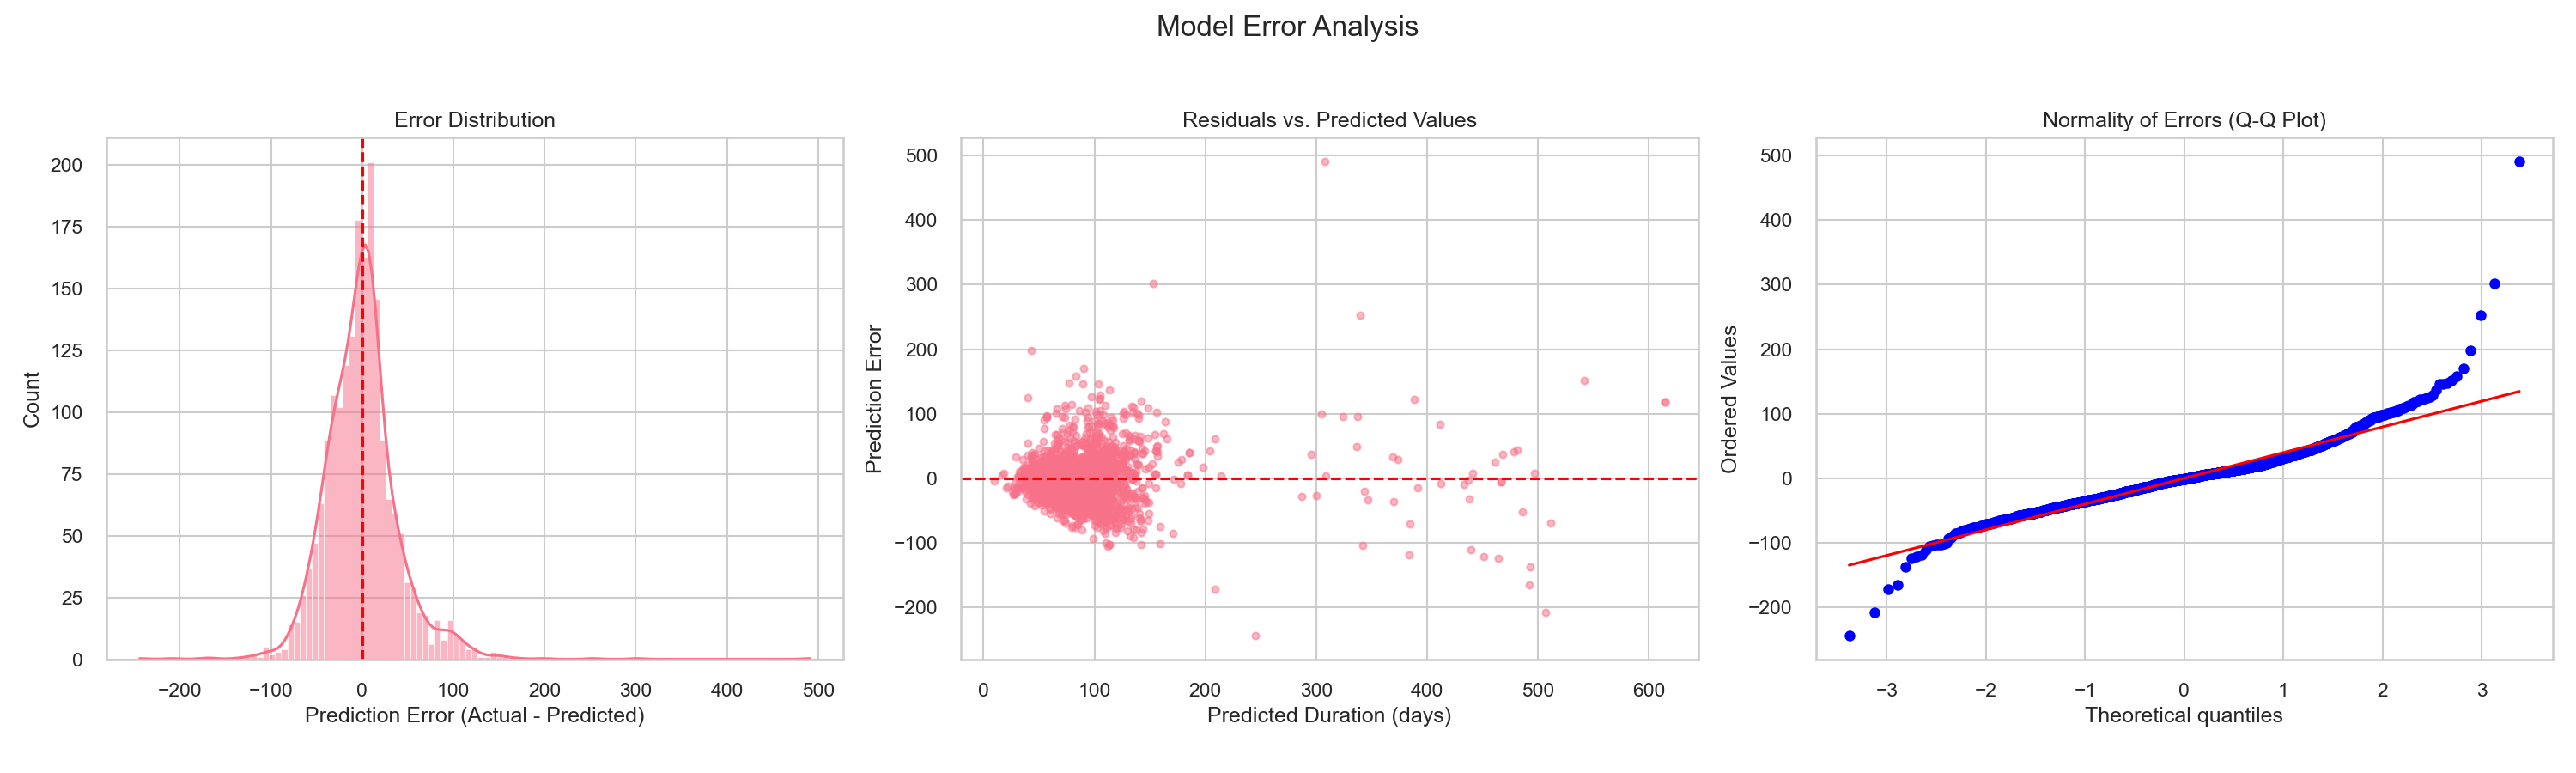

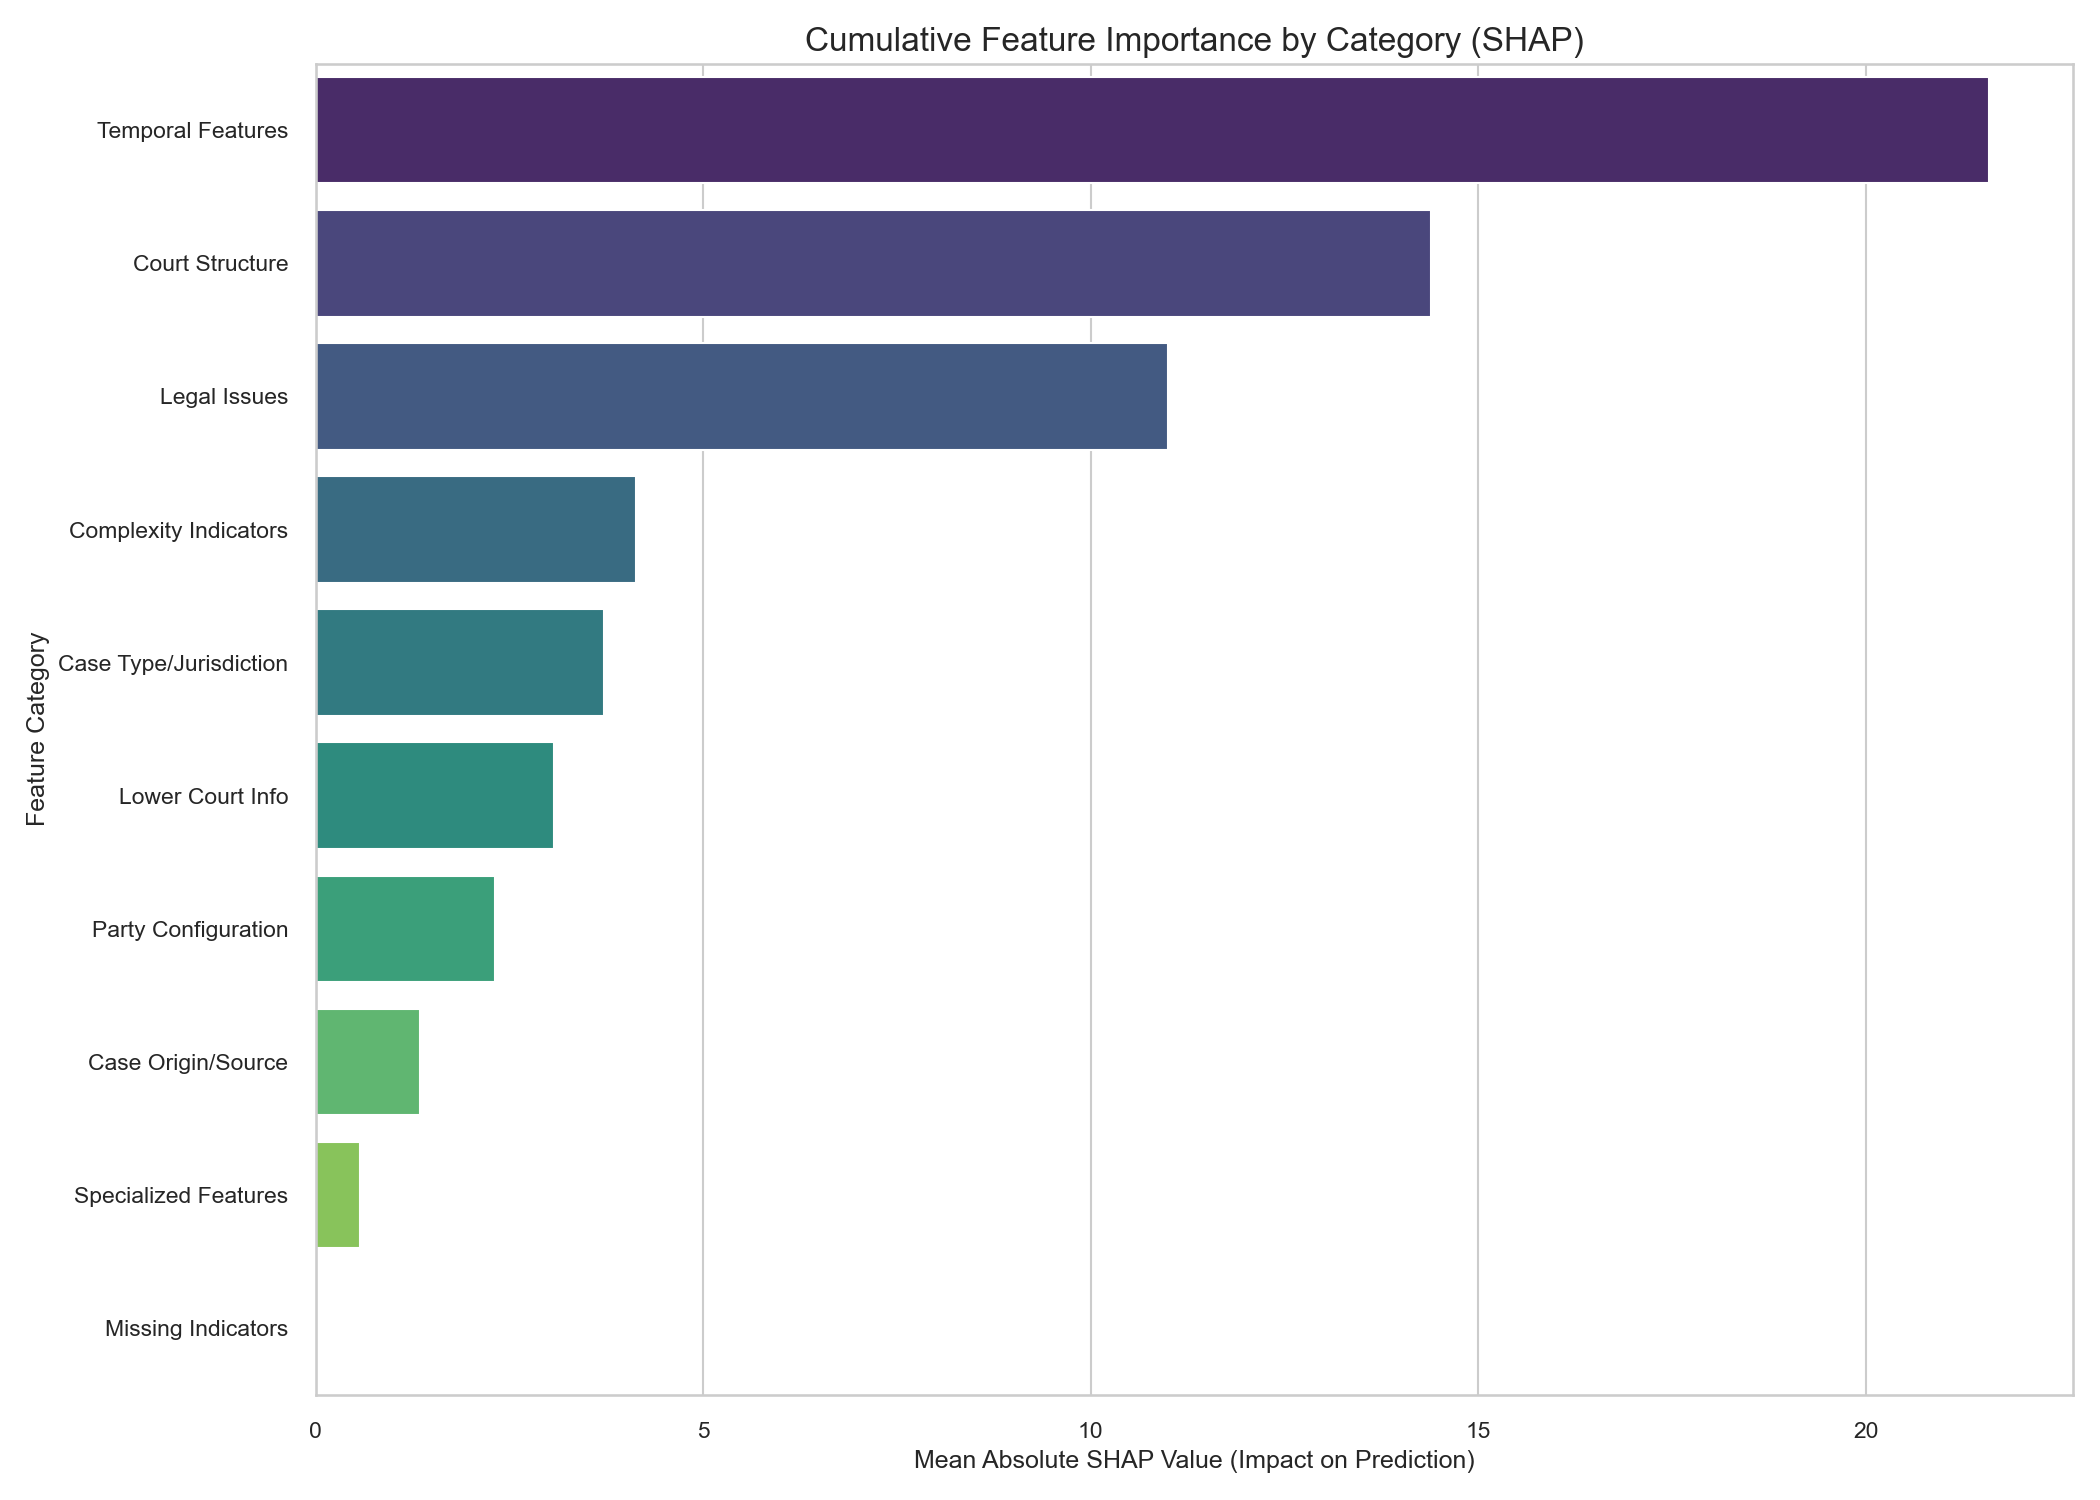

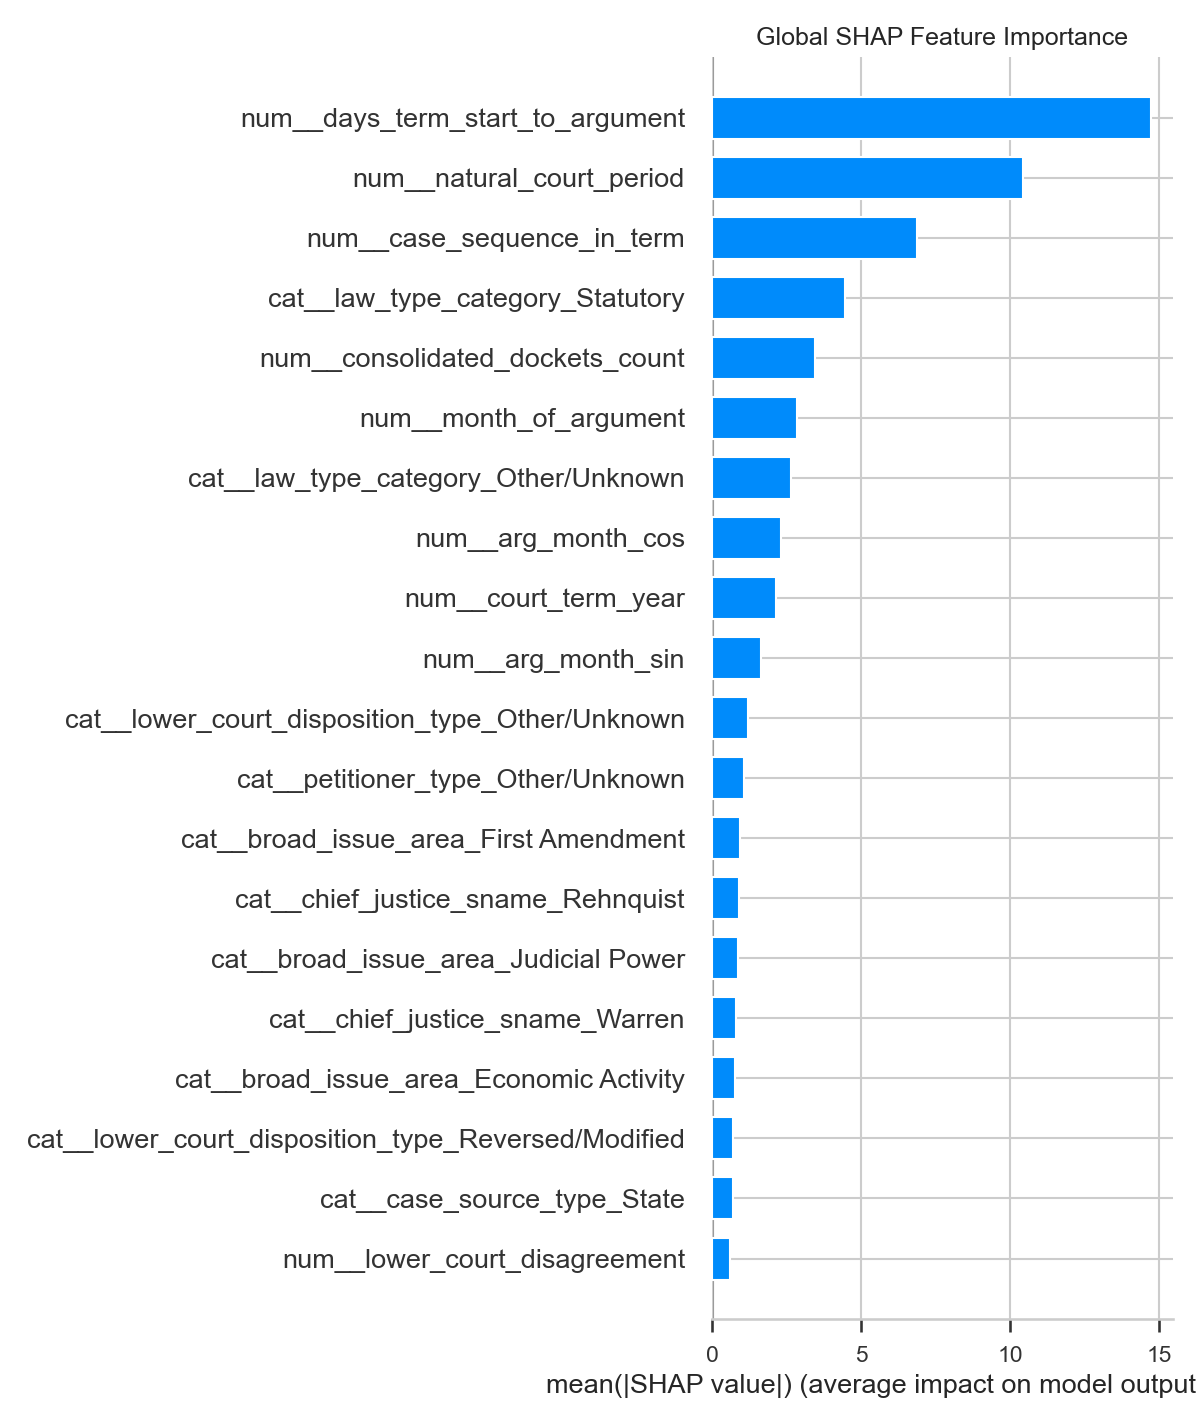

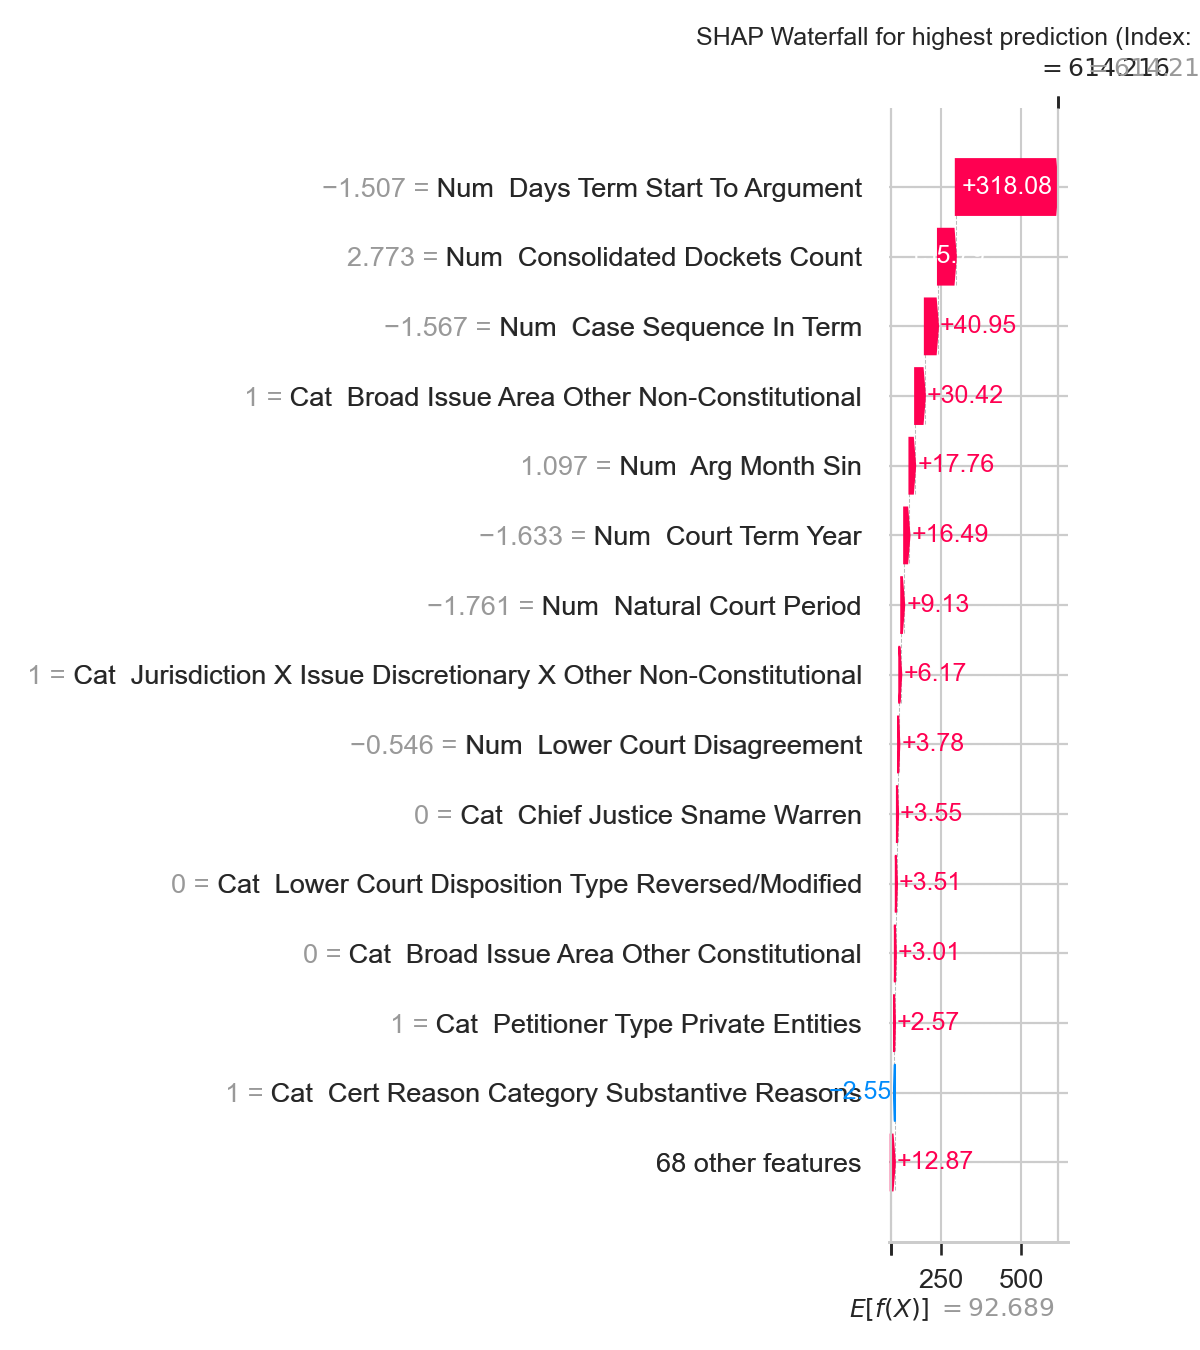

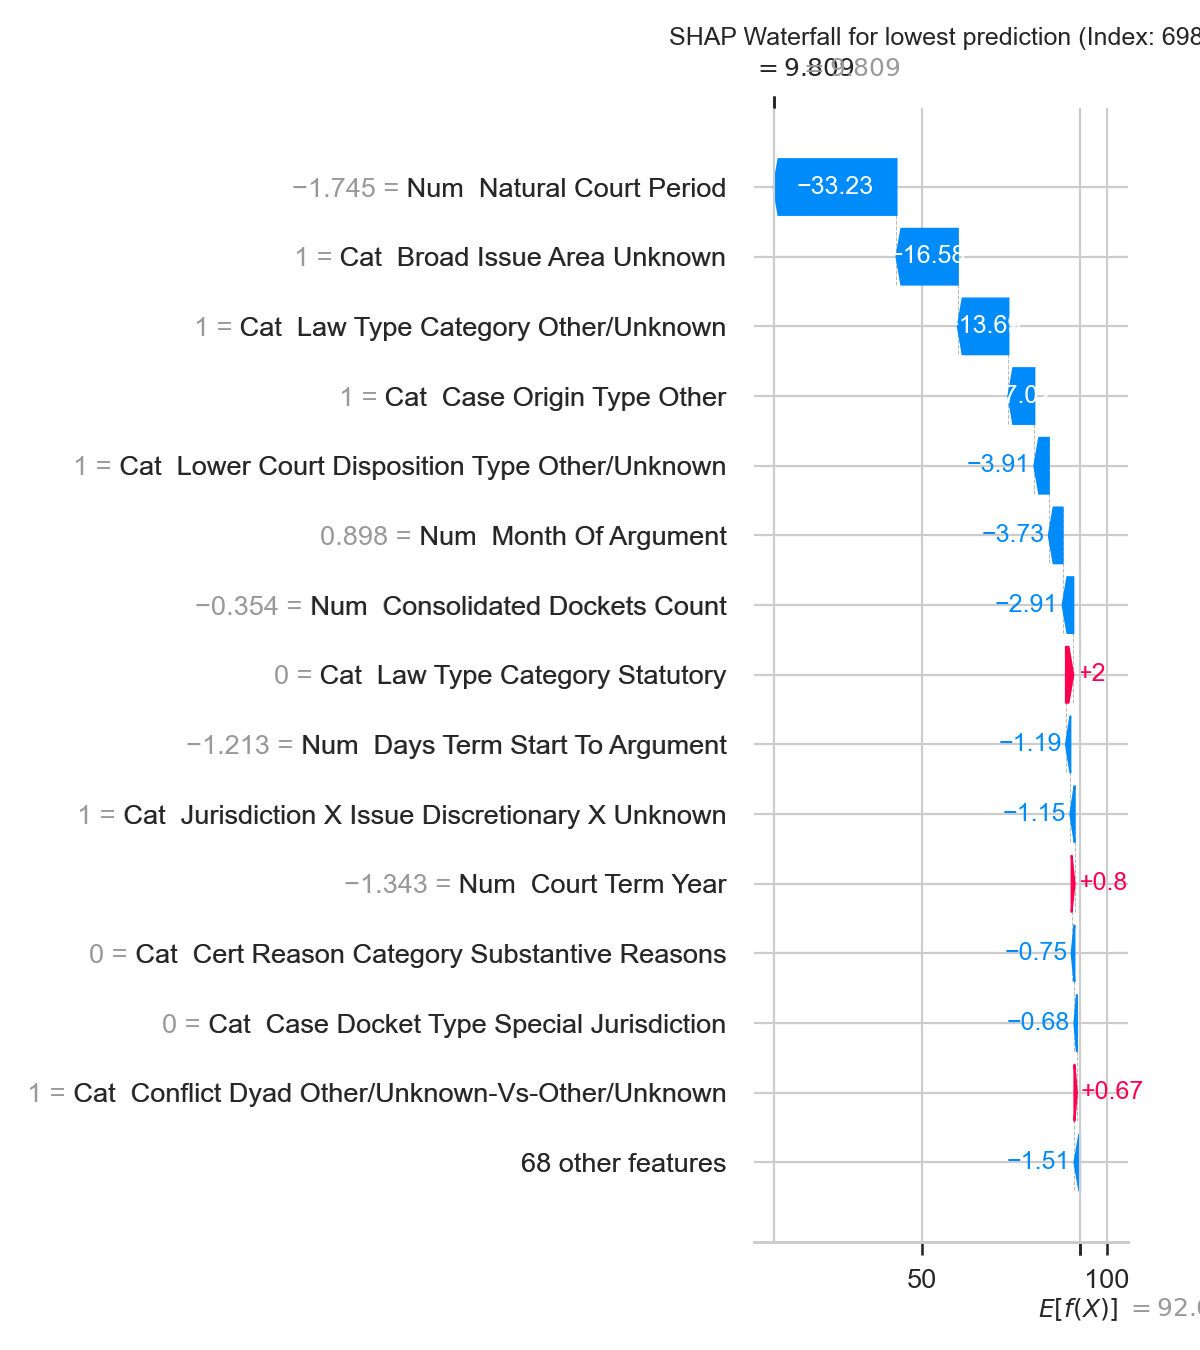

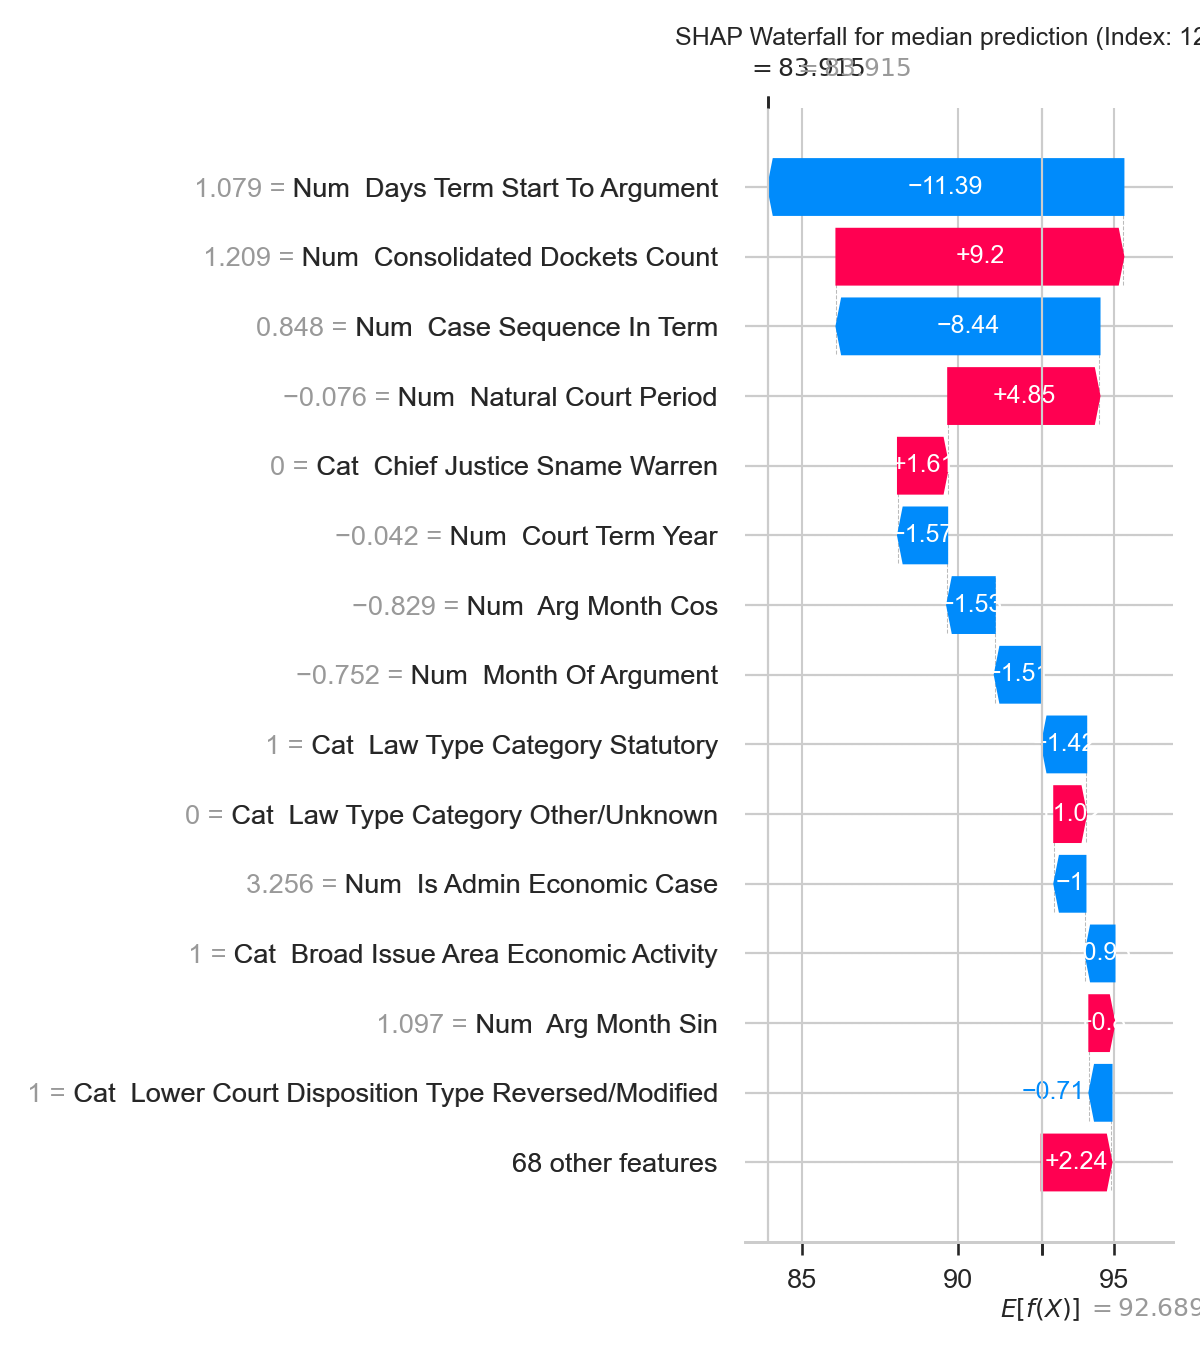

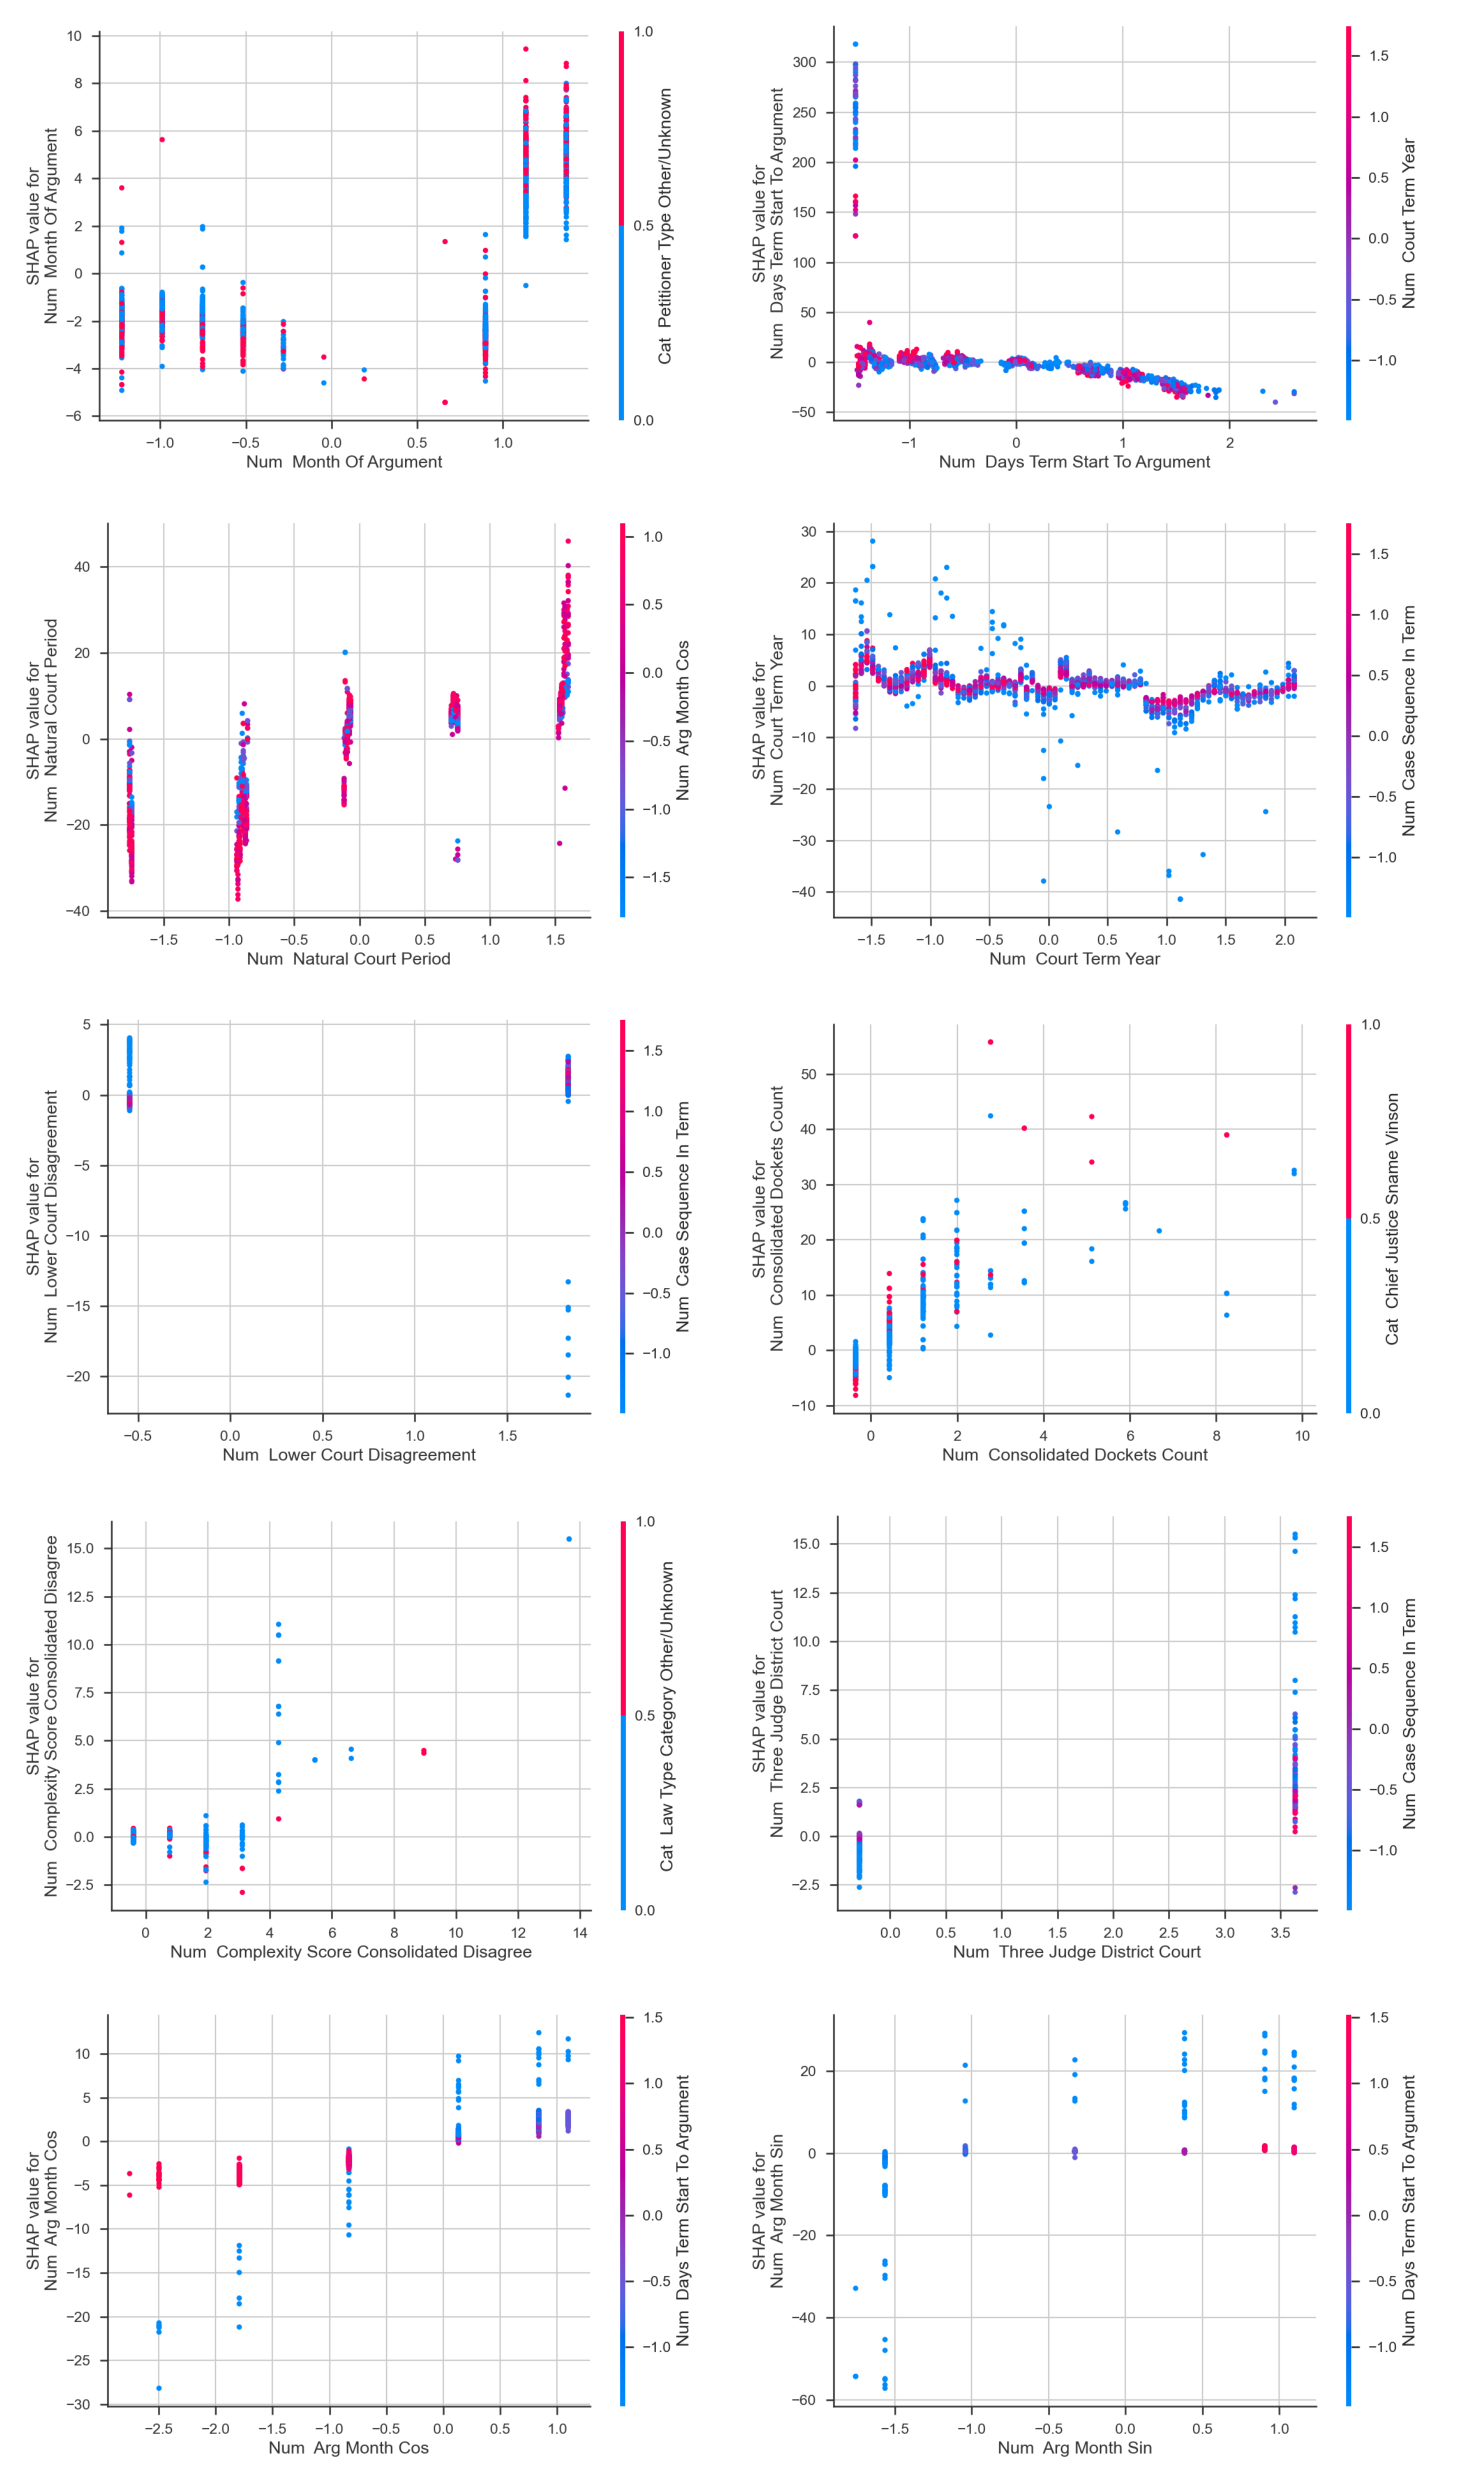

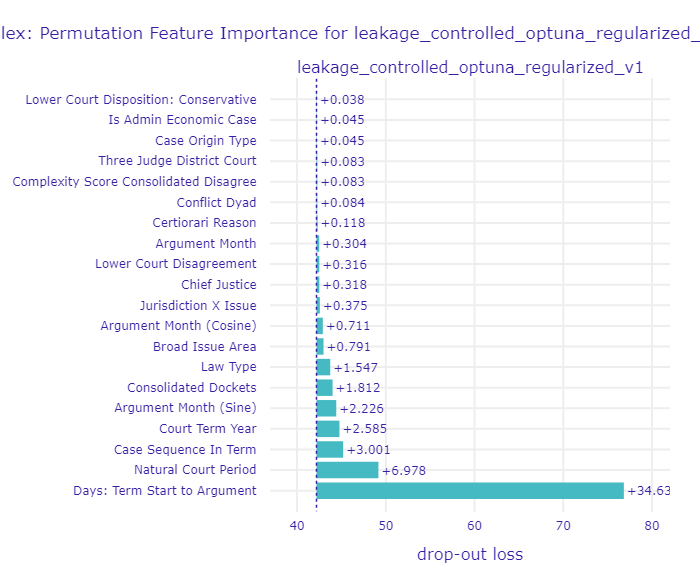

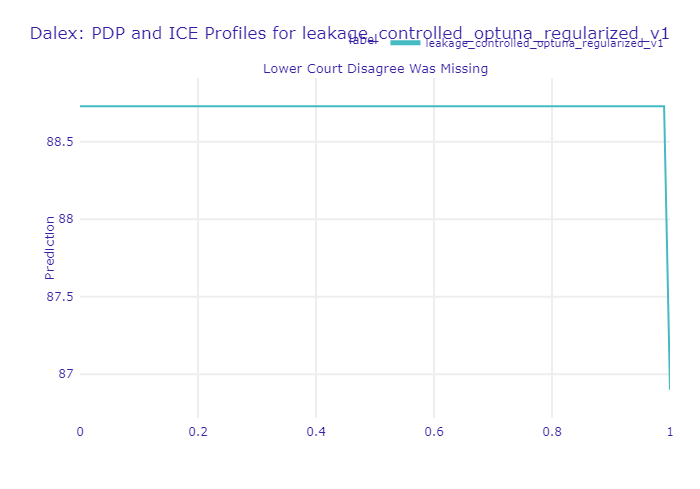

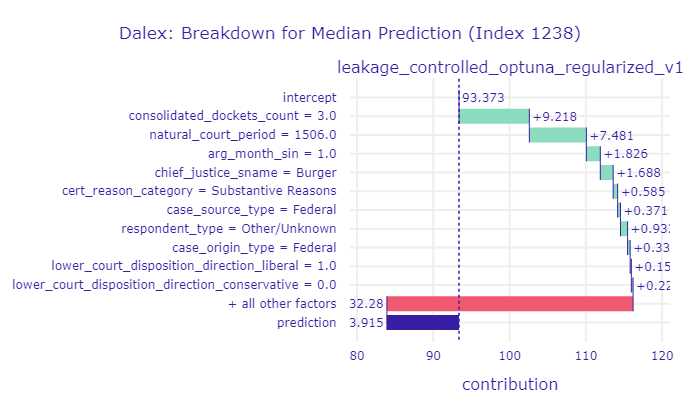

In [57]:
# =============================================================================
# USAGE
# =============================================================================

# Option 1: Run after 
if 'model_plots_dir' in globals():
    display_xai_report_with_descriptions()

# Option 2: Specify path directly
# display_xai_report_with_descriptions(
#     model_plots_dir='../models/scdb_duration_leakage_controlled_optuna_regularized_v1/xai_analysis_report_v5',
#     model_name='Leakage Controlled Optuna Regularized'
# )

# Option 3: Get plot descriptions
# descriptions = generate_plot_descriptions()
# for plot_type, info in descriptions.items():
#     print(f"\n{info['title']}:")
#     print(f"Purpose: {info['purpose']}")
#     print("Key Insights:")
#     for insight in info['insights']:
#         print(f"  - {insight}")